In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928 entries, 0 to 2927
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            2928 non-null   object
 1   price_band      2928 non-null   object
 2   zip_code        2928 non-null   object
 3   mls_listings    2928 non-null   object
 4   mls_contracts   2928 non-null   int64 
 5   od_listings     2928 non-null   int64 
 6   od_contracts    2928 non-null   int64 
 7   od_home_visits  2928 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 183.1+ KB


In [4]:
# Clean up dataframe
data['date'] = pd.to_datetime(data['date'])
data['mls_listings'] = data.mls_listings.str.replace(',', '').astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928 entries, 0 to 2927
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            2928 non-null   datetime64[ns]
 1   price_band      2928 non-null   object        
 2   zip_code        2928 non-null   object        
 3   mls_listings    2928 non-null   int32         
 4   mls_contracts   2928 non-null   int64         
 5   od_listings     2928 non-null   int64         
 6   od_contracts    2928 non-null   int64         
 7   od_home_visits  2928 non-null   int64         
dtypes: datetime64[ns](1), int32(1), int64(4), object(2)
memory usage: 171.7+ KB


In [5]:
data.head(10)

date price_band zip_code  mls_listings  mls_contracts  od_listings  \
0 2017-01-07     <$200K        A           736             18           41   
1 2017-01-07     <$200K        B           368             16           21   
2 2017-01-07     <$200K        C           147              5            8   
3 2017-01-07     <$200K        D           221              7           12   
4 2017-01-08     <$200K        A           727             17           40   
5 2017-01-08     <$200K        B           364             15           20   
6 2017-01-08     <$200K        C           145              4            8   
7 2017-01-08     <$200K        D           218              6           12   
8 2017-01-09     <$200K        A           719             25           40   
9 2017-01-09     <$200K        B           359             22           20   

   od_contracts  od_home_visits  
0             2             410  
1             1             205  
2             0              82  
3             1             123  
4             2             401  
5             1             200  
6             0              80  
7             0             120  
8             3             396  
9             1             198

In [6]:
## Understanding the time series
# Count number of rows per date
date_counts = data.groupby('date').size()

# Display basic info about dates
print(f"First date: {data['date'].min()}")
print(f"Last date: {data['date'].max()}")
print(f"\nTotal unique dates: {len(date_counts)}")
print(f"\nRows per date:\n{date_counts.value_counts().sort_index()}")

# Check if there are any gaps in dates
date_range = pd.date_range(start=data['date'].min(), end=data['date'].max())
missing_dates = set(date_range) - set(data['date'])
if missing_dates:
    print(f"\nMissing dates: {sorted(missing_dates)}")
else:
    print("\nNo gaps in dates - continuous daily data")

First date: 2017-01-07 00:00:00
Last date: 2018-01-07 00:00:00

Total unique dates: 366

Rows per date:
8    366
Name: count, dtype: int64

No gaps in dates - continuous daily data


<Axes: title={'center': 'Time Series for <$200K Houses in Zone A'}, xlabel='date'>

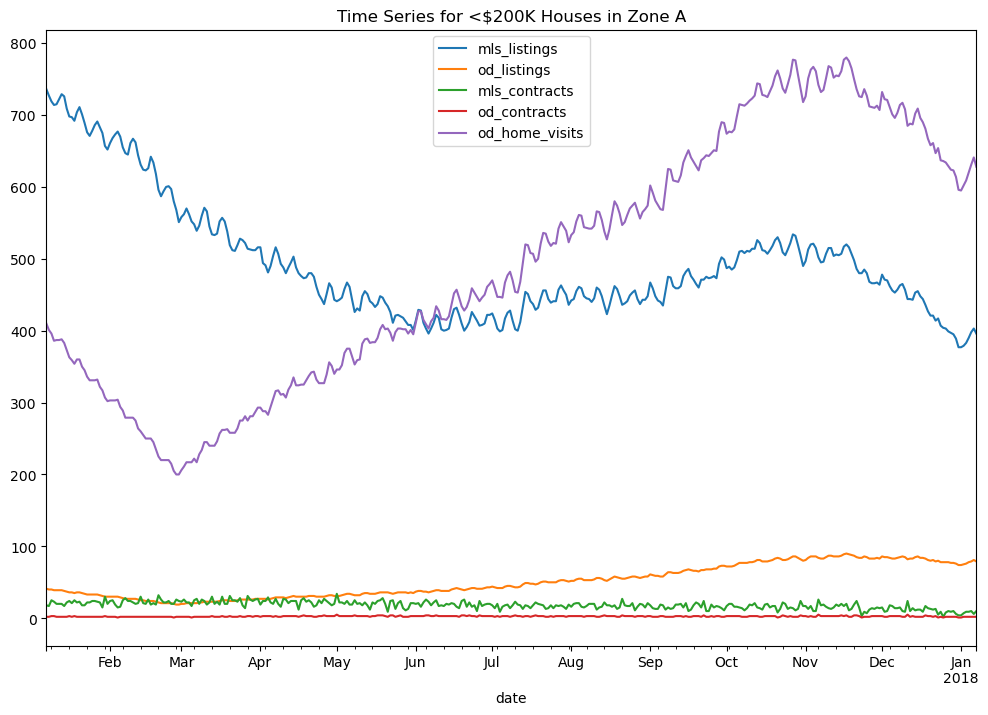

In [7]:
# Understand how a particular zip/price_band time series works
# Filter data for price_band "<$200K" and zip_code "A"
filtered_data = data[
    (data['price_band'] == '<$200K') & 
    (data['zip_code'] == 'A')
].sort_values('date')

filtered_data.plot(x='date', 
    y=['mls_listings', 'od_listings', 'mls_contracts', 'od_contracts', 'od_home_visits'], 
    figsize=(12, 8),
    title='Time Series for <$200K Houses in Zone A')


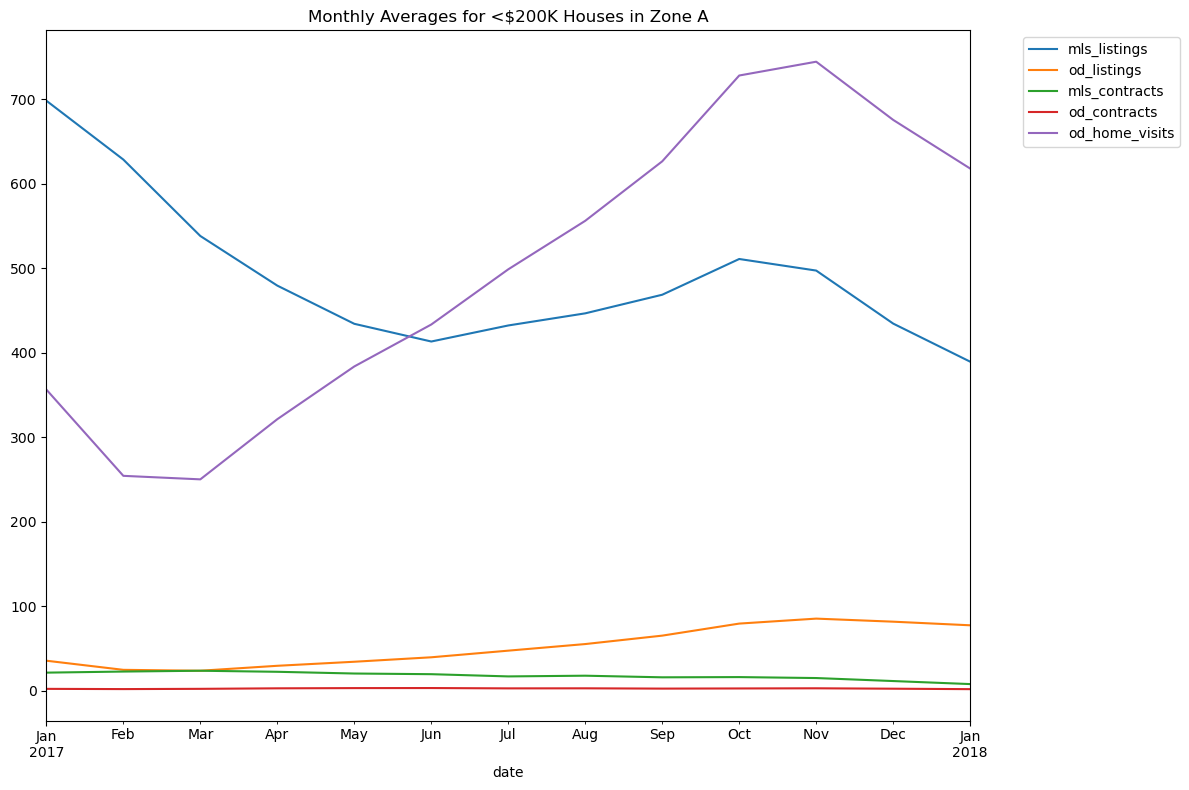

In [8]:
# Need to see if monthly trends are similar to overall trends and can help reduce noise

# Filter data for price_band "<$200K" and zip_code "A"
filtered_data = data[
    (data['price_band'] == '<$200K') & 
    (data['zip_code'] == 'A')
].sort_values('date') [['date', 'mls_listings', 'od_listings', 'mls_contracts', 'od_contracts', 'od_home_visits']]

# Resample data to monthly averages
monthly_data = filtered_data.set_index('date').resample('ME').mean()

monthly_data.plot(
    y=['mls_listings', 'od_listings', 'mls_contracts', 'od_contracts', 'od_home_visits'],
    figsize=(12, 8),
    title='Monthly Averages for <$200K Houses in Zone A'
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

## Question 1
We’ve given you disguised data for the MLS (market) and Opendoor. The spreadsheet includes
counts of active listings, visits, resale contracts, and related data including price point and geo
codes. How enthusiastic or worried are you about Opendoor’s resale performance in 2017? 

### Approach
At a high level to determine my assessment of Opendoor's resale performance in 2017, I would look take the following steps:
1. Determine metrics for performance of resale for both Opendoor and the market.
2. Observe monthly trends over the course of 2017 and see how they change for all houses.
3. Leverage my categorical variables price_band and zip_code to observe variation in monthly trends.

## Field Definitions
**price_band**: original list price bucketed below and above $200K

**zip_code**: A, B, C, and D denote 4 different, illustrative zips

**mls_listings**: total active listings on the market on any given day

**mls_contracts**: resales contracts

**od_listings**: total Opendoor active listings on the market on any given day

**od_contracts**: Opendoor resales contracts

**od_home_visits**: total home visits on all active listings

In [12]:

# **Part 1**
# Defining some key metrics to understand contracts conversion relative to listings.

def calculate_performance_metrics(data_xs):
    """Calculate key performance metrics for Opendoor vs Market performance and add them to input dataframe
    
    Metrics added to dataframe:
    - mls_contract_to_listing_ratio: Conversion rate of MLS listings to contracts
    - od_contract_to_listing_ratio: Conversion rate of Opendoor listings to contracts
    - contract_conversion_vs_market: How Opendoor's conversion rate compares to market (>1 means better)
    - listings_od_market_share: Opendoor's share of total market listings
    - contracts_od_market_share: Opendoor's share of total market contracts
    - visits_to_listings_ratio: Average number of visits per Opendoor listing
    - visits_to_contracts_ratio: Number of visits needed per contract secured
    
    Returns:
        Original dataframe with additional calculated metric columns
    """
    # Conversion metrics - measure ability to convert listings to contracts
    data_xs['mls_contract_to_listing_ratio'] = data_xs.mls_contracts/data_xs.mls_listings
    data_xs['od_contract_to_listing_ratio'] = data_xs.od_contracts/data_xs.od_listings
    data_xs['contract_conversion_vs_market'] = data_xs.od_contract_to_listing_ratio/data_xs.mls_contract_to_listing_ratio
    
    # Market share metrics - measure Opendoor's presence in the market
    data_xs['listings_od_market_share'] = data_xs.od_listings/data_xs.mls_listings
    data_xs['contracts_od_market_share'] = data_xs.od_contracts/data_xs.mls_contracts
    
    # Visit metrics - measure efficiency of home visits in generating contracts
    data_xs['visits_to_listings_ratio'] = data_xs.od_home_visits/data_xs.od_listings
    data_xs['visits_to_contracts_ratio'] = data_xs.od_home_visits/data_xs.od_contracts
    
    return data_xs



In [55]:
def plot_performance_metrics(data_xs, monthly=True, title_flag=None):
    """
    Plot performance metrics in three separate graphs: conversion, visit, and market share metrics.
    
    Args:
        data_xs (pd.DataFrame): DataFrame containing the calculated metrics
        monthly (bool): If True, resample data to monthly averages. If False, use raw data
        title_flag (str, optional): Additional text to append to plot titles. Defaults to None.
    """
    # If monthly flag is True, resample to monthly averages
    if monthly:
        plot_data = data_xs.groupby(data_xs['date'].dt.to_period('M')).mean()
    else:
        plot_data = data_xs.set_index('date')
    
    # Prepare title suffix
    title_suffix = f" - {title_flag}" if title_flag else ""
    
    # Create six separate plots
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(12, 35))
    
    # Plot 1: Contract to Listing Ratios
    plot_data[['mls_contract_to_listing_ratio', 'od_contract_to_listing_ratio']].plot(ax=ax1)
    if monthly:
        for col in ['mls_contract_to_listing_ratio', 'od_contract_to_listing_ratio']:
            for idx, val in plot_data[col].items():
                ax1.annotate(f'{val:.3f}', (idx.to_timestamp(), val), textcoords="offset points", xytext=(0,10), ha='center')
    ax1.set_title(f'Contract to Listing Conversion Percent Over Time{title_suffix}')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 2: Contract Conversion vs Market
    plot_data['contract_conversion_vs_market'].plot(ax=ax2)
    if monthly:
        for idx, val in plot_data['contract_conversion_vs_market'].items():
            ax2.annotate(f'{val:.3f}', (idx.to_timestamp(), val), textcoords="offset points", xytext=(0,10), ha='center')
    ax2.axhline(y=1, linestyle=':', color='black')  # Add horizontal dotted line at y=1
    ax2.set_title(f'Contract Conversion vs Market Over Time{title_suffix}')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Market Share Metrics
    # Plot 3: Listings OD Market Share
    plot_data['listings_od_market_share'].plot(ax=ax3)
    if monthly:
        for idx, val in plot_data['listings_od_market_share'].items():
            ax3.annotate(f'{val:.3f}', (idx.to_timestamp(), val), textcoords="offset points", xytext=(0,10), ha='center')
    ax3.set_title(f'Listings OD Market Share Over Time{title_suffix}')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 4: Contracts OD Market Share  
    plot_data['contracts_od_market_share'].plot(ax=ax4)
    if monthly:
        for idx, val in plot_data['contracts_od_market_share'].items():
            ax4.annotate(f'{val:.3f}', (idx.to_timestamp(), val), textcoords="offset points", xytext=(0,10), ha='center')
    ax4.set_title(f'Contracts OD Market Share Over Time{title_suffix}')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Visit Metrics
    # Plot 5: Visits to Listings Ratio
    plot_data['visits_to_listings_ratio'].plot(ax=ax5)
    if monthly:
        for idx, val in plot_data['visits_to_listings_ratio'].items():
            ax5.annotate(f'{val:.1f}', (idx.to_timestamp(), val), textcoords="offset points", xytext=(0,10), ha='center')
    ax5.set_title(f'Visits to Listings Ratio Over Time{title_suffix}')
    ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 6: Visits to Contracts Ratio
    plot_data['visits_to_contracts_ratio'].plot(ax=ax6)
    if monthly:
        for idx, val in plot_data['visits_to_contracts_ratio'].items():
            ax6.annotate(f'{val:.1f}', (idx.to_timestamp(), val), textcoords="offset points", xytext=(0,10), ha='center')
    ax6.set_title(f'Visits to Contracts Ratio Over Time{title_suffix}')
    ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    return fig

# Example usage:
# metrics_data = calculate_performance_metrics(filtered_data)
# plot_performance_metrics(metrics_data, monthly=True, title_flag="<$200K Houses in Zone A")

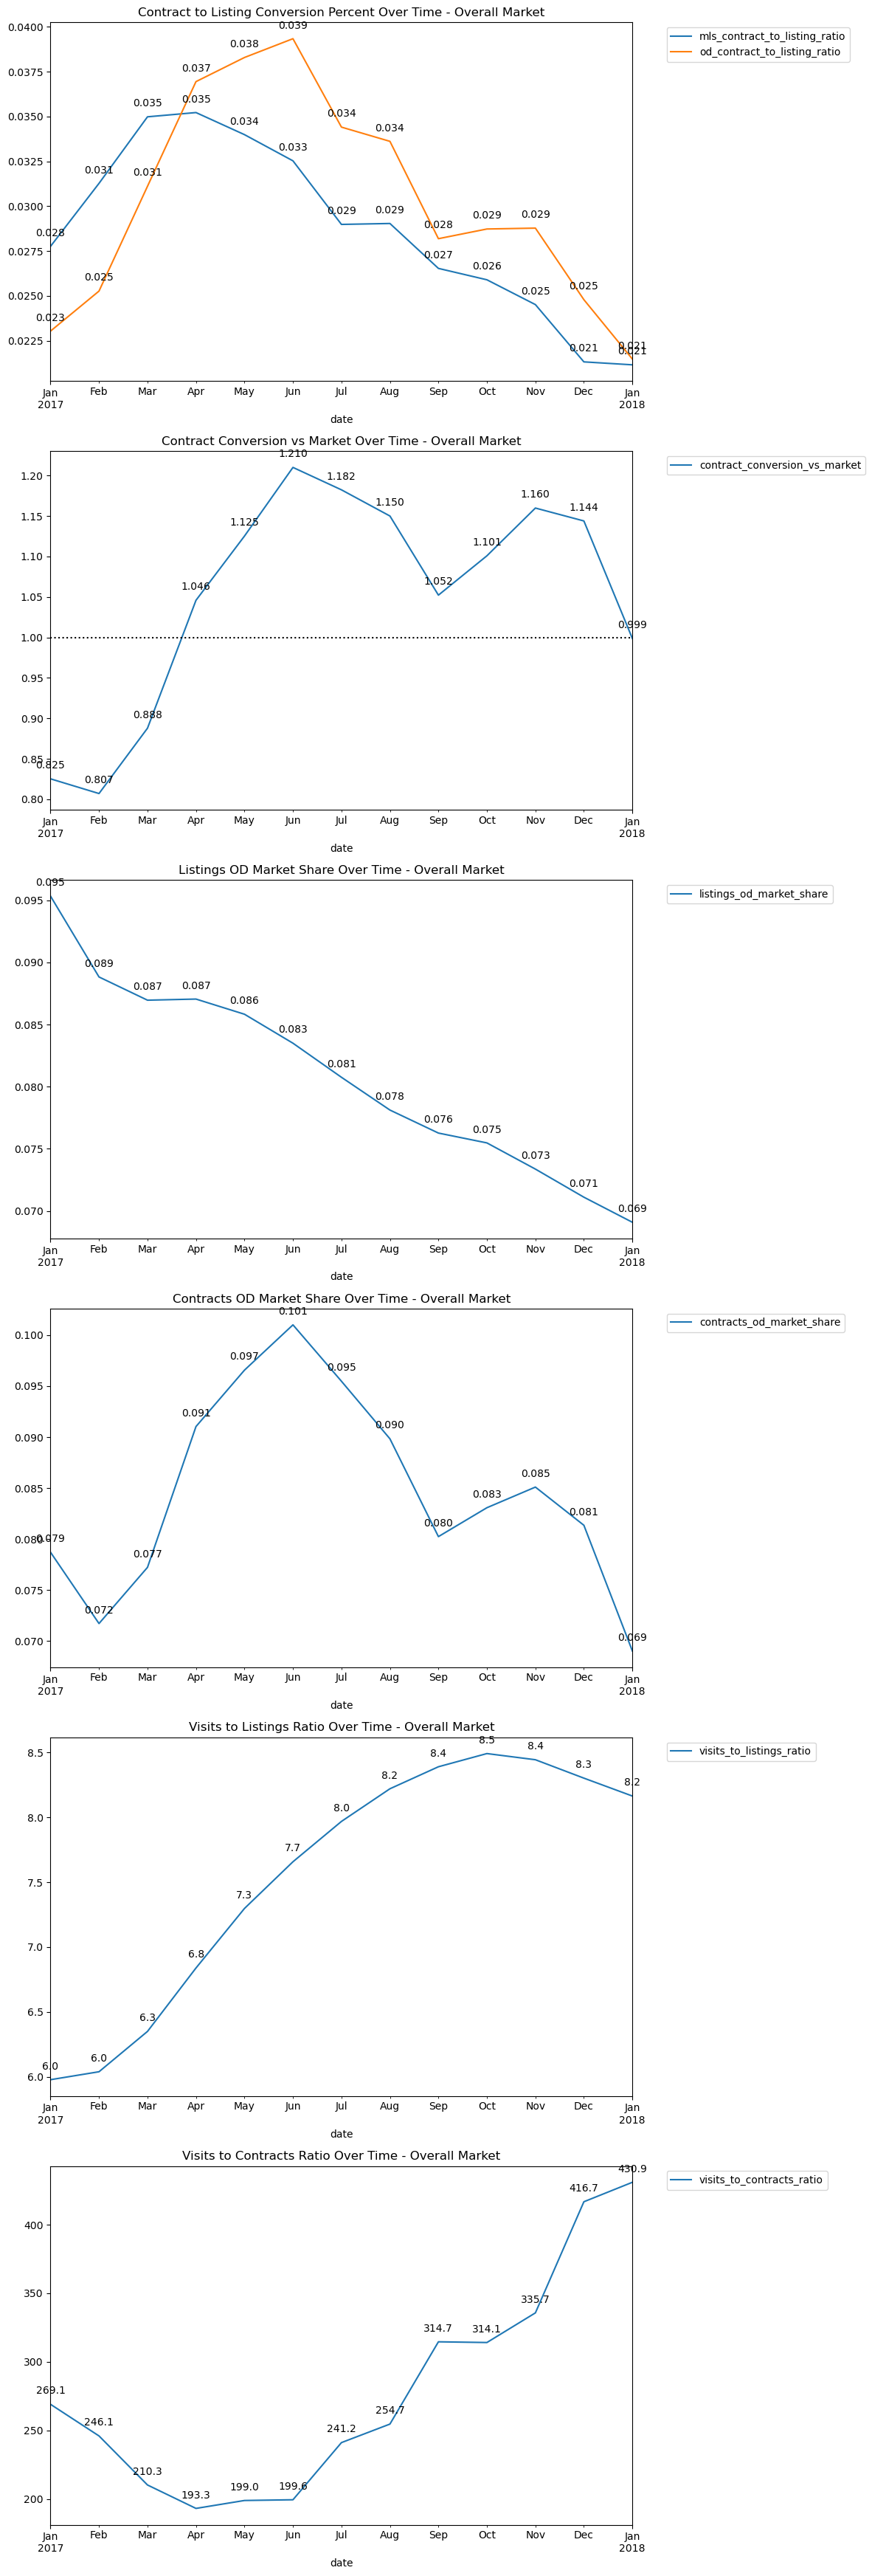

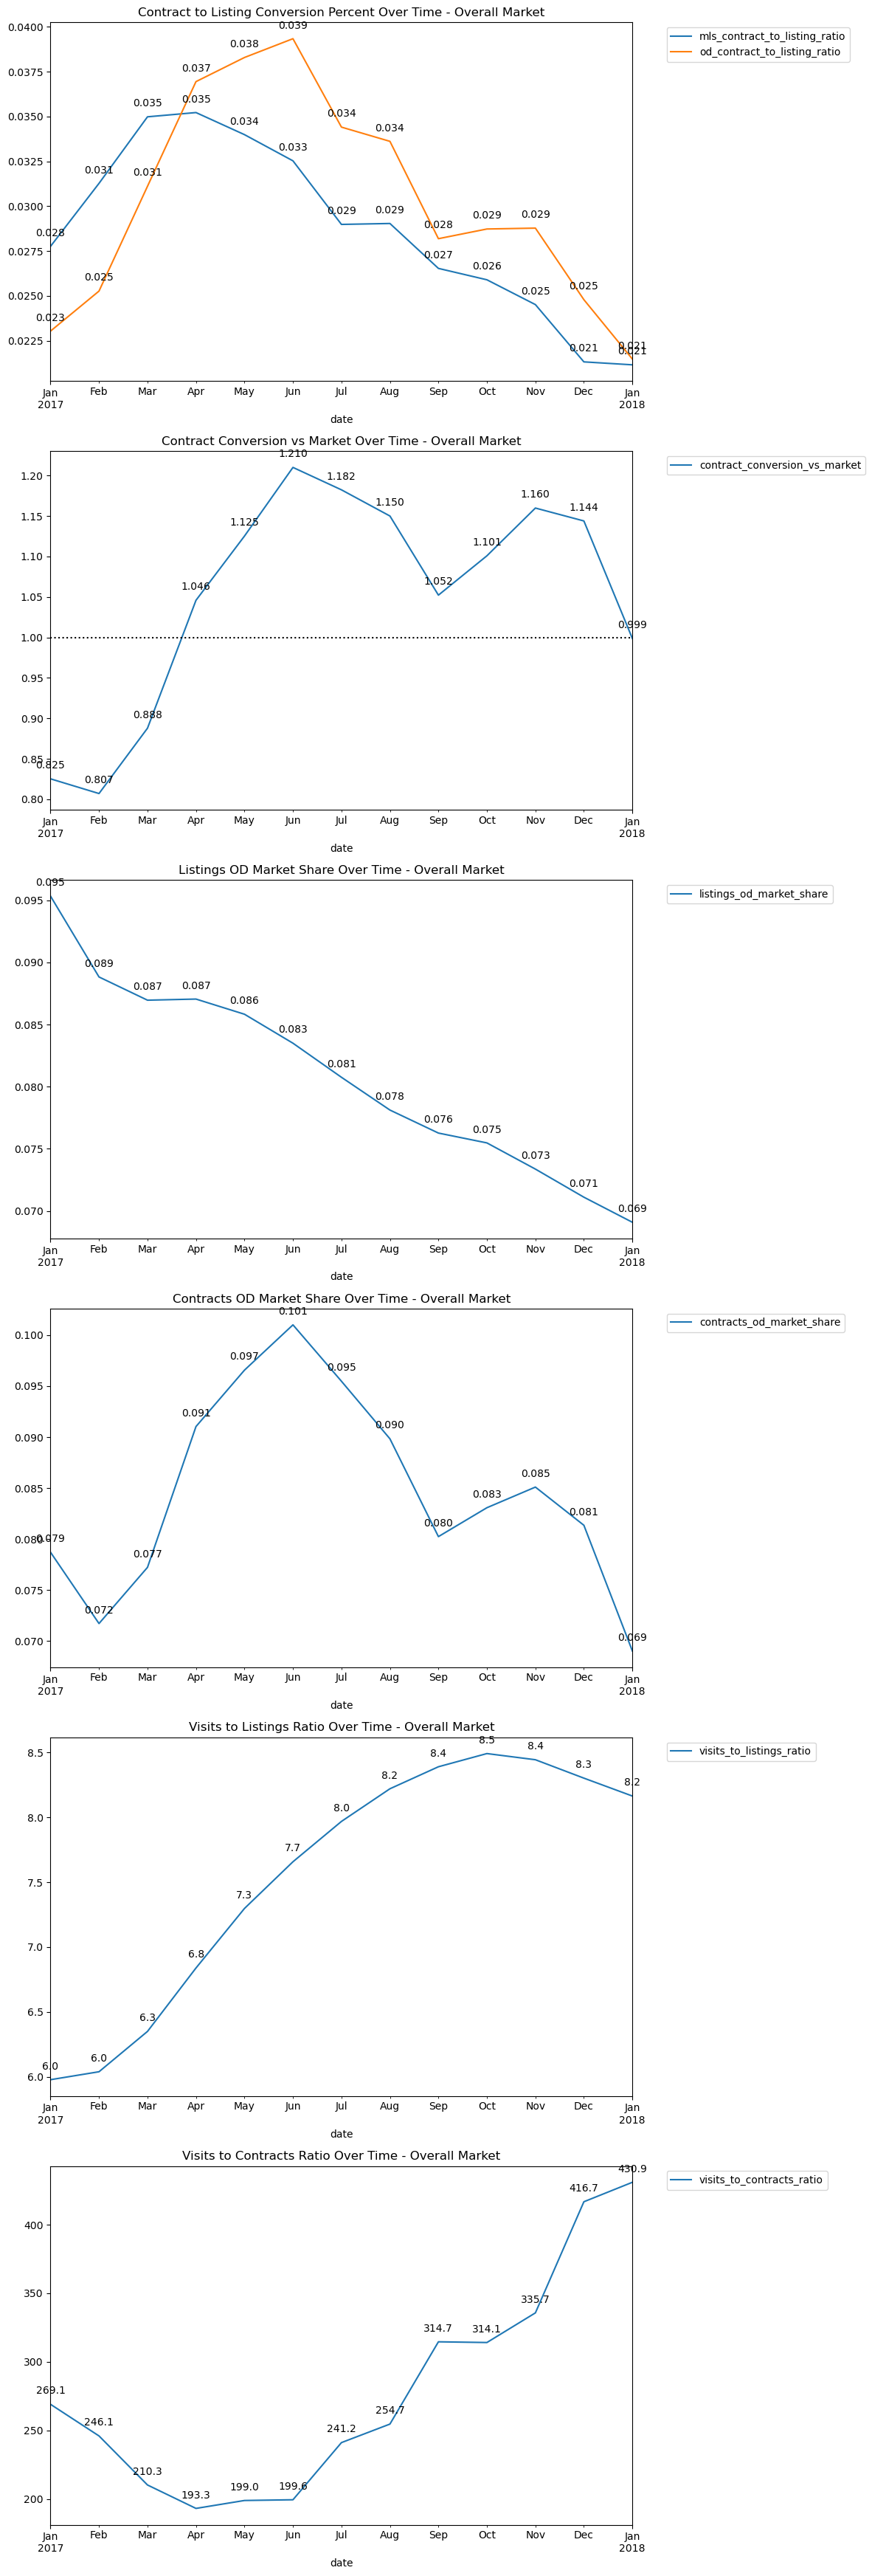

In [56]:
# ** Part 2 **
# 2. Let's look at the overall trend of the market and key metrics 
numeric_cols = ['mls_listings', 'od_listings', 'mls_contracts', 'od_contracts', 'od_home_visits']
total_data = data.groupby('date')[numeric_cols].sum().reset_index()
total_data = calculate_performance_metrics(total_data)
plot_performance_metrics(total_data, monthly=True, title_flag="Overall Market")

**Part 2 Observations**

This is aggregated across different zips and home prices for overall trends. 

Listing to Contract Conversion
- Ability to convert listings to resale contracts: Enthusiasm, but Concern on Go-forward basis: When looking at the ratio of listings to contracts conversion, Opendoor started out 2017 below the market in Q1 2017, but started out-performing at a peaks of 15%-20%, however ended the year performing at the market level again.


Market Share
- Major Concern : Listing market share - Declining market share of listings by Opendoor compared to the market, has been monotonically decreasing since January 2017 from ~10% to 7%.
- Enthusiasm, but Concern on Go-forward: Contract market  - increased from 7% in February increasing up to 10% in July, but subsequently declined down to 7-8% by the end of the year.

Visits
- Ability to drive visits: Enthusiasm - Visits per listing have been increasing meaning increased visits to each listing of Opendoor (no market benchmark available). This can be an indicator that interest in purchasing is increasing.
- Ability to convert visits: Major Concern - Visits per contract are increasing significantly which means that conversion rate is likely declining. There are significant visits but the conversion rate per visit is declining (this is in spite still being in line with the MLS contracts/listings ratio).


In [20]:
# ** Part 3 XS Observations **
# Need to determine what distributions of different categorical variables looks like to determine which are major drivers

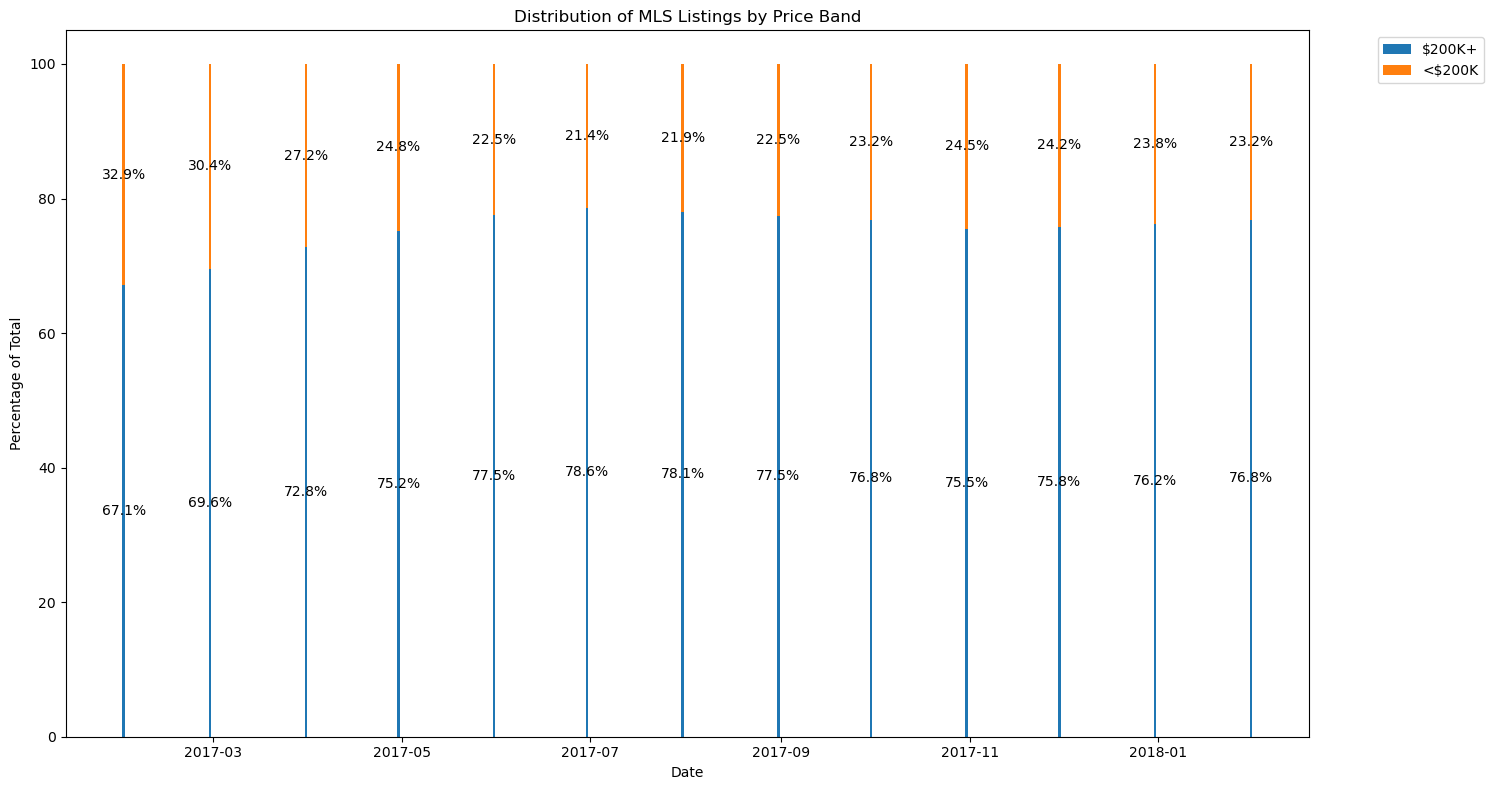

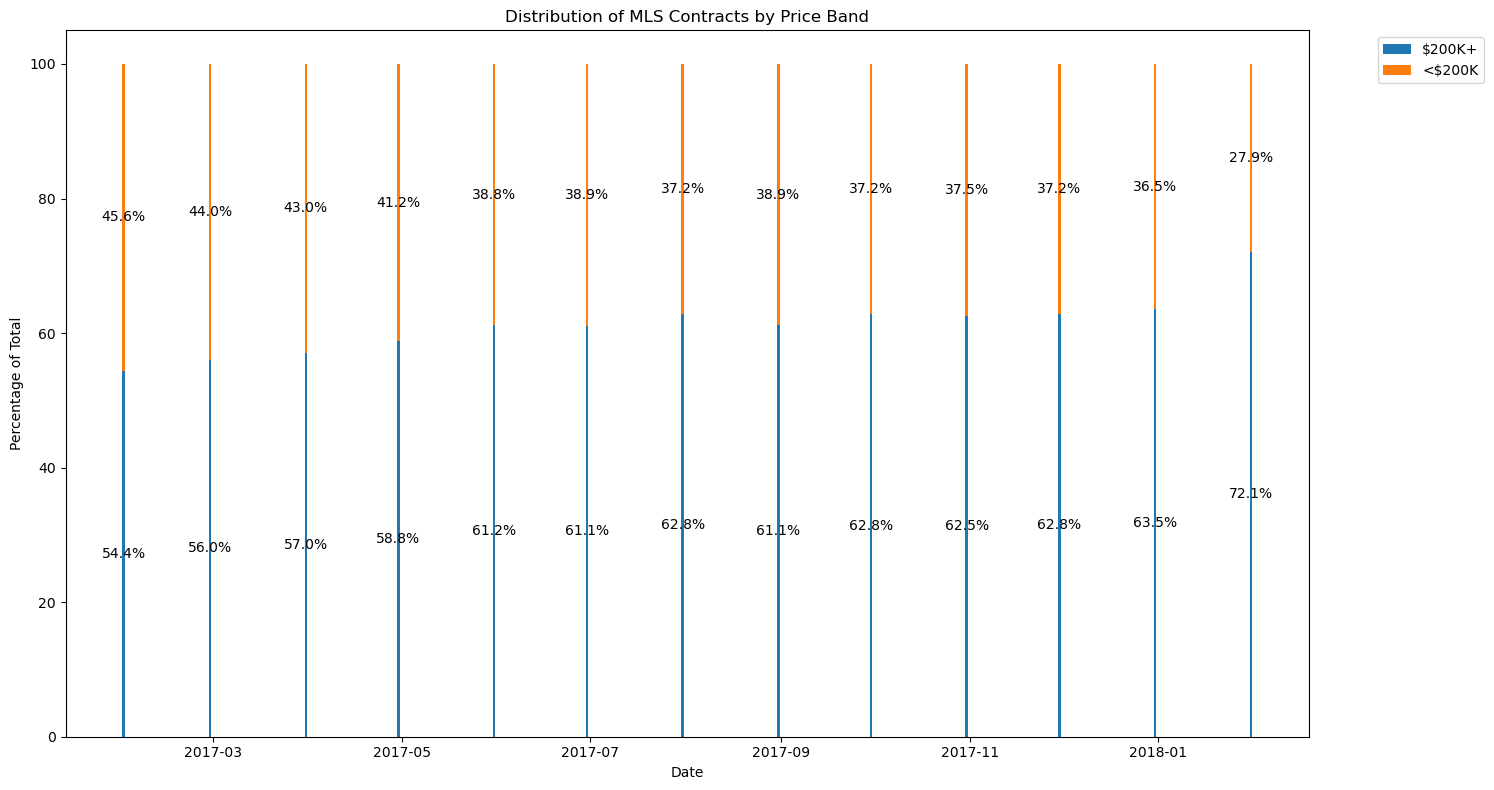

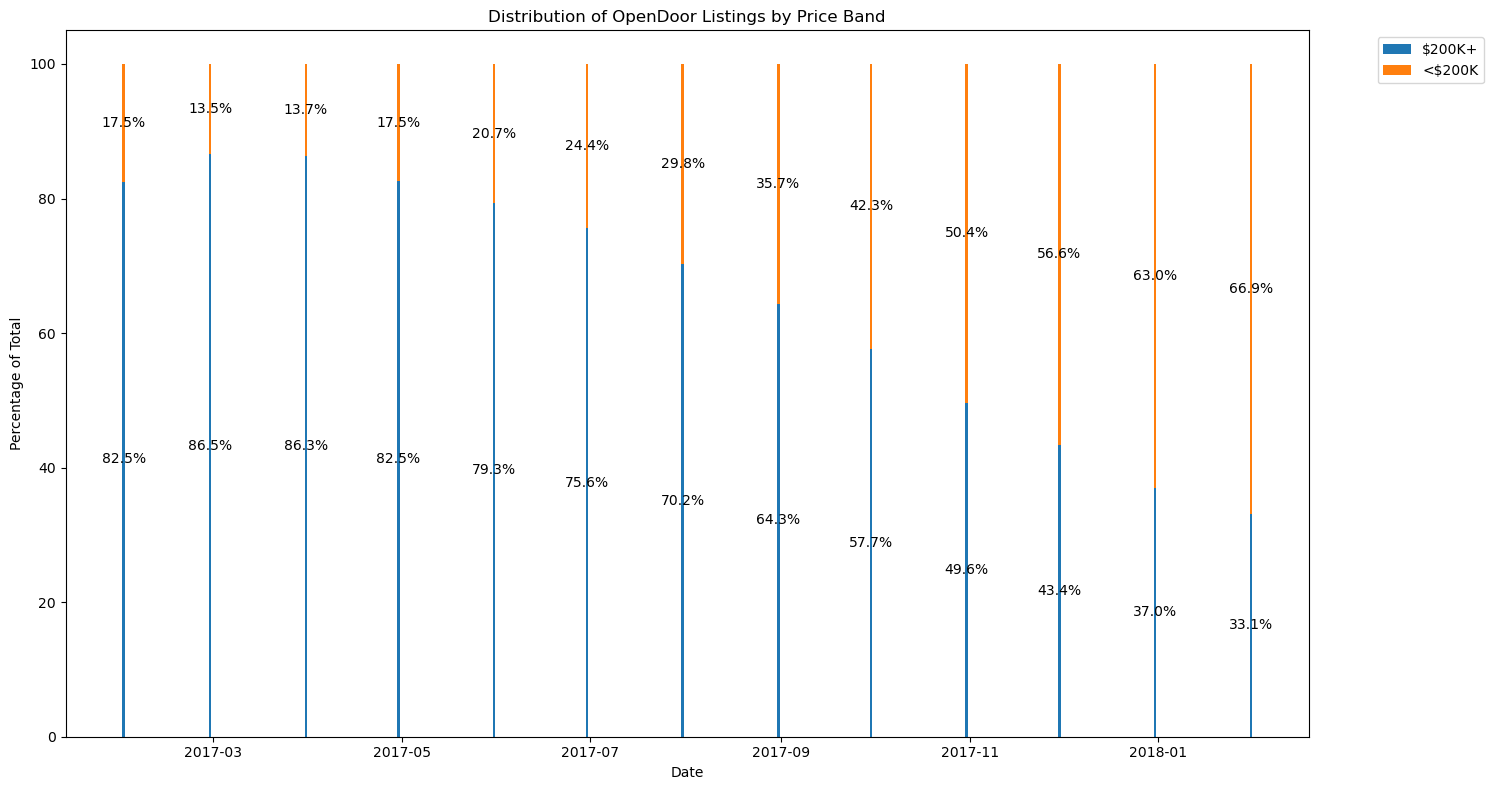

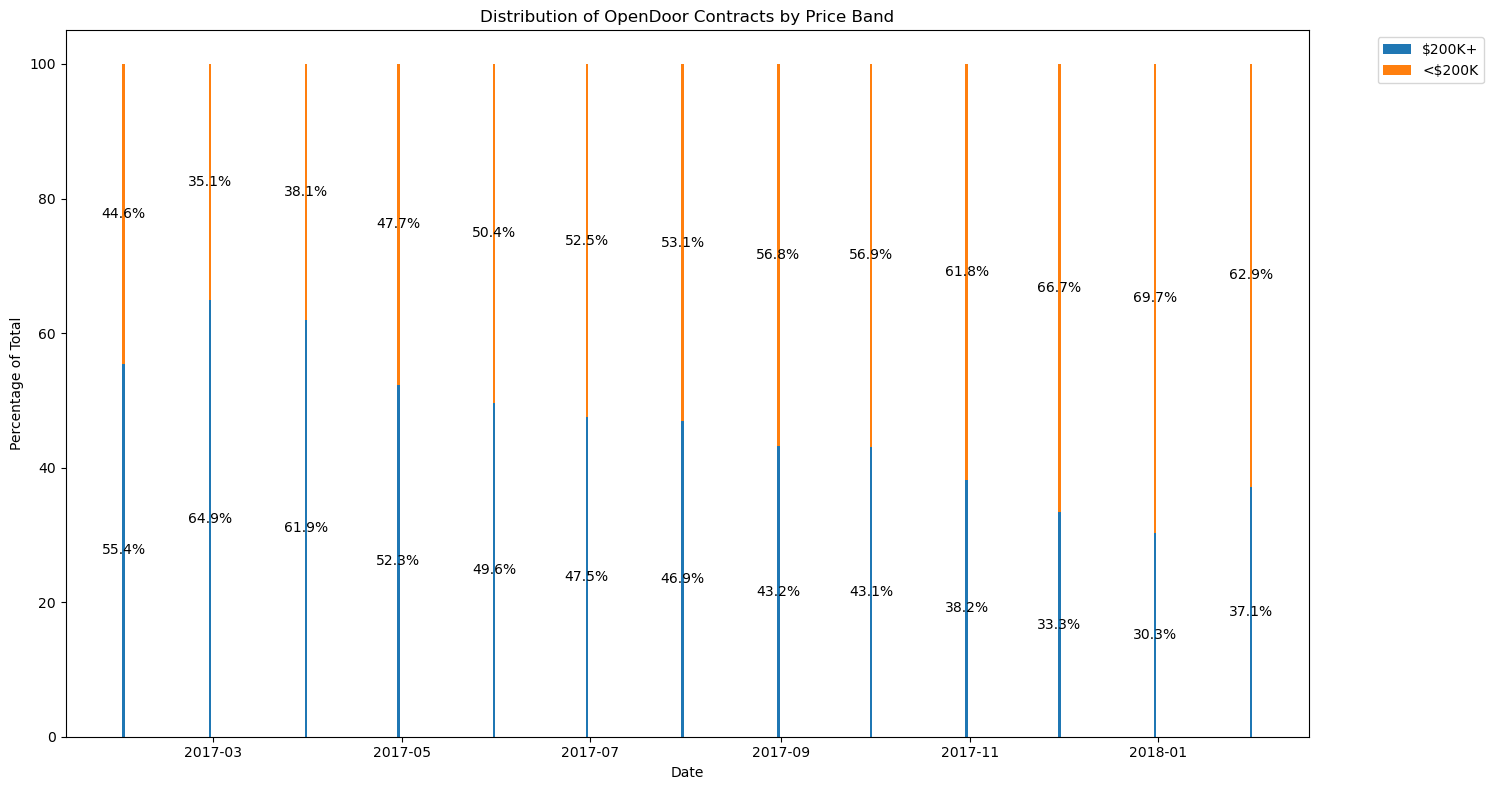

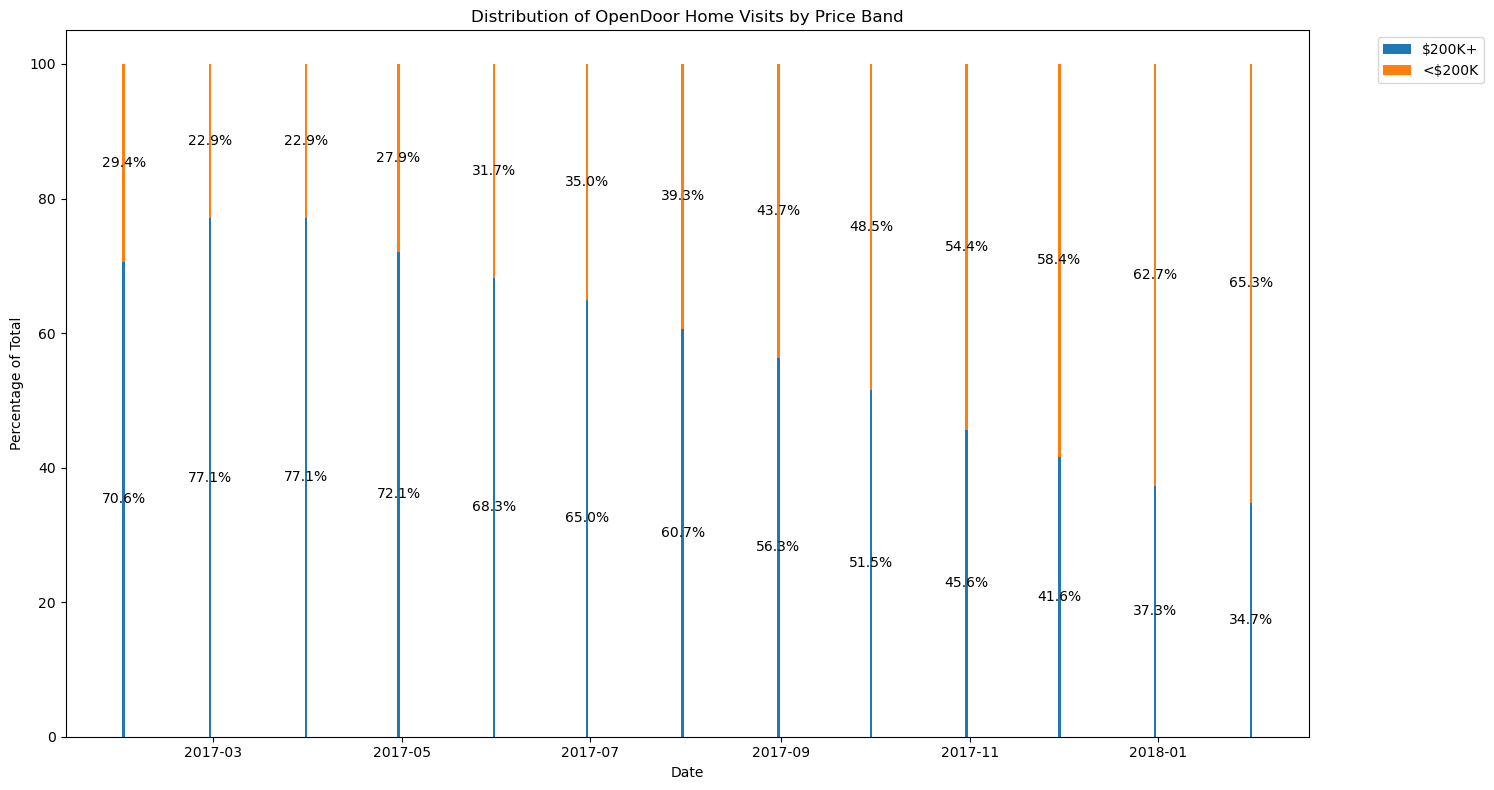

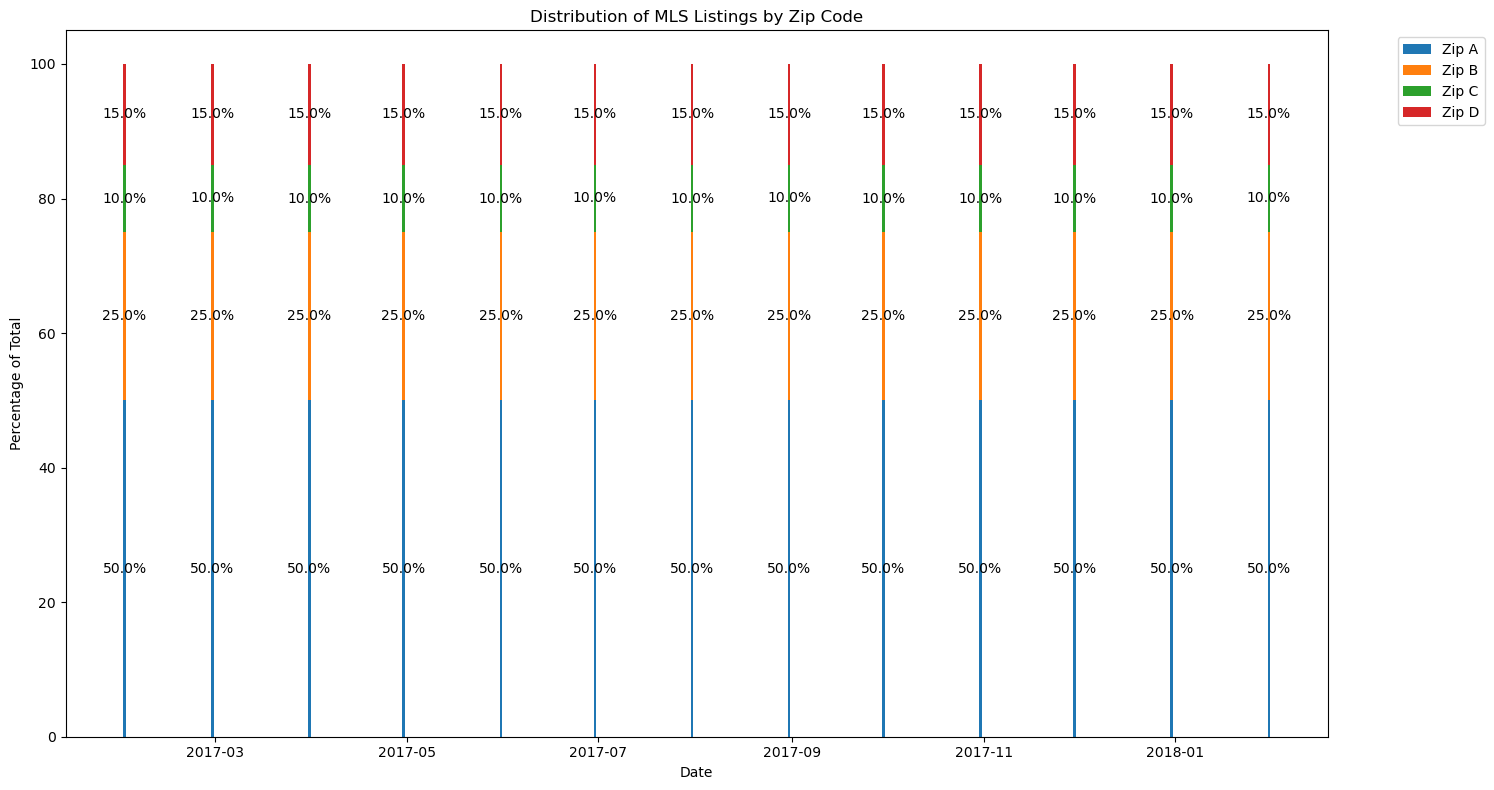

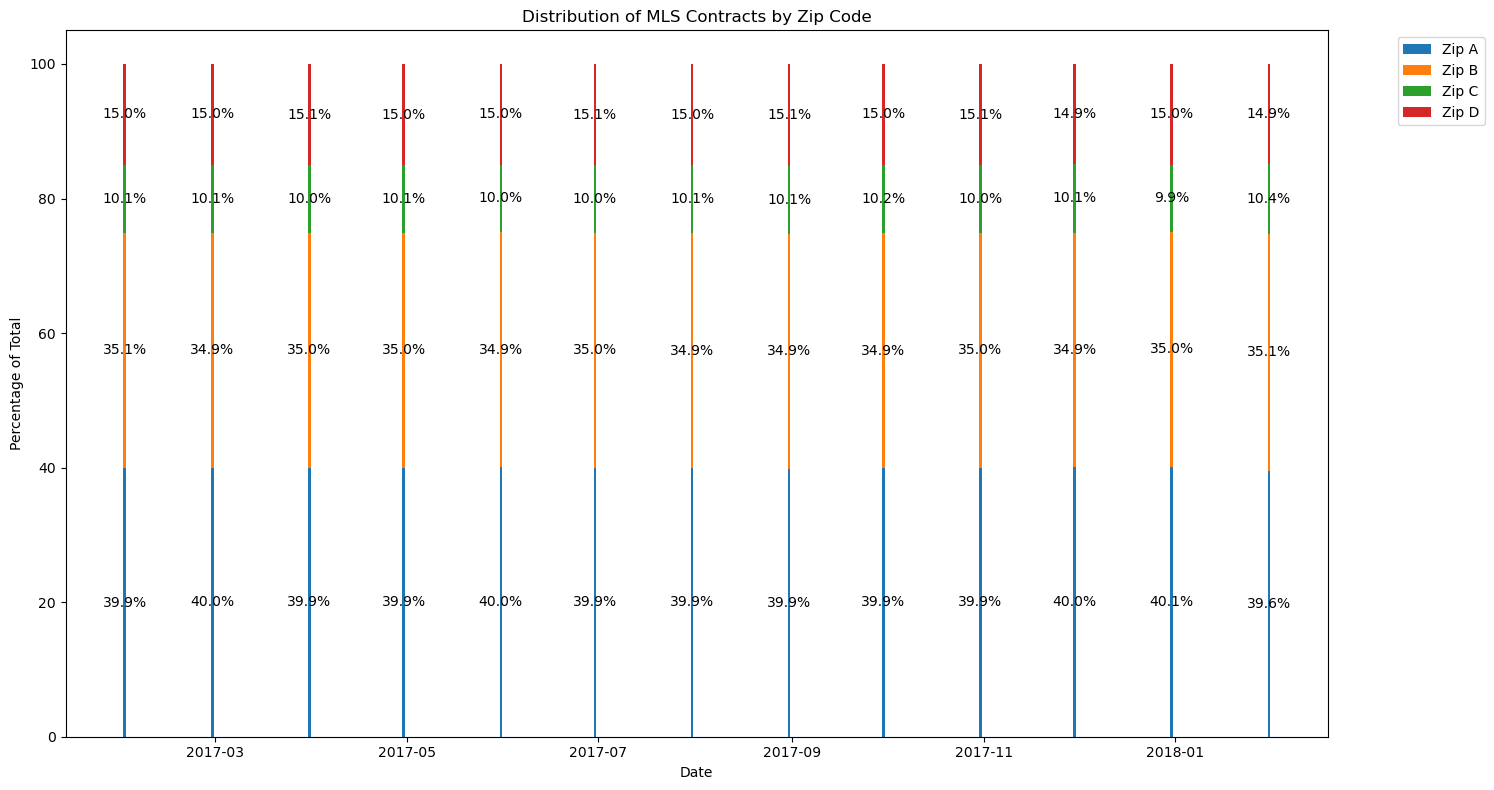

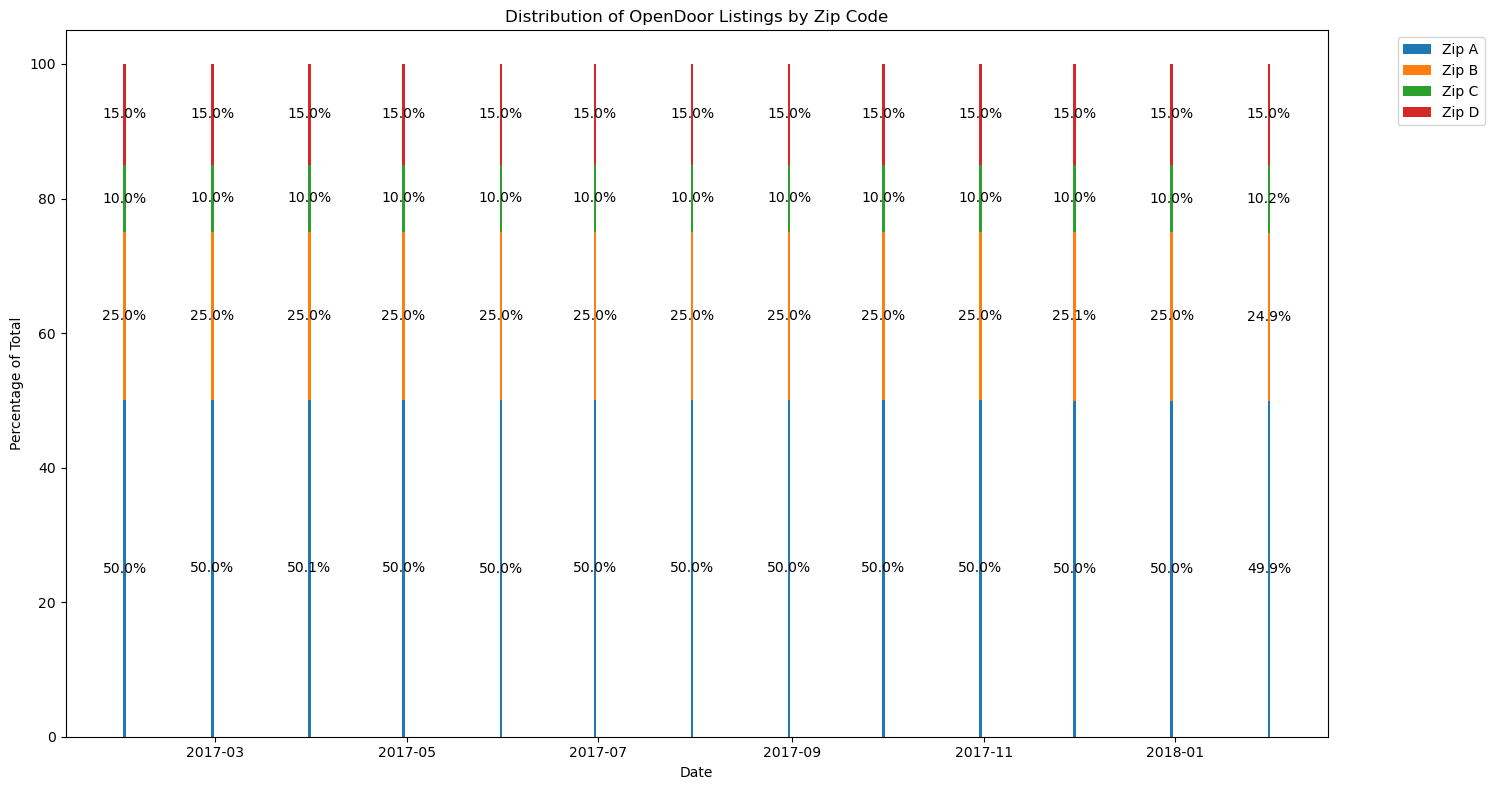

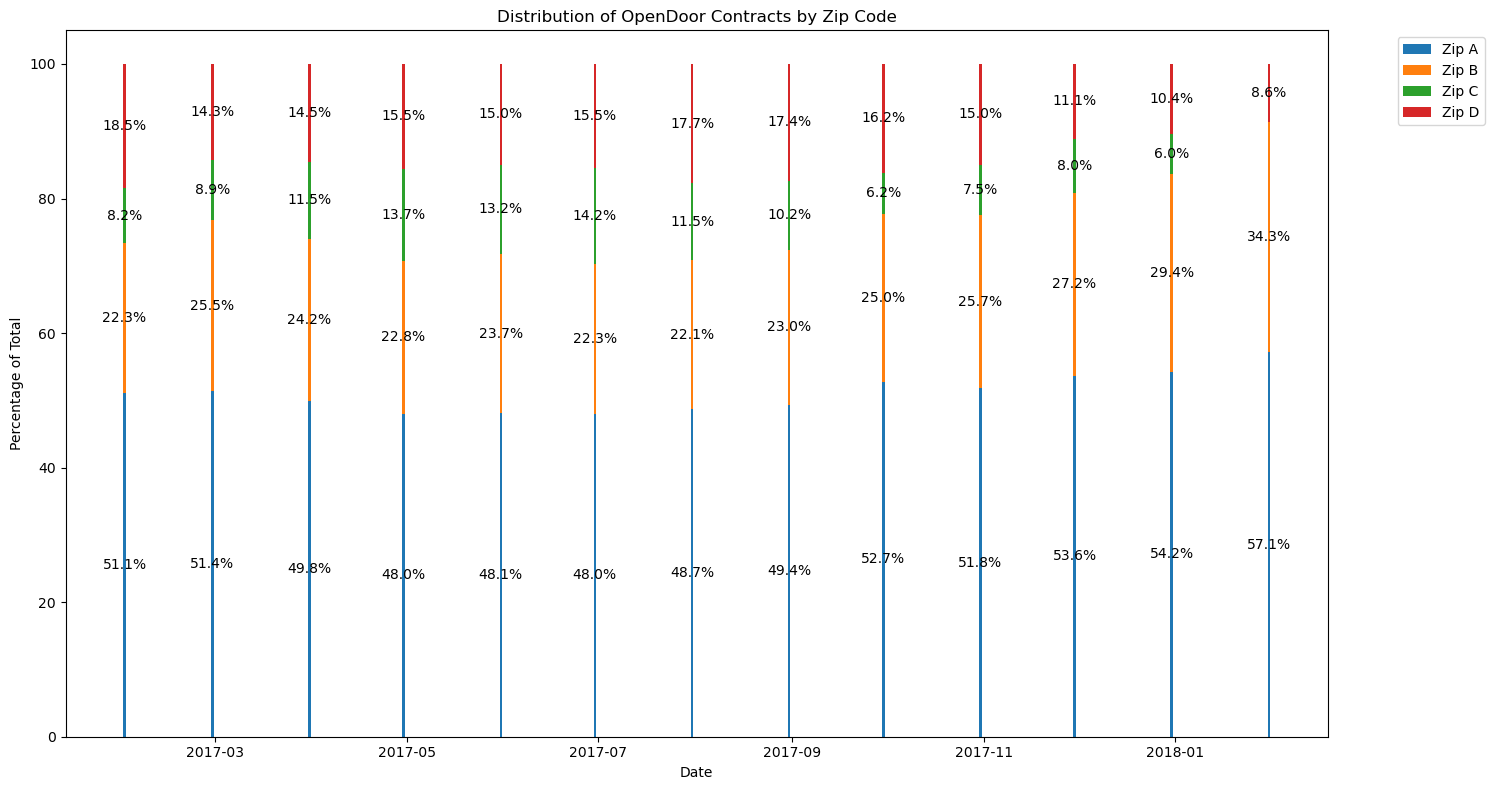

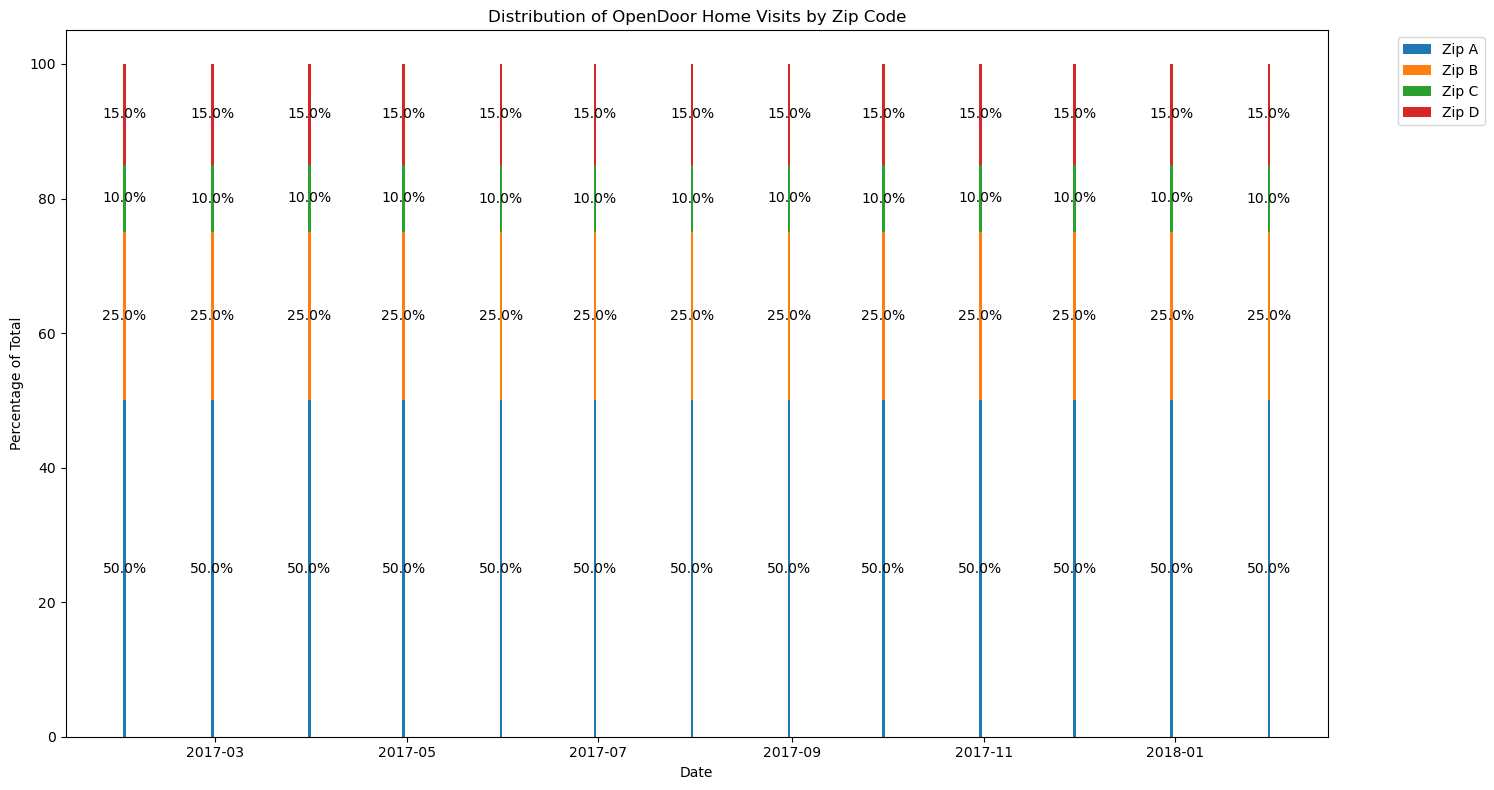

In [86]:
# Group by price_band and zip_code separately and calculate means
monthly_price_band = data.groupby([
    'price_band',
    pd.Grouper(key='date', freq='ME')
])[['mls_listings', 'mls_contracts', 'od_listings', 'od_contracts', 'od_home_visits']].mean().reset_index()

monthly_zip = data.groupby([
    'zip_code', 
    pd.Grouper(key='date', freq='ME')
])[['mls_listings', 'mls_contracts', 'od_listings', 'od_contracts', 'od_home_visits']].mean().reset_index()

# Calculate percentages for price bands
for col in ['mls_listings', 'mls_contracts', 'od_listings', 'od_contracts', 'od_home_visits']:
    monthly_price_band[col] = monthly_price_band[col] / monthly_price_band.groupby('date')[col].transform('sum') * 100
    monthly_zip[col] = monthly_zip[col] / monthly_zip.groupby('date')[col].transform('sum') * 100

# Define metrics to plot
metrics = ['mls_listings', 'mls_contracts', 'od_listings', 'od_contracts', 'od_home_visits']
metric_titles = {
    'mls_listings': 'MLS Listings',
    'mls_contracts': 'MLS Contracts', 
    'od_listings': 'OpenDoor Listings',
    'od_contracts': 'OpenDoor Contracts',
    'od_home_visits': 'OpenDoor Home Visits'
}

# Create plots for price bands
for metric in metrics:
    plt.figure(figsize=(15, 8))
    price_bands = monthly_price_band['price_band'].unique()
    bottom_vals = np.zeros(len(monthly_price_band['date'].unique()))
    
    for band in price_bands:
        band_data = monthly_price_band[monthly_price_band['price_band'] == band]
        bars = plt.bar(band_data['date'], band_data[metric],
                bottom=bottom_vals, label=band)
        bottom_vals += band_data[metric].values
        
        # Add percentage labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if height > 5:  #
                 Only show label if segment is >5% of total
                plt.text(bar.get_x() + bar.get_width()/2,
                        bottom_vals[i] - height/2,
                        f'{height:.1f}%',
                        ha='center', va='center')
    
    plt.title(f'Distribution of {metric_titles[metric]} by Price Band')
    plt.xlabel('Date')
    plt.ylabel('Percentage of Total')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Create plots for zip codes
for metric in metrics:
    plt.figure(figsize=(15, 8))
    zip_codes = monthly_zip['zip_code'].unique()
    bottom_vals = np.zeros(len(monthly_zip['date'].unique()))
    
    for zip_code in zip_codes:
        zip_data = monthly_zip[monthly_zip['zip_code'] == zip_code]
        bars = plt.bar(zip_data['date'], zip_data[metric],
                bottom=bottom_vals, label=f'Zip {zip_code}')
        bottom_vals += zip_data[metric].values
        
        # Add percentage labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if height > 5:  # Only show label if segment is >5% of total
                plt.text(bar.get_x() + bar.get_width()/2,
                        bottom_vals[i] - height/2,
                        f'{height:.1f}%',
                        ha='center', va='center')
    
    plt.title(f'Distribution of {metric_titles[metric]} by Zip Code')
    plt.xlabel('Date')
    plt.ylabel('Percentage of Total')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

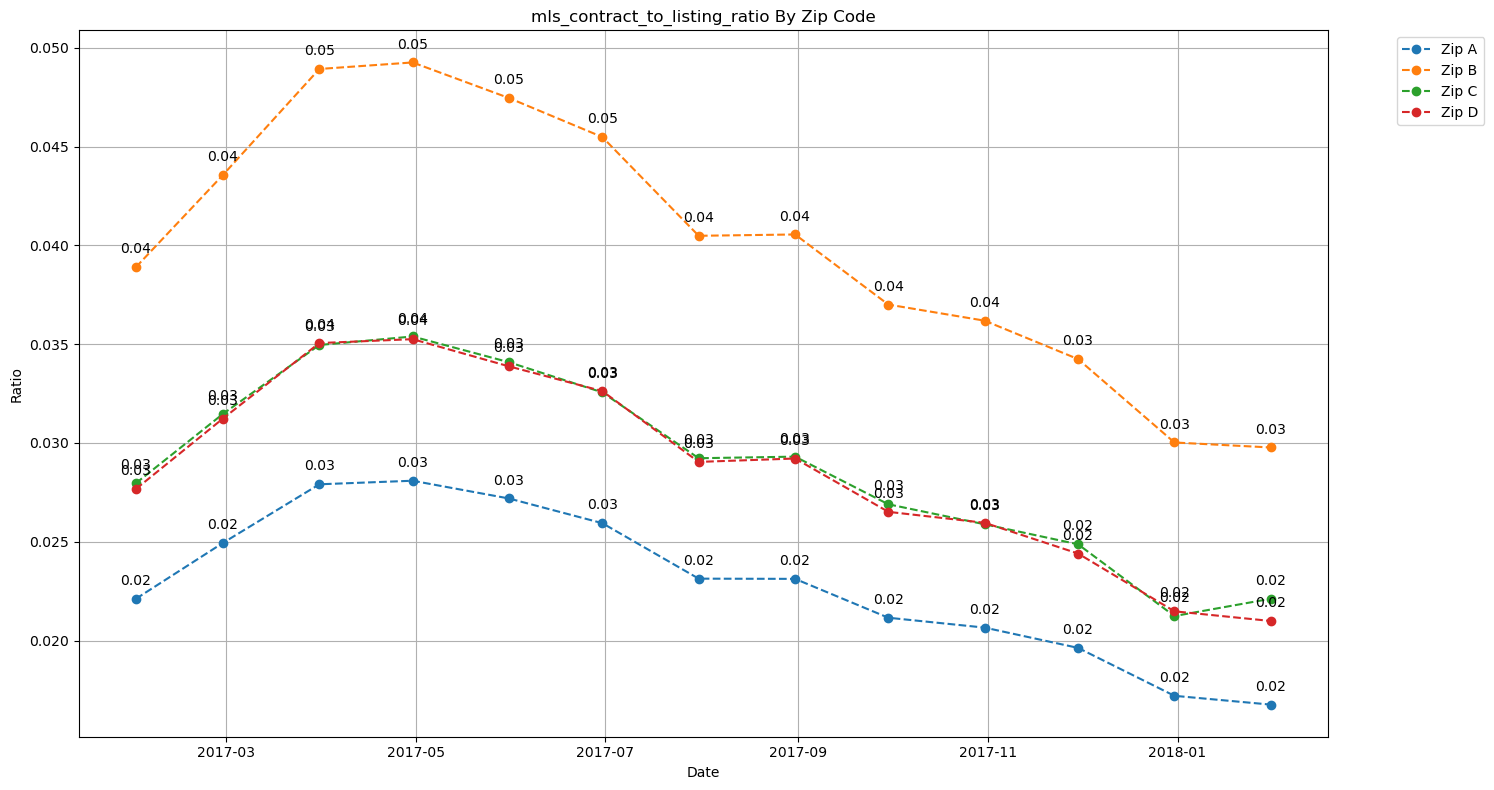

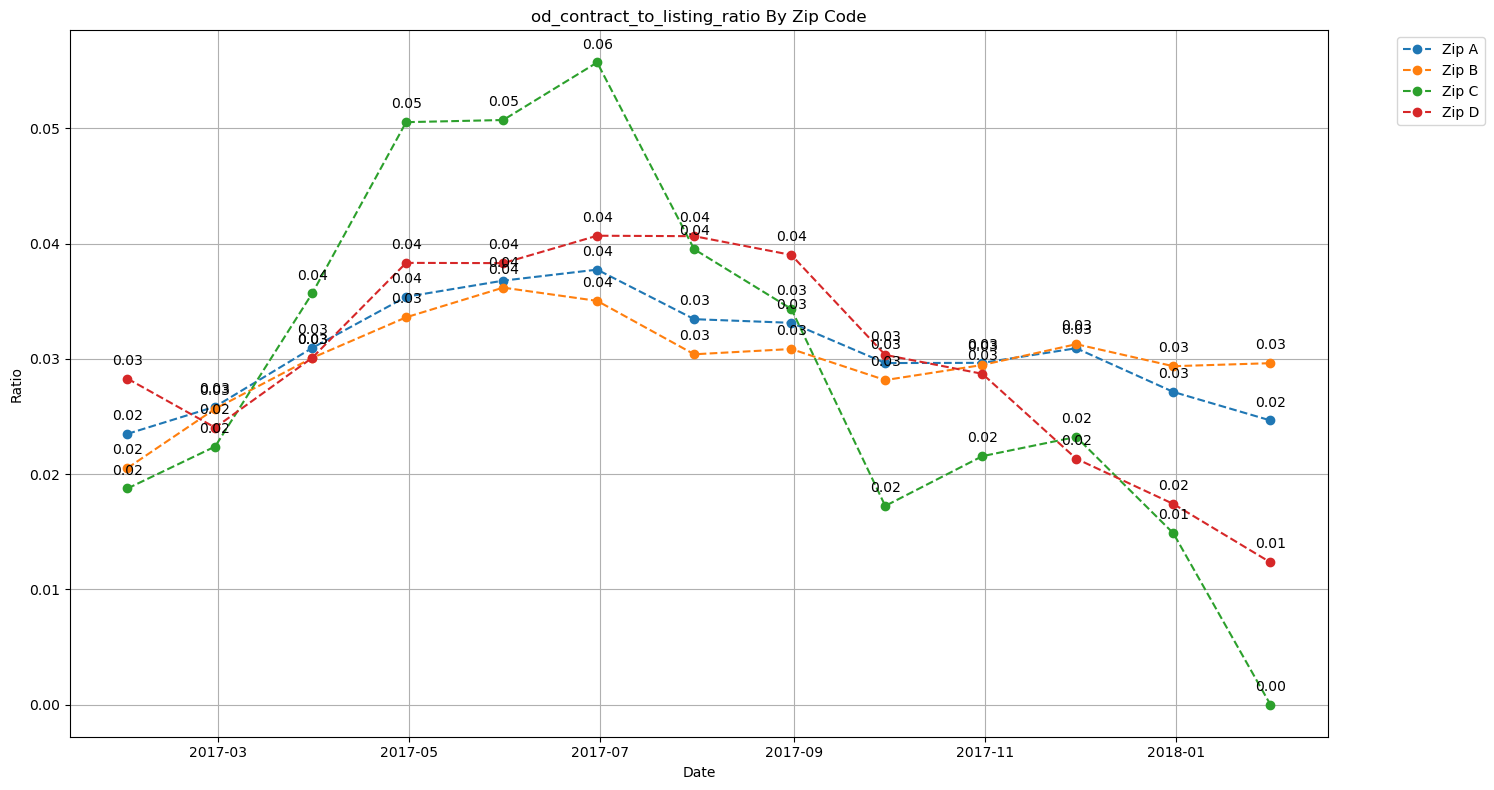

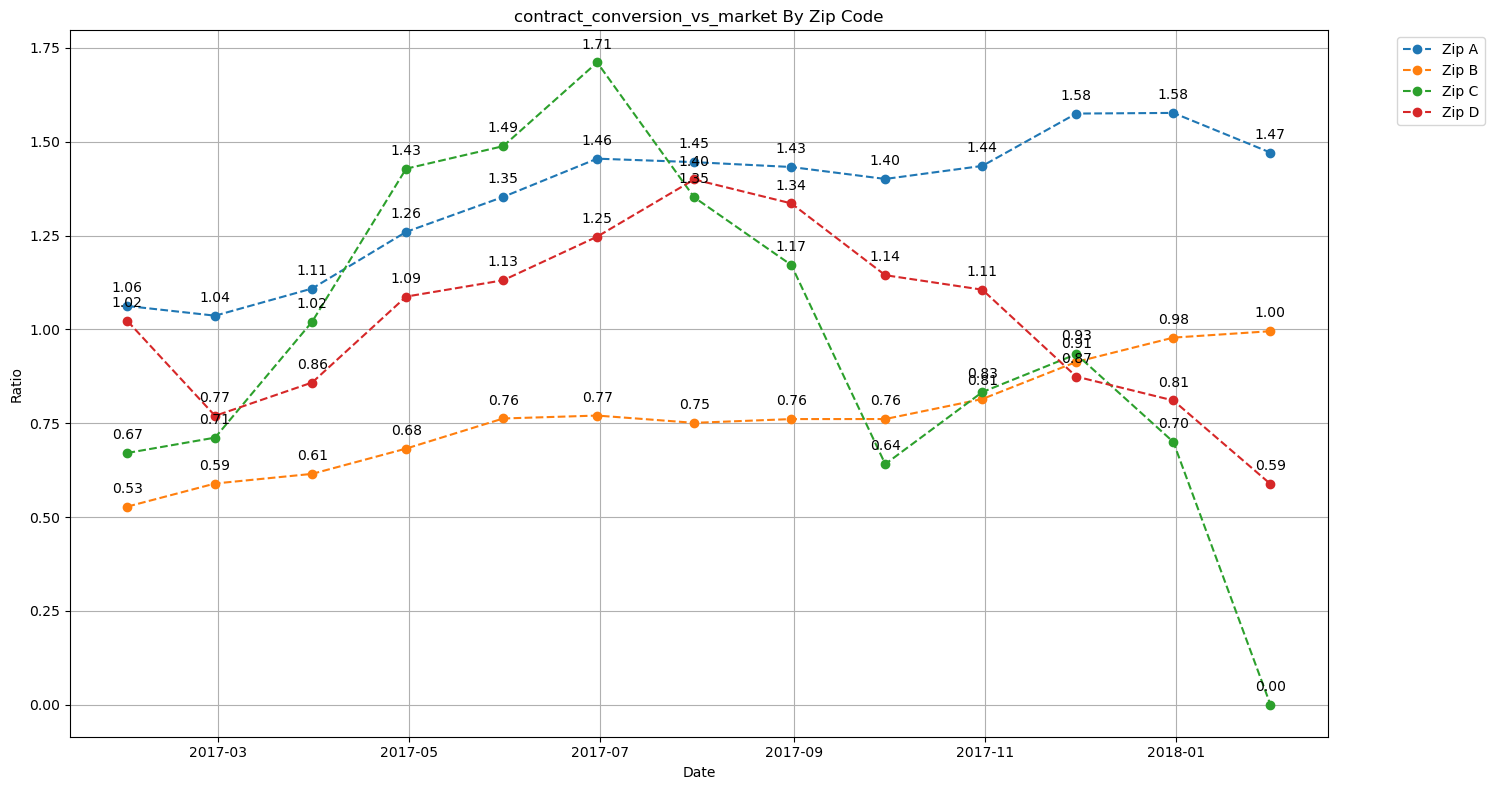

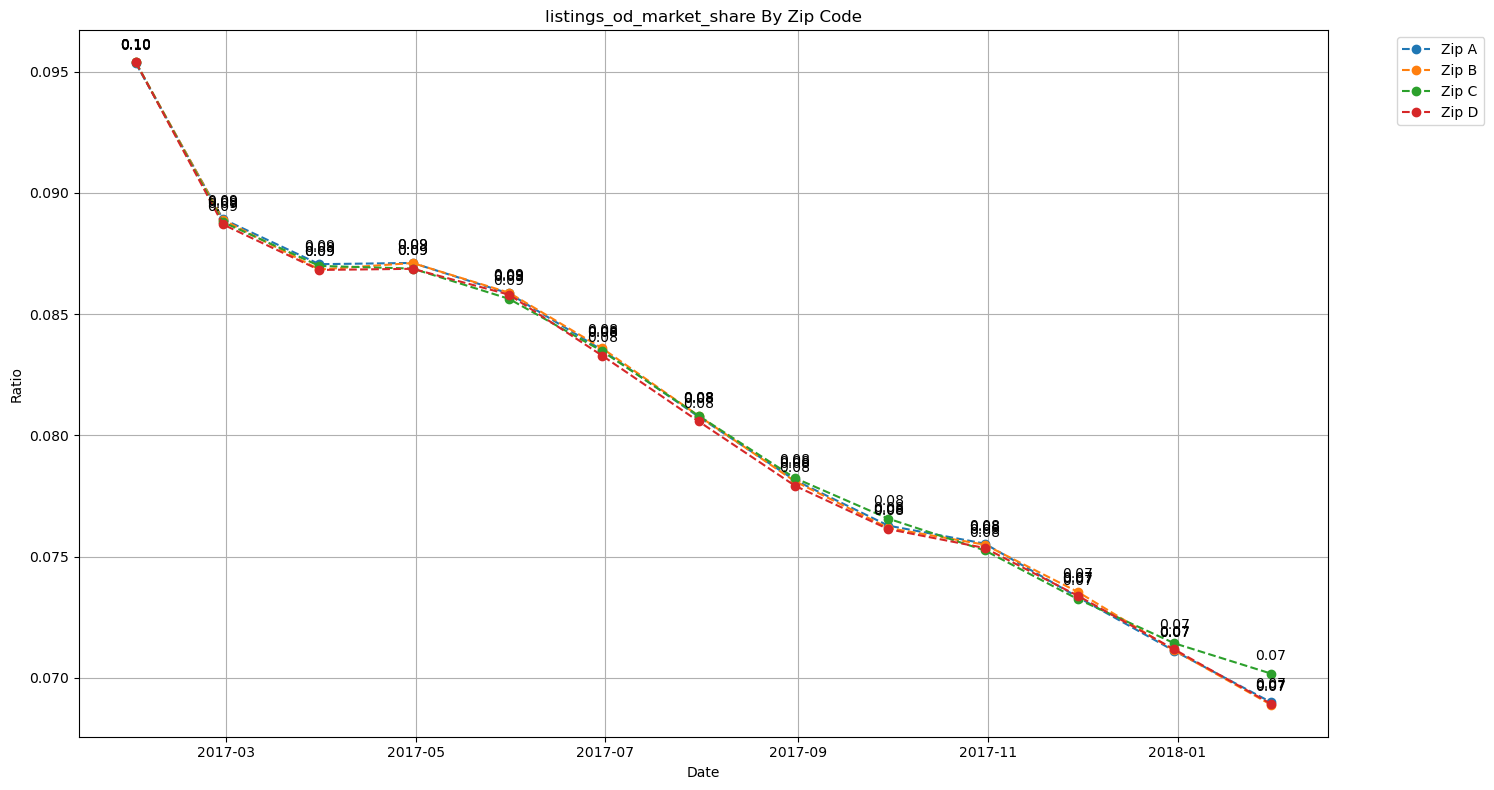

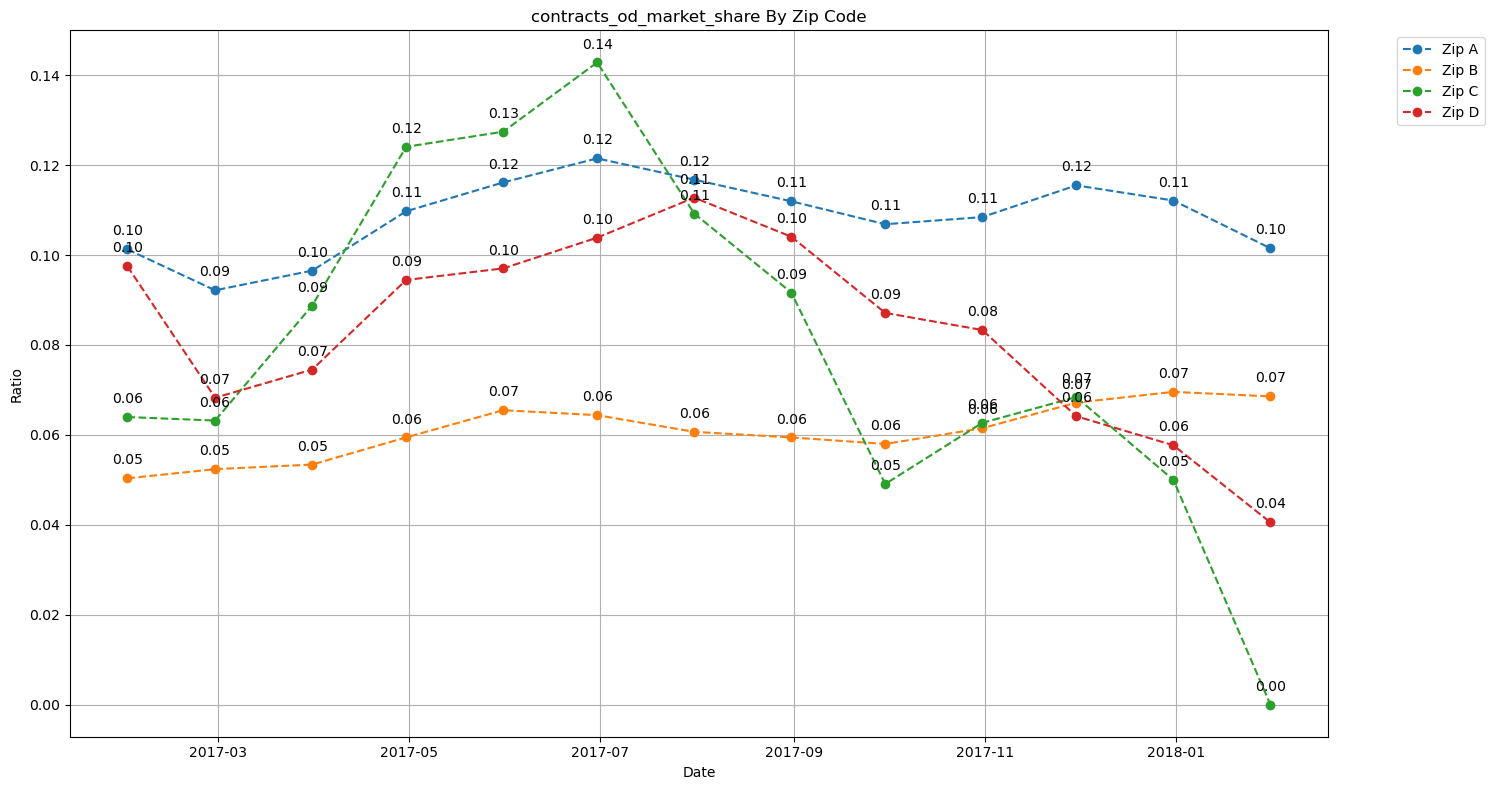

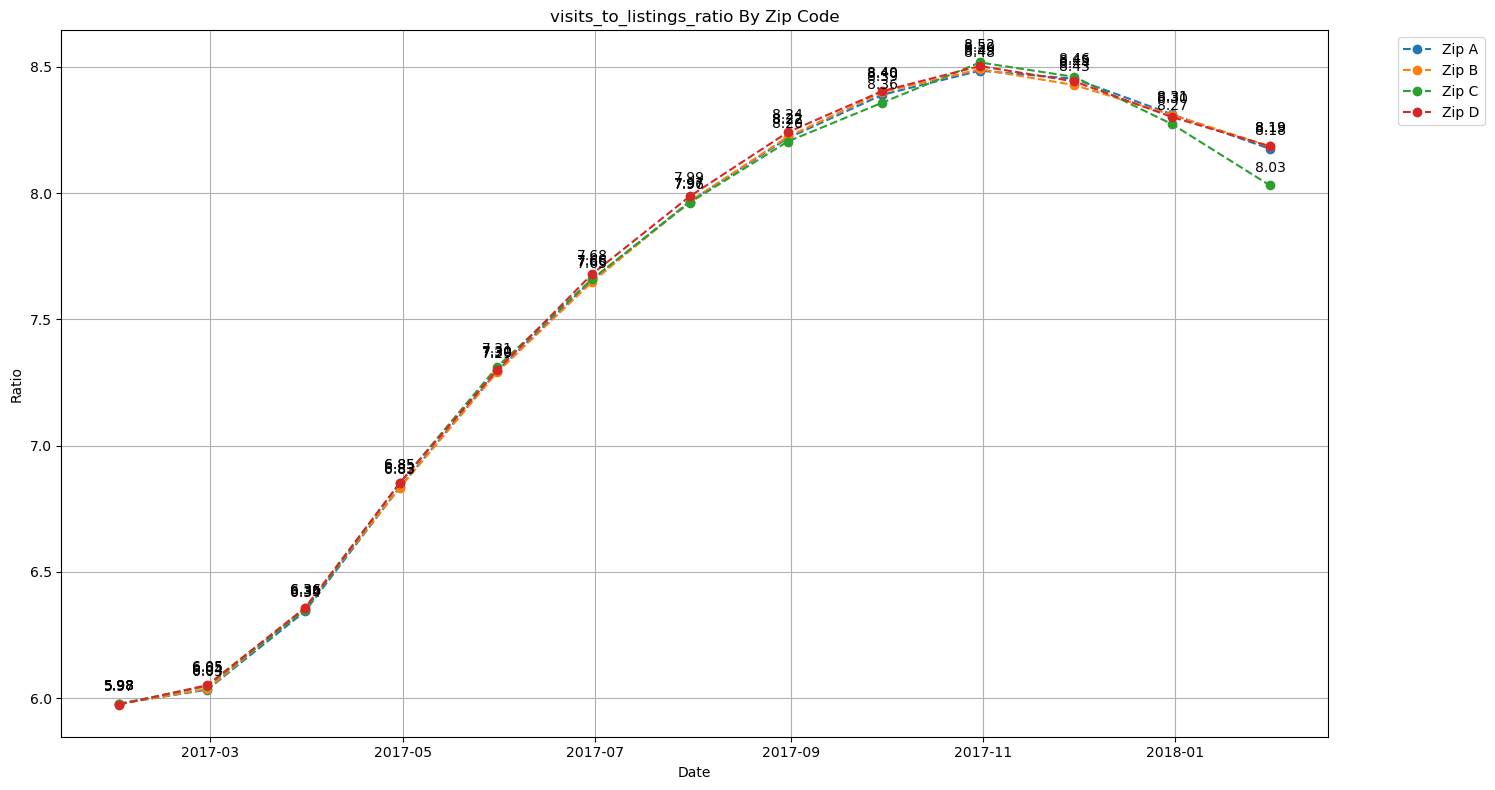

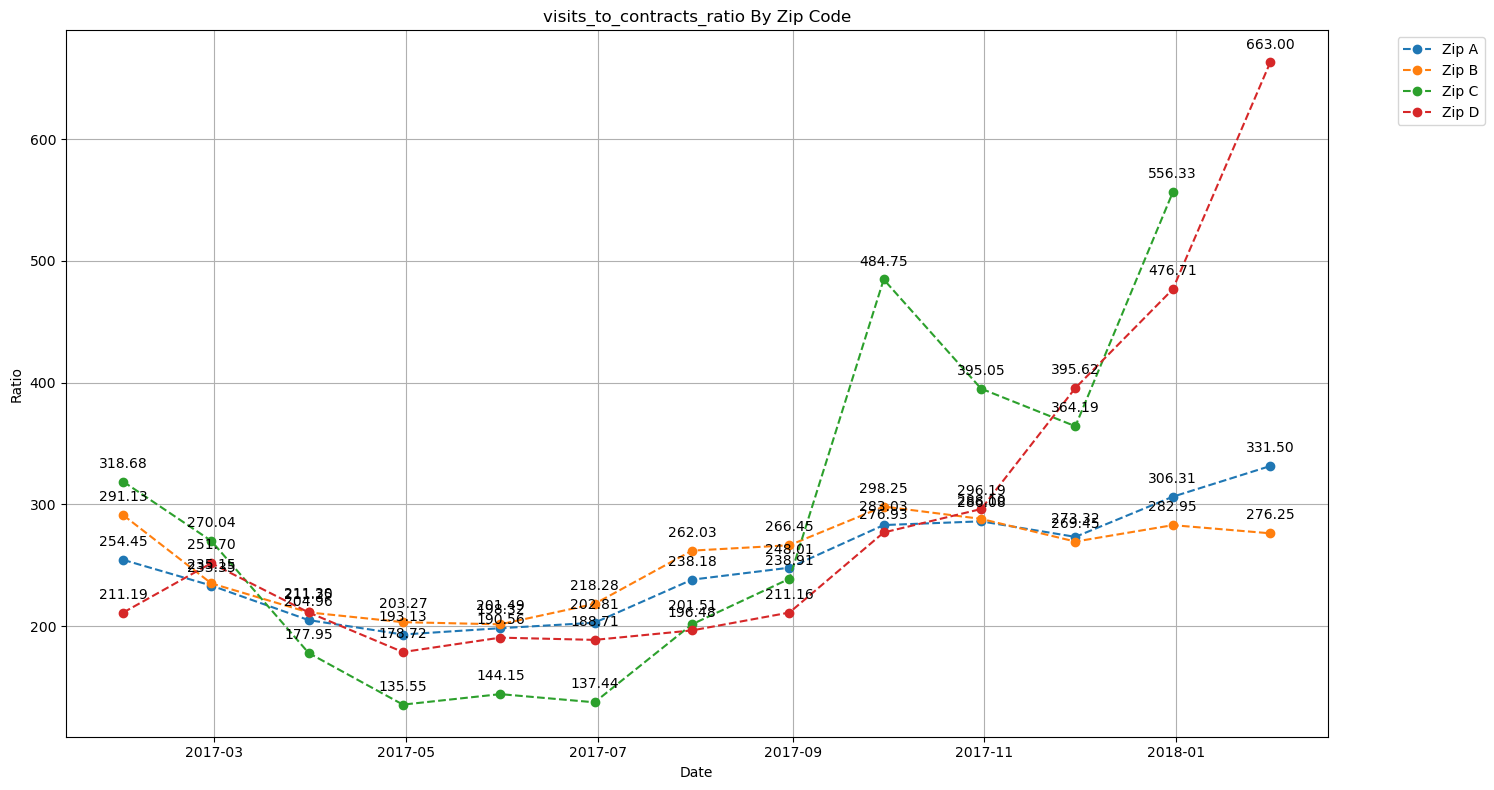

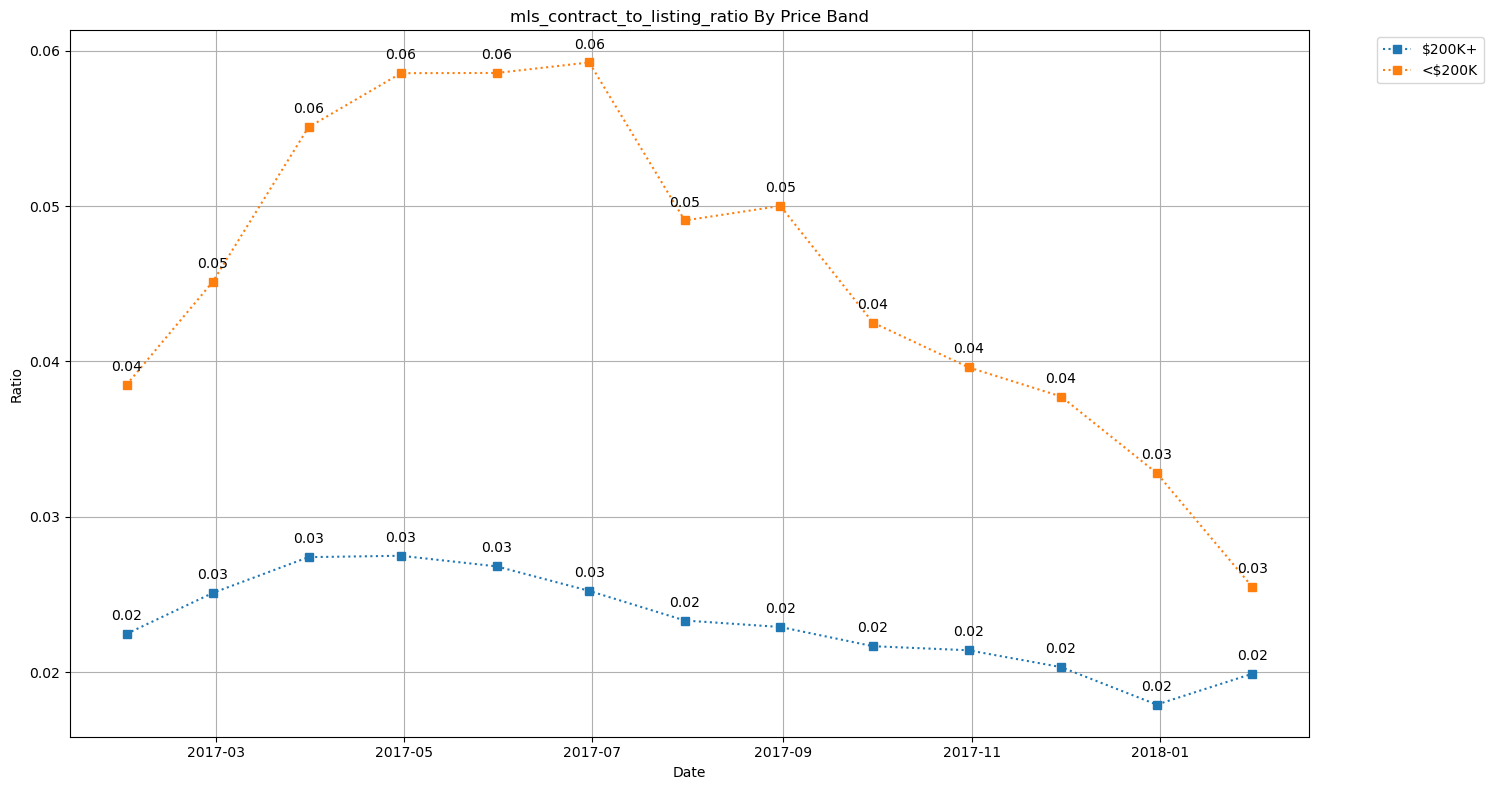

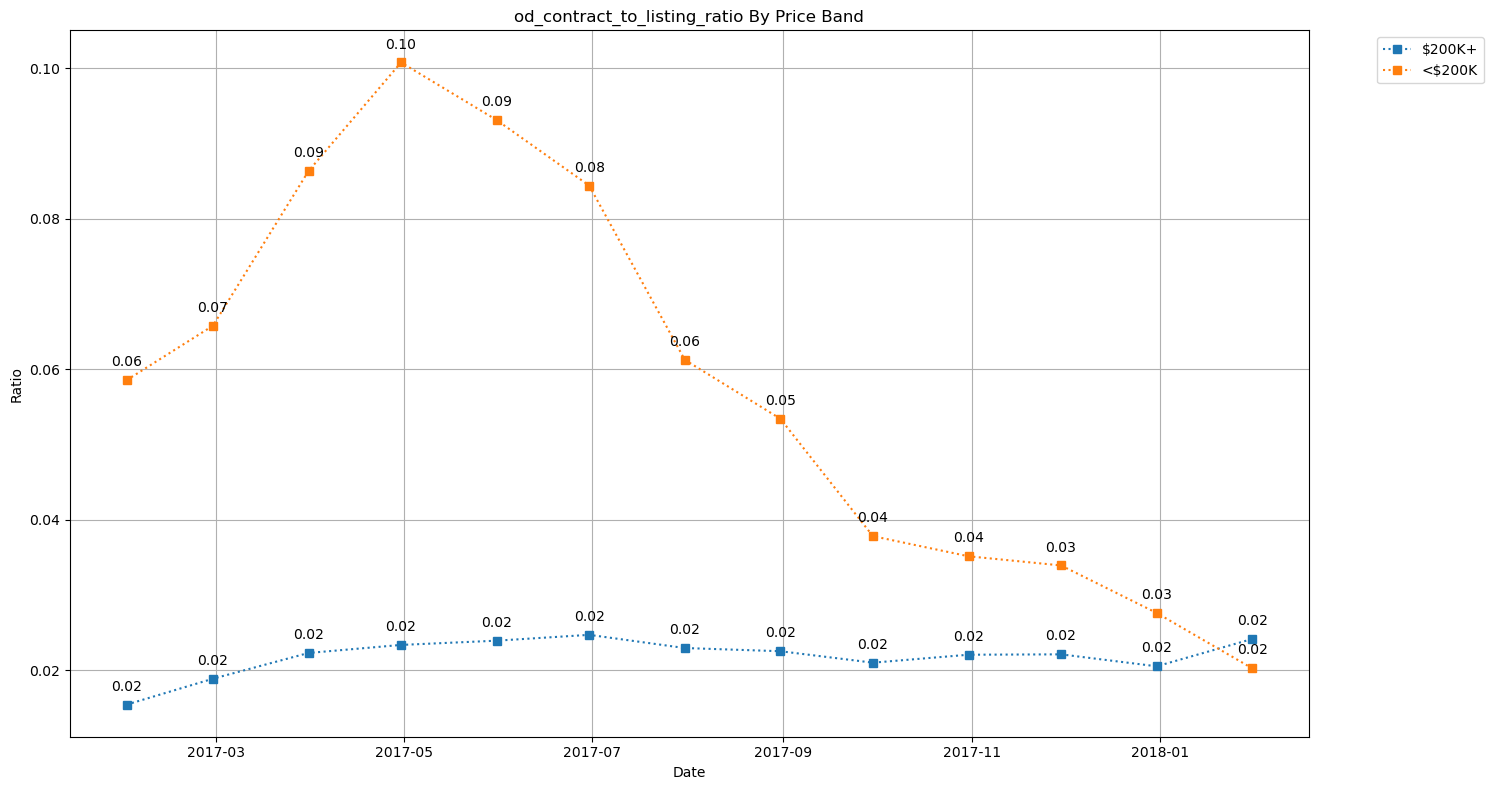

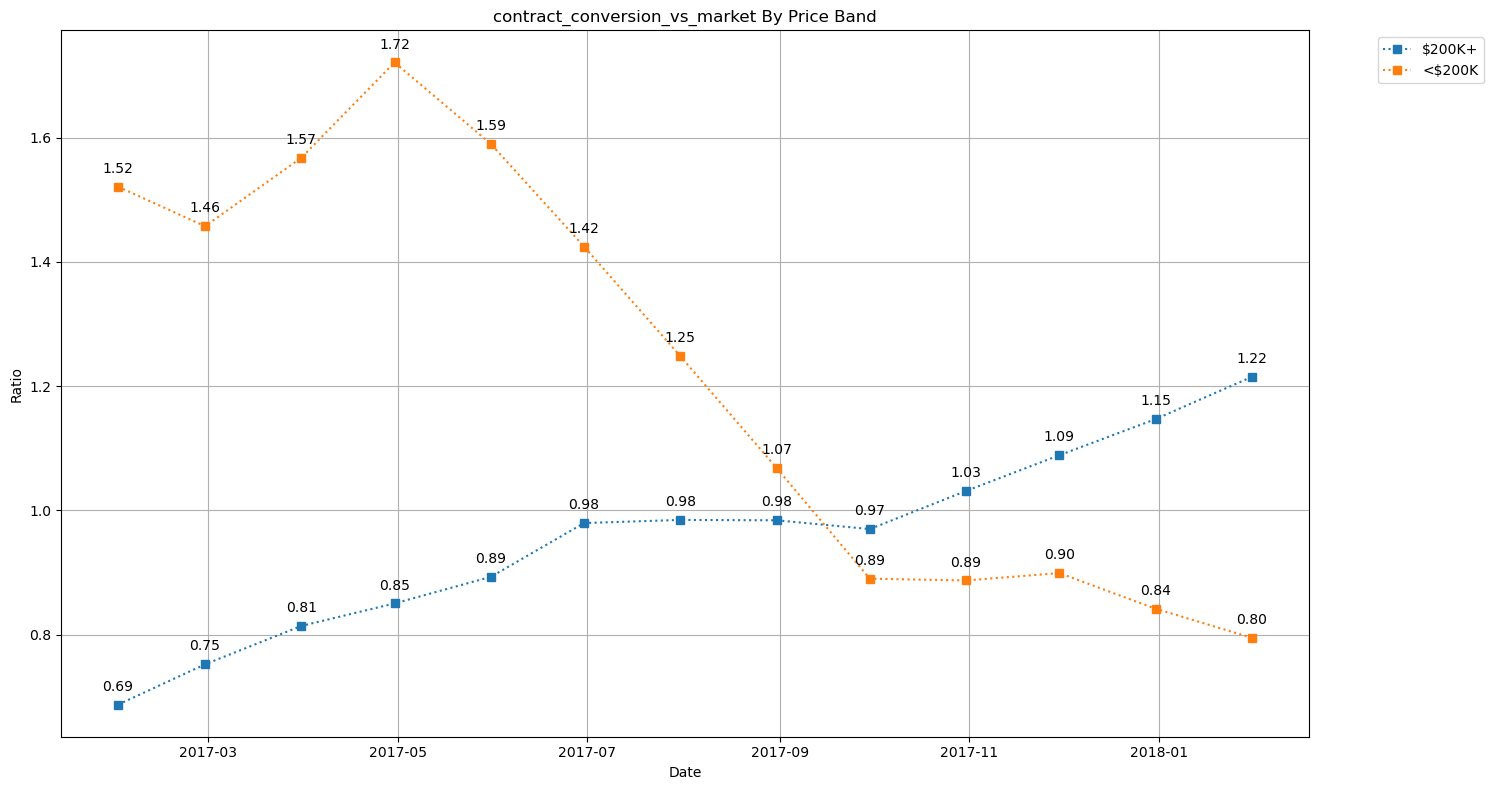

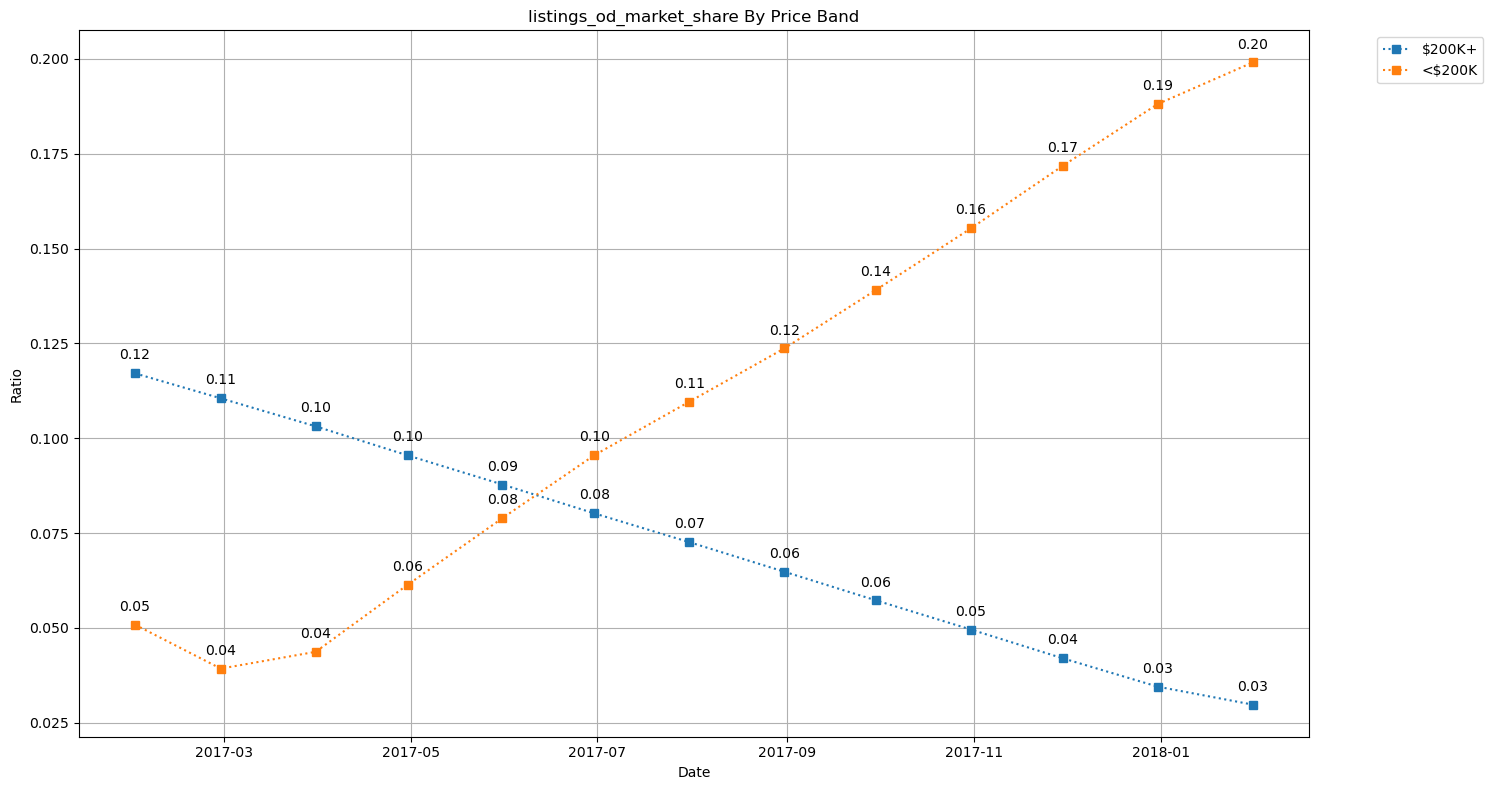

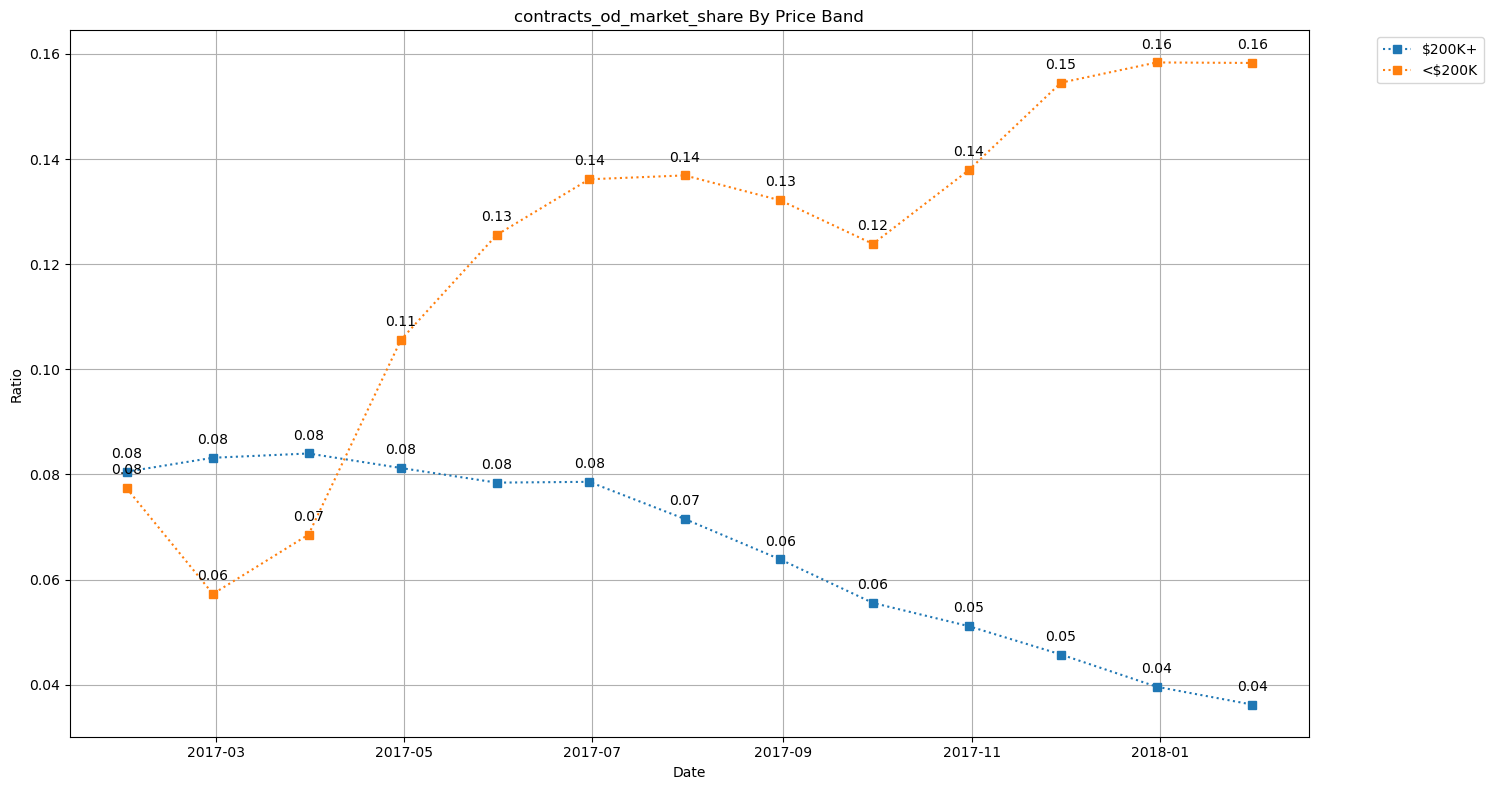

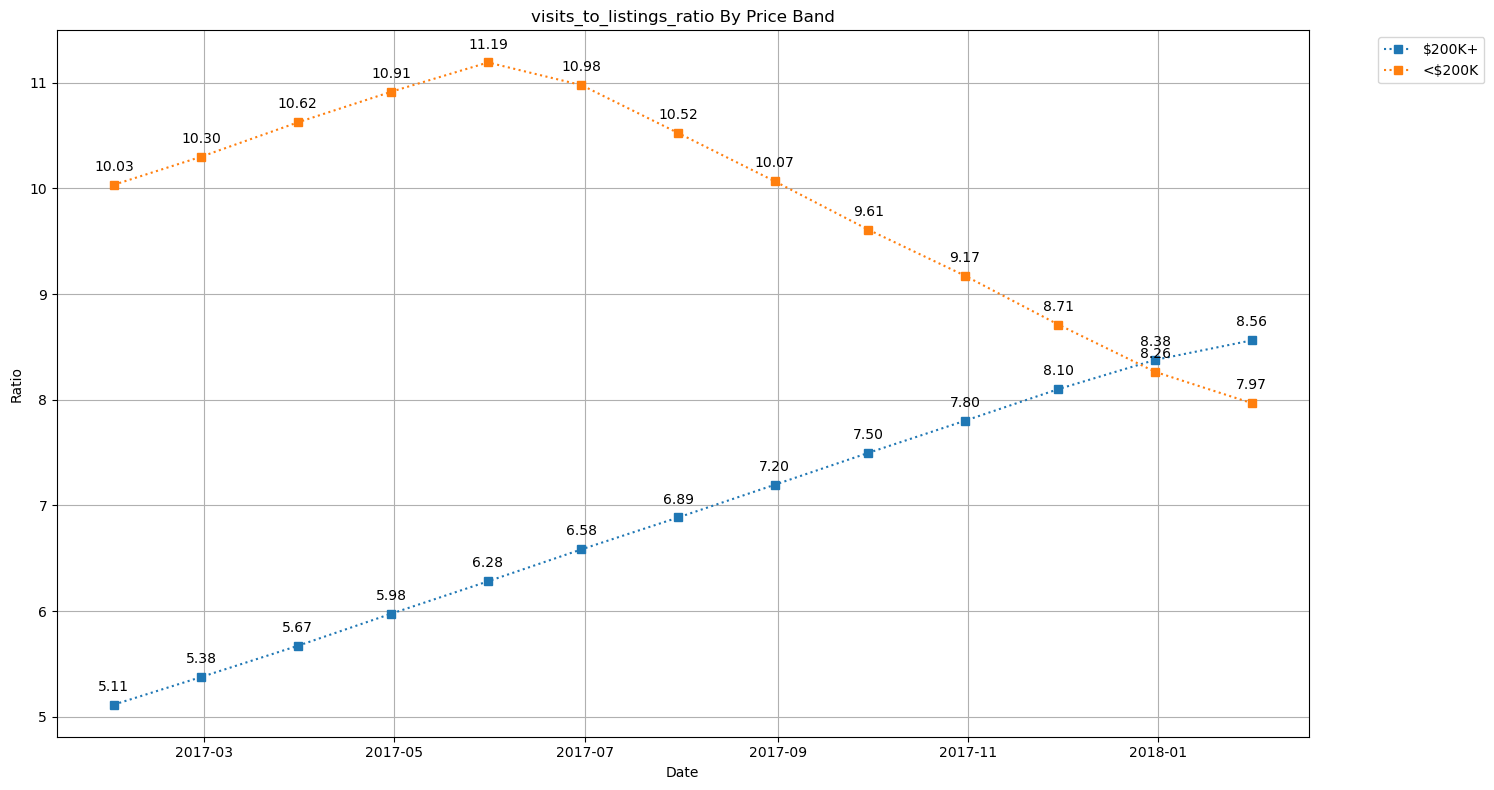

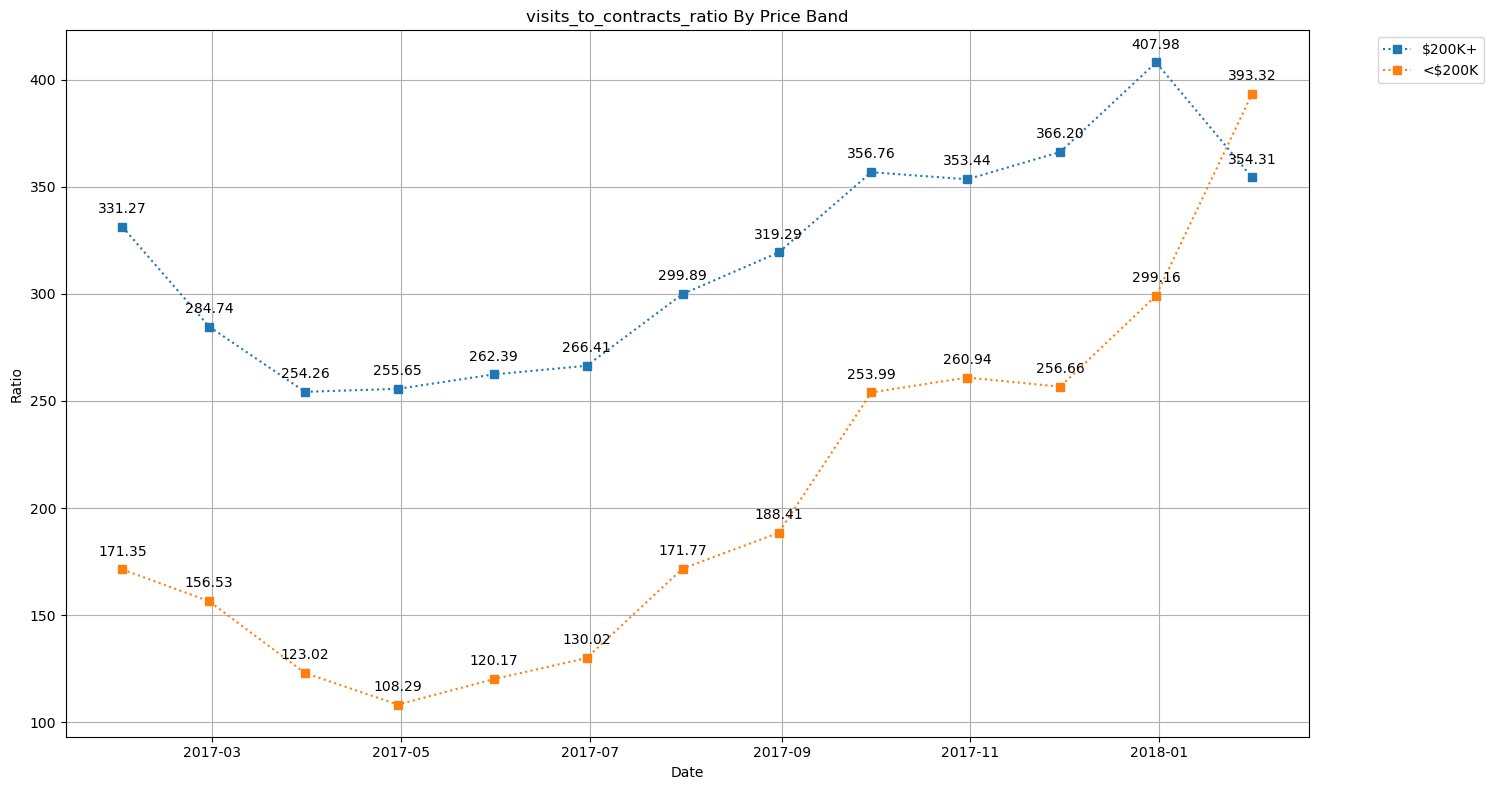

In [90]:
metrics_cols = [
    'mls_contract_to_listing_ratio', 
    'od_contract_to_listing_ratio',
    'contract_conversion_vs_market',
    'listings_od_market_share', 
    'contracts_od_market_share',
    'visits_to_listings_ratio',
    'visits_to_contracts_ratio'
]
# Analysis by Zip Code
metric_dfs = []

# Group by zip_code first, then resample each group by month and take mean
monthly_data_by_zip = (data.groupby(['zip_code'])[numeric_cols + ['date']]
                      .resample('ME', on='date')
                      .mean()
                      .reset_index())

# Calculate metrics for each zip code and store results
for zip_code in monthly_data_by_zip['zip_code'].unique():
    group = monthly_data_by_zip[monthly_data_by_zip['zip_code'] == zip_code].copy()  # Create copy
    group_metrics = calculate_performance_metrics(group)
    group_metrics.loc[:, 'zip_code'] = zip_code  # Use .loc for assignment
    metric_dfs.append(group_metrics)

# Combine all metrics into one dataframe
all_metrics_by_zip = pd.concat(metric_dfs)

# Plot each metric separately for zip codes
for metric in metrics_cols:
    plt.figure(figsize=(15, 8))
    
    for zip_code in all_metrics_by_zip['zip_code'].unique():
        zip_data = all_metrics_by_zip[all_metrics_by_zip['zip_code'] == zip_code]
        line = plt.plot(zip_data['date'], zip_data[metric], 
                label=f"Zip {zip_code}", marker='o', linestyle='--')[0]
        
        # Add value labels on each point
        for x, y in zip(zip_data['date'], zip_data[metric]):
            plt.annotate(f'{y:.2f}', 
                        (x, y),
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center')
    
    plt.title(f'{metric} By Zip Code')
    plt.xlabel('Date')
    plt.ylabel('Ratio')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#==============================================================================

# Analysis by Price Band
metric_dfs = []

# Group by price_band first, then resample each group by month and take mean  
monthly_data_by_price = (data.groupby(['price_band'])[numeric_cols + ['date']]
                        .resample('ME', on='date')
                        .mean()
                        .reset_index())

# Calculate metrics for each price band and store results
for price_band in monthly_data_by_price['price_band'].unique():
    group = monthly_data_by_price[monthly_data_by_price['price_band'] == price_band].copy()  # Create copy
    group_metrics = calculate_performance_metrics(group)
    group_metrics.loc[:, 'price_band'] = price_band  # Use .loc for assignment
    metric_dfs.append(group_metrics)

# Combine all metrics into one dataframe
all_metrics_by_price = pd.concat(metric_dfs)

# Plot each metric separately for price bands
for metric in metrics_cols:
    plt.figure(figsize=(15, 8))
    
    for price_band in all_metrics_by_price['price_band'].unique():
        price_data = all_metrics_by_price[all_metrics_by_price['price_band'] == price_band]
        line = plt.plot(price_data['date'], price_data[metric],
                label=f"{price_band}", marker='s', linestyle=':')[0]
        
        # Add value labels on each point
        for x, y in zip(price_data['date'], price_data[metric]):
            plt.annotate(f'{y:.2f}',
                        (x, y), 
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center')
    
    plt.title(f'{metric} By Price Band')
    plt.xlabel('Date')
    plt.ylabel('Ratio')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

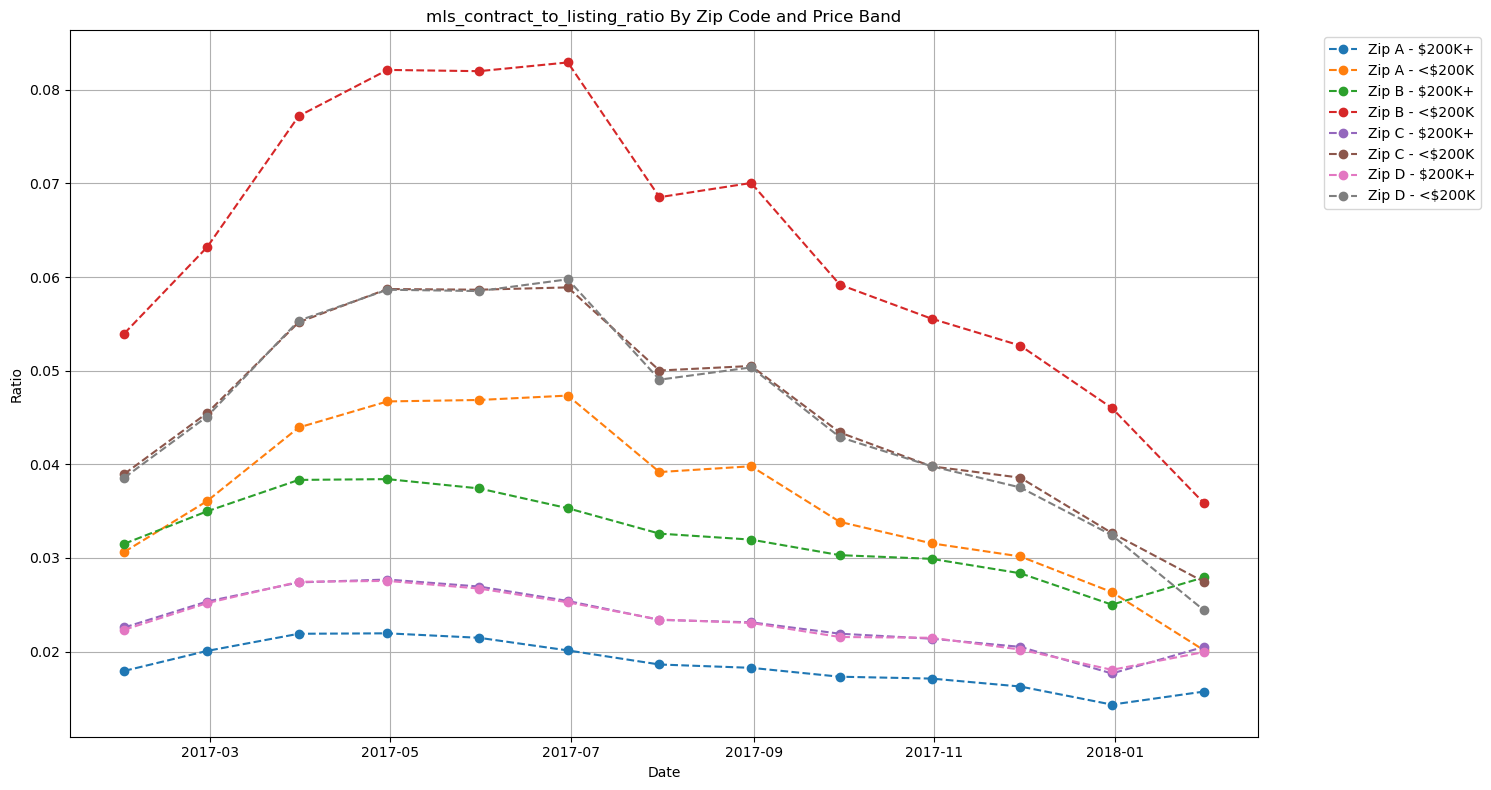

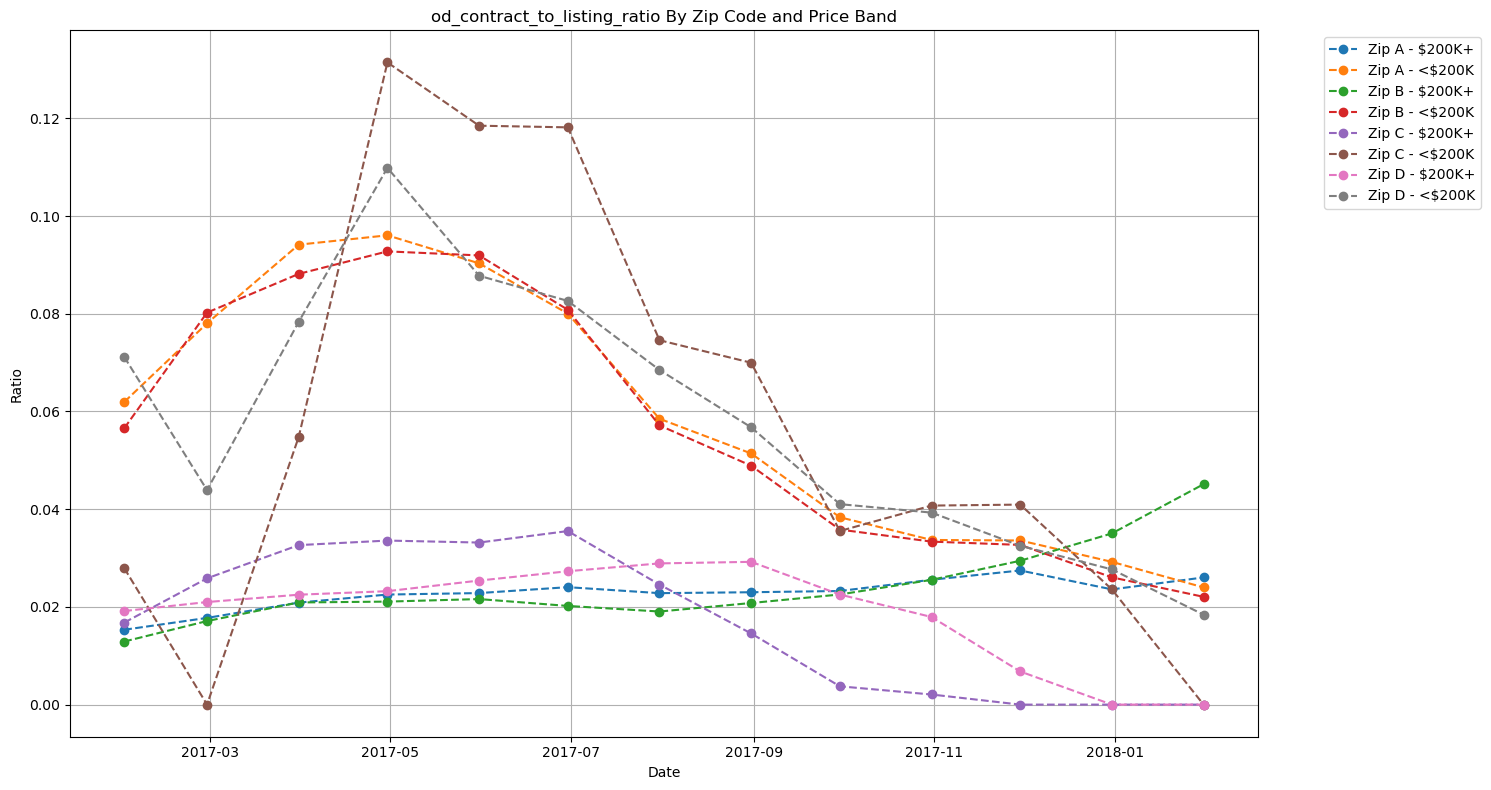

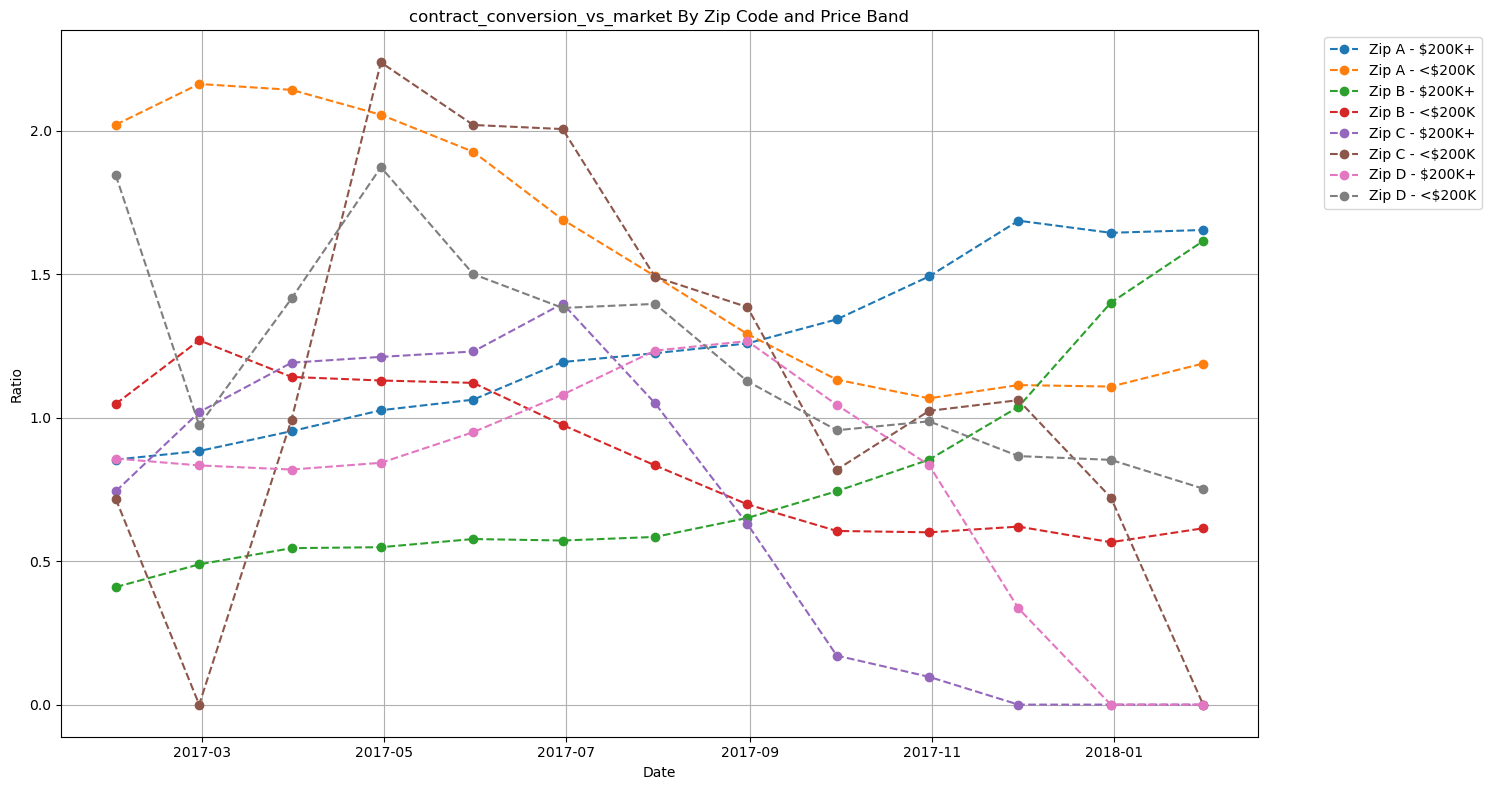

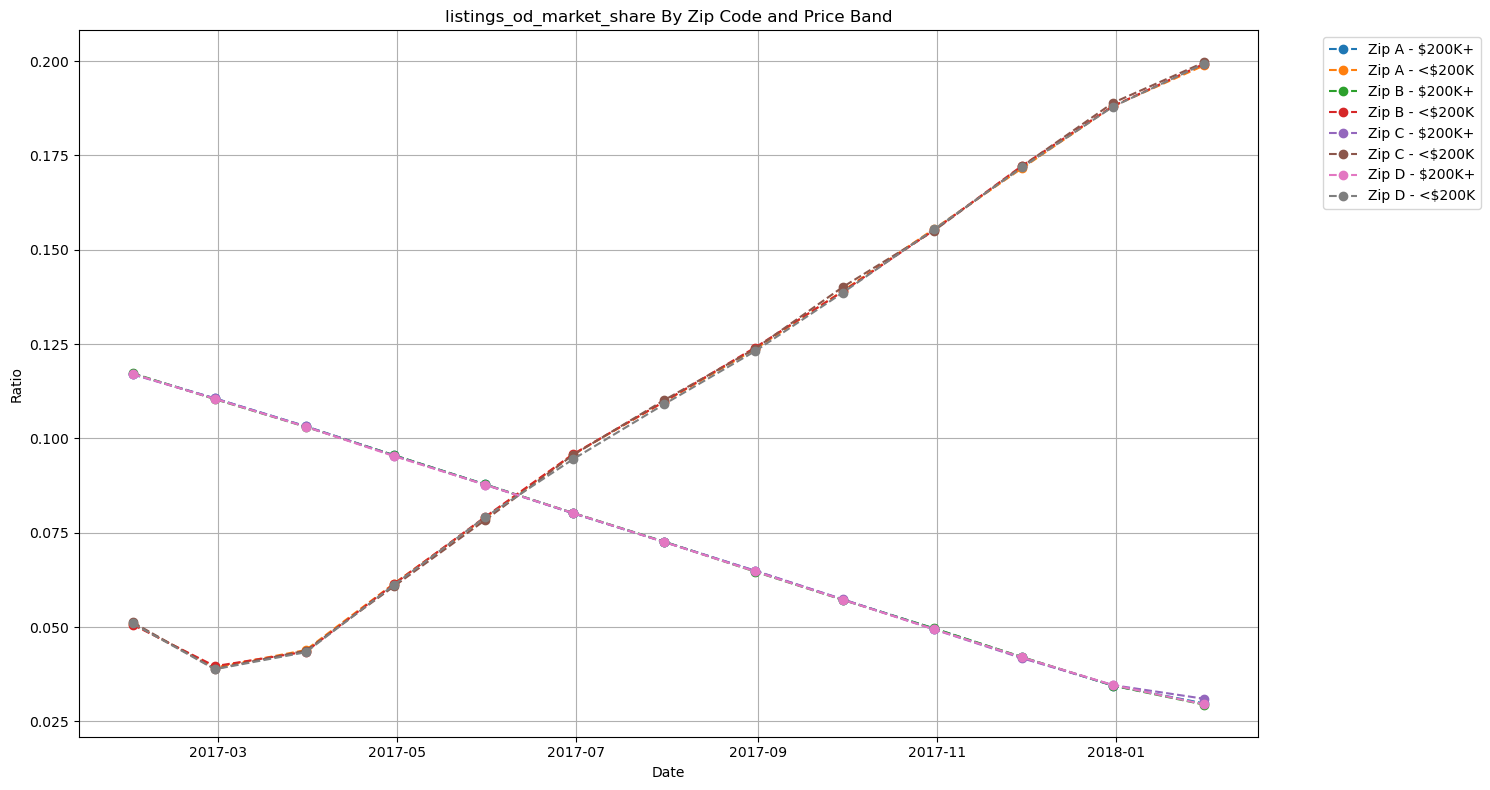

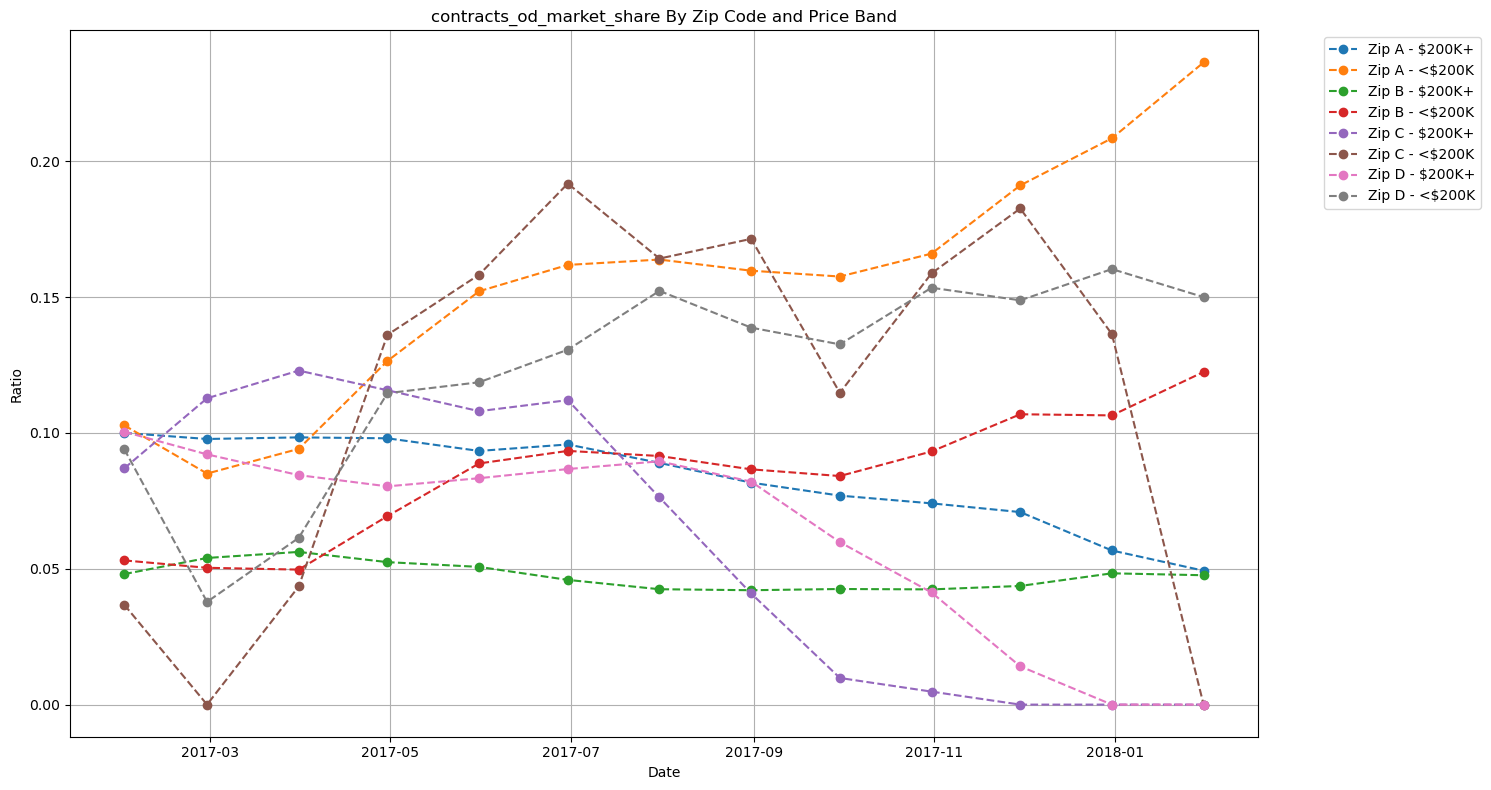

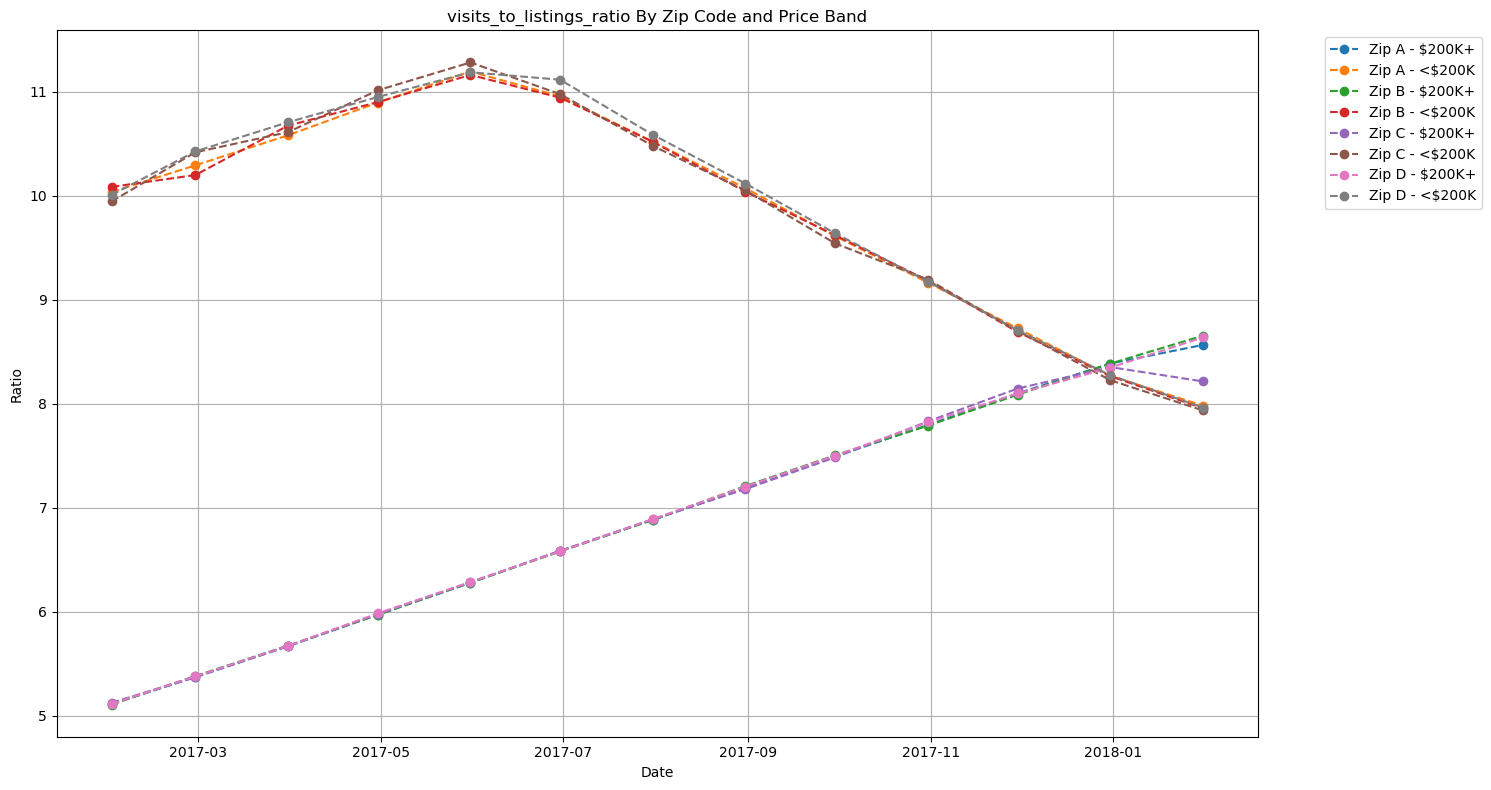

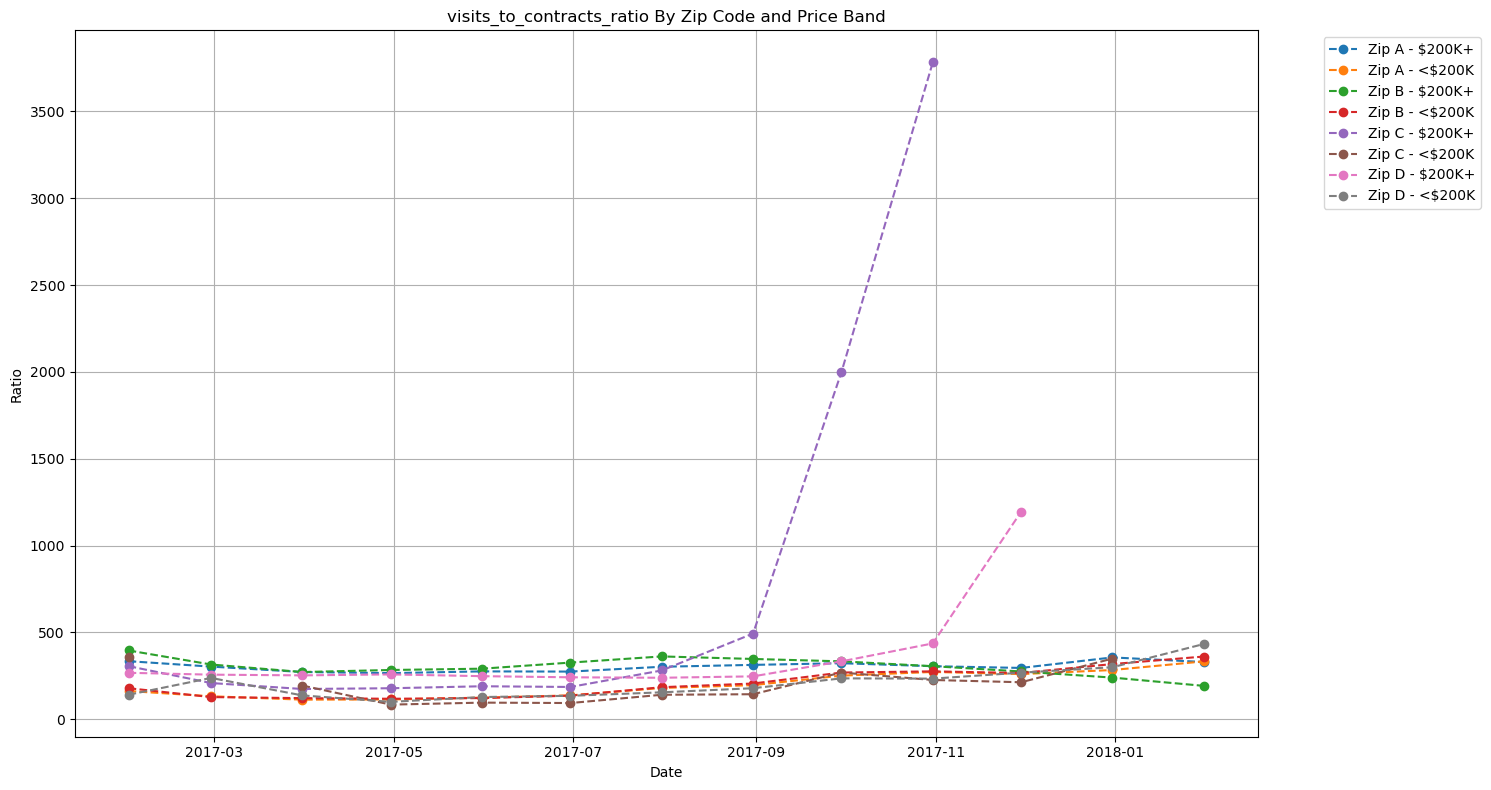

In [89]:
# Analyze the cross sections
metrics_cols = [
    'mls_contract_to_listing_ratio', 
    'od_contract_to_listing_ratio',
    'contract_conversion_vs_market',
    'listings_od_market_share', 
    'contracts_od_market_share',
    'visits_to_listings_ratio',
    'visits_to_contracts_ratio'
]

# Analysis by Zip Code and Price Band combined
metric_dfs = []

# Group by both zip_code and price_band, then resample each group by month and take mean
monthly_data_by_zip_price = (data.groupby(['zip_code', 'price_band'])[numeric_cols + ['date']]
                           .resample('ME', on='date')
                           .mean()
                           .reset_index())

# Calculate metrics for each zip code + price band combination and store results
for zip_code in monthly_data_by_zip_price['zip_code'].unique():
    for price_band in monthly_data_by_zip_price['price_band'].unique():
        group = monthly_data_by_zip_price[
            (monthly_data_by_zip_price['zip_code'] == zip_code) & 
            (monthly_data_by_zip_price['price_band'] == price_band)
        ].copy()
        
        if len(group) > 0:  # Only process if combination exists
            group_metrics = calculate_performance_metrics(group)
            group_metrics.loc[:, 'zip_code'] = zip_code
            group_metrics.loc[:, 'price_band'] = price_band
            metric_dfs.append(group_metrics)

# Combine all metrics into one dataframe
all_metrics_by_zip_price = pd.concat(metric_dfs)

# Plot each metric separately for zip code + price band combinations
for metric in metrics_cols:
    plt.figure(figsize=(15, 8))
    
    for zip_code in all_metrics_by_zip_price['zip_code'].unique():
        for price_band in all_metrics_by_zip_price['price_band'].unique():
            segment_data = all_metrics_by_zip_price[
                (all_metrics_by_zip_price['zip_code'] == zip_code) & 
                (all_metrics_by_zip_price['price_band'] == price_band)
            ]
            if len(segment_data) > 0:  # Only plot if combination exists
                plt.plot(segment_data['date'], segment_data[metric], 
                        label=f"Zip {zip_code} - {price_band}", 
                        marker='o', linestyle='--')
    
    plt.title(f'{metric} By Zip Code and Price Band')
    plt.xlabel('Date')
    plt.ylabel('Ratio')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



ANALYZING ZIP CODE A - PRICE BAND $200K+



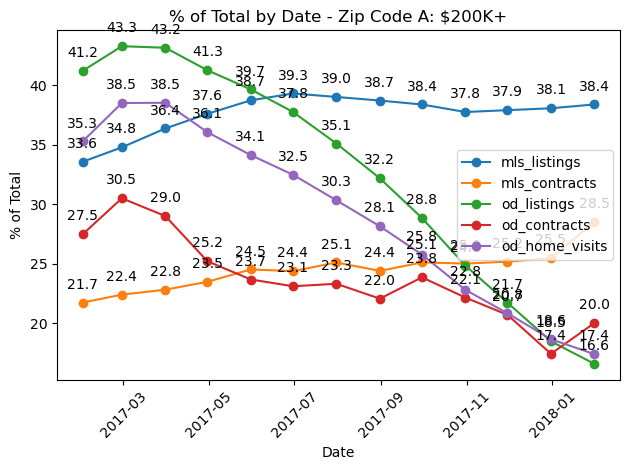



ANALYZING ZIP CODE A - PRICE BAND <$200K



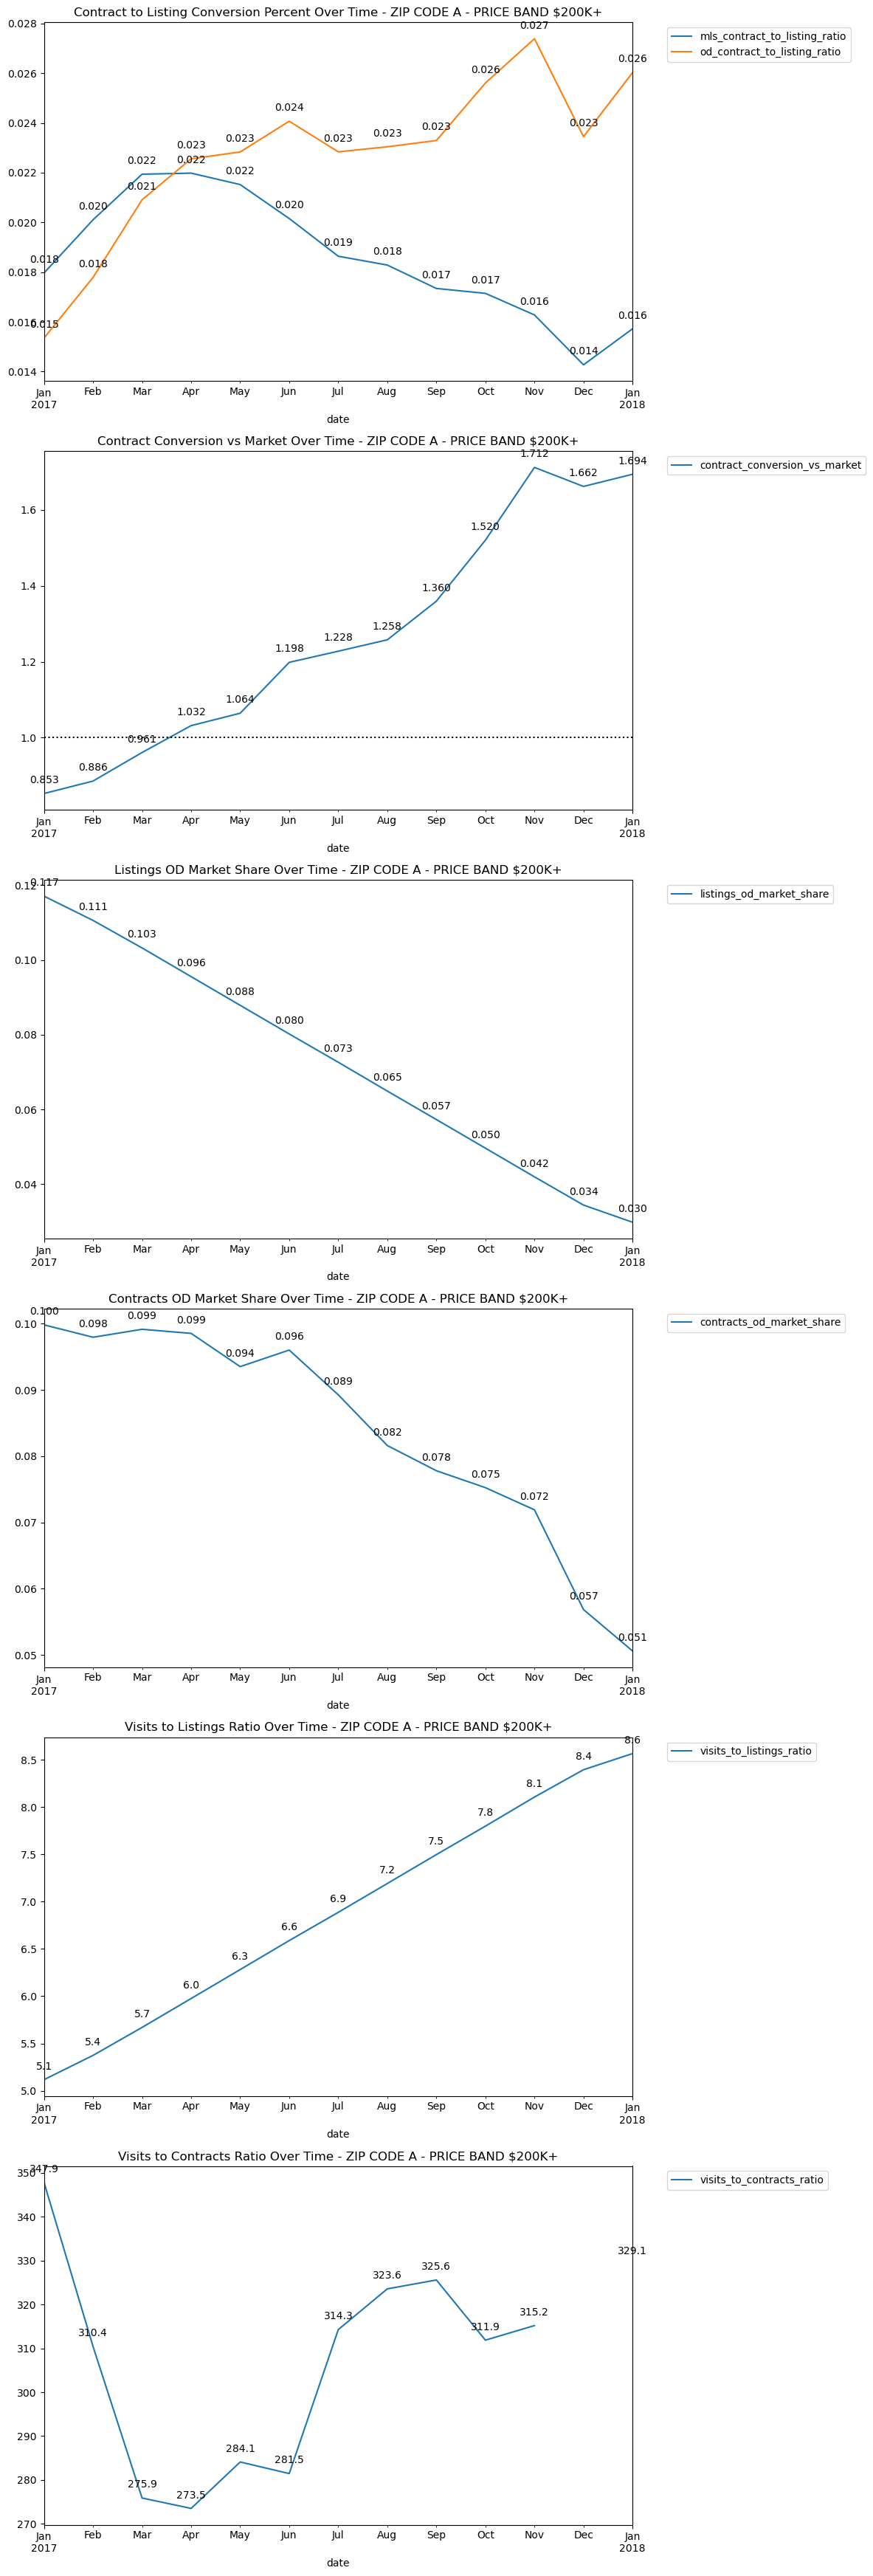

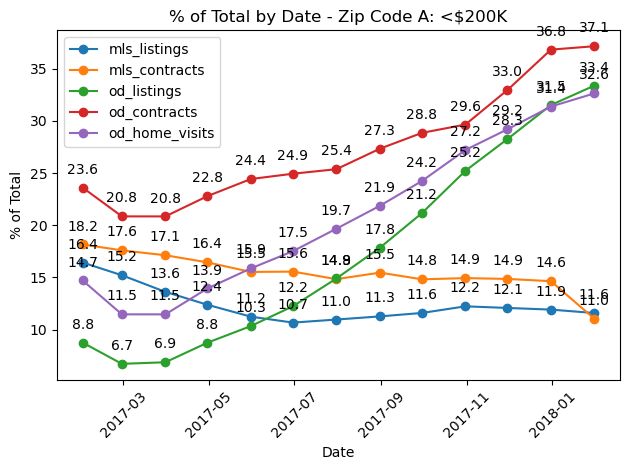



ANALYZING ZIP CODE B - PRICE BAND $200K+



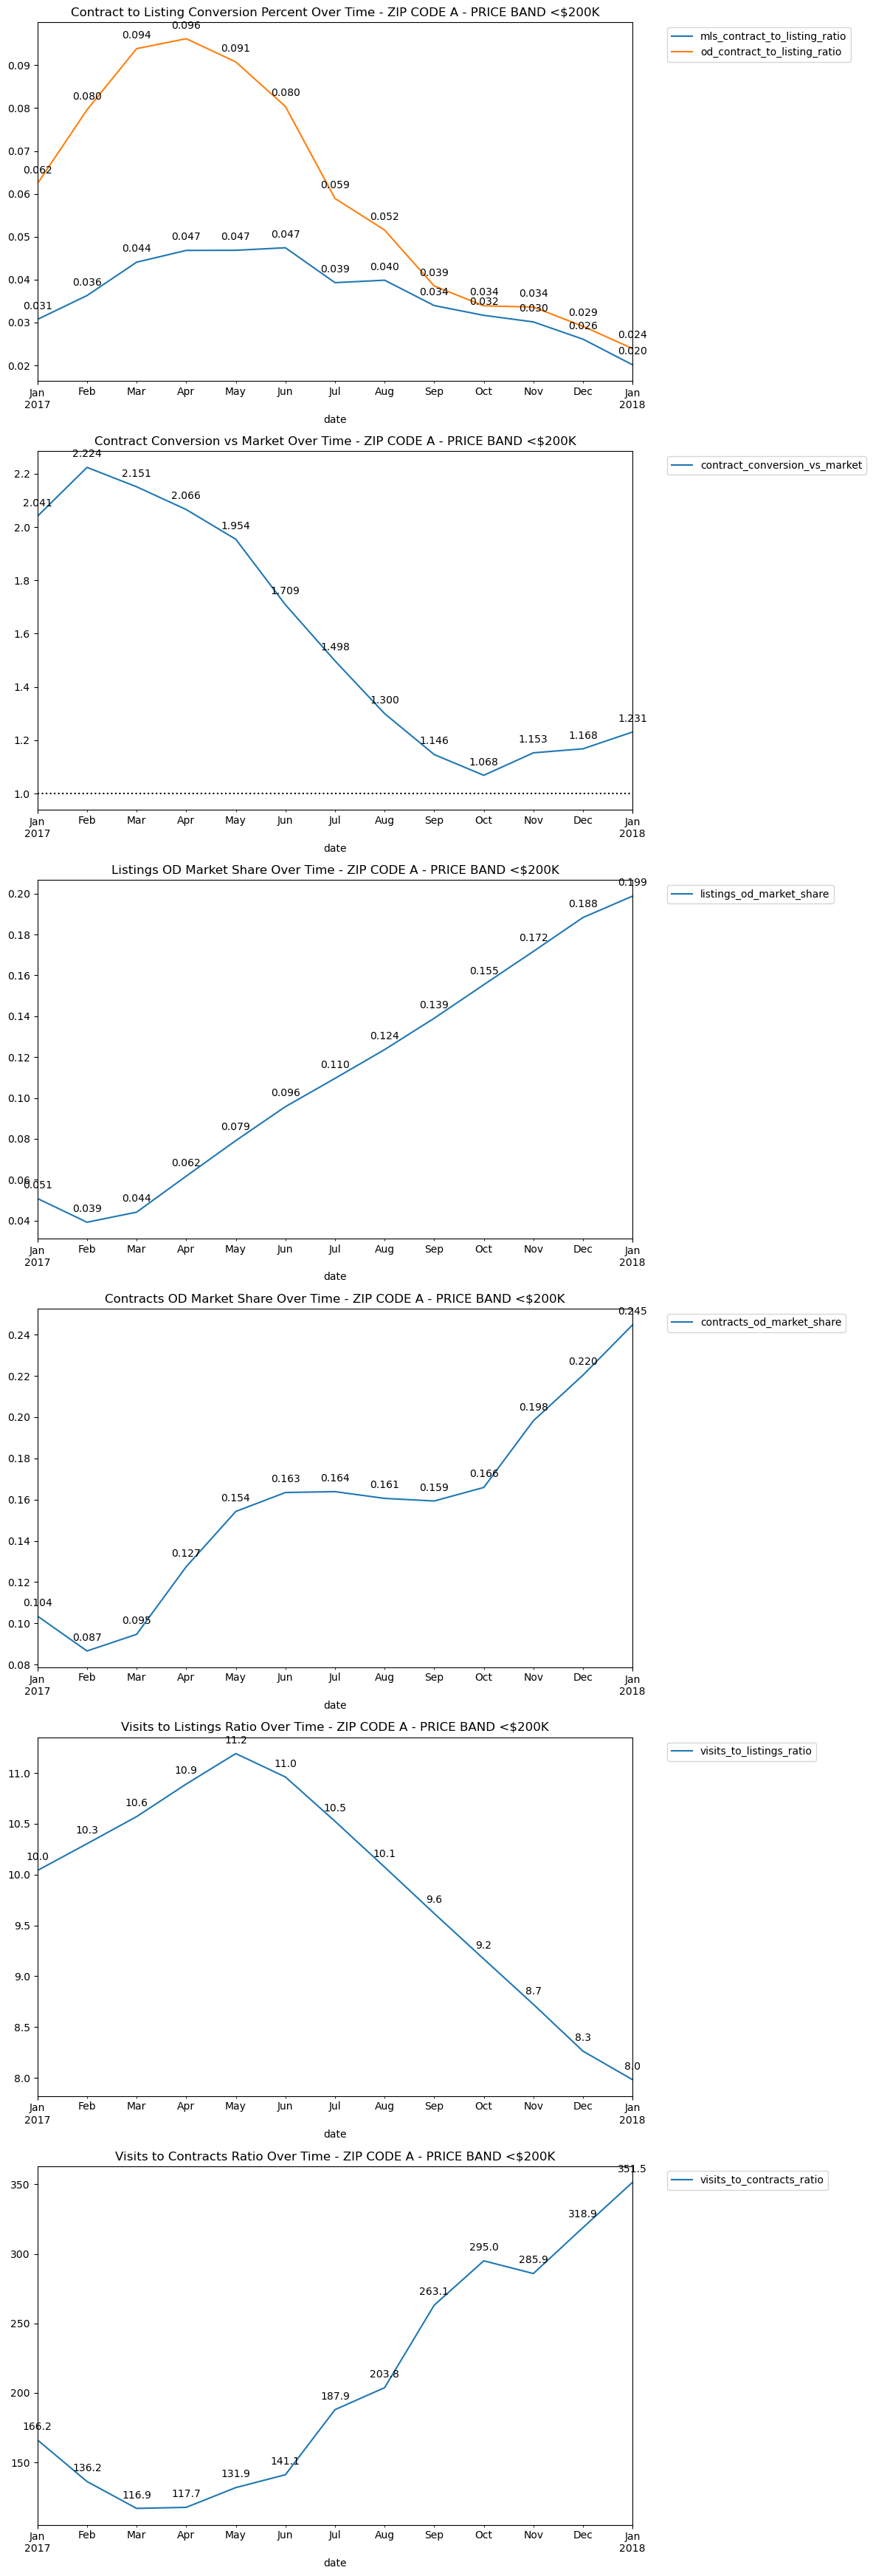

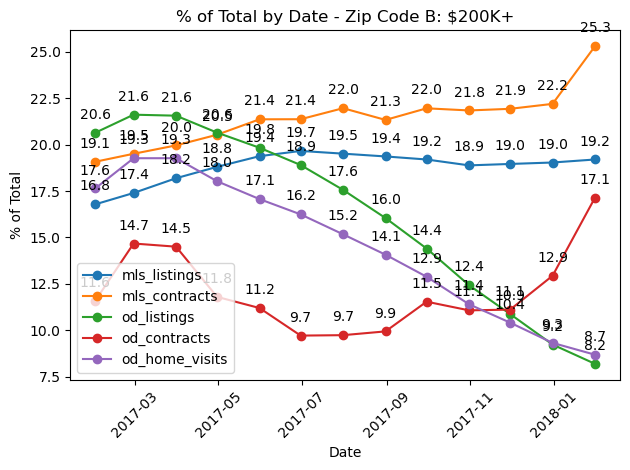



ANALYZING ZIP CODE B - PRICE BAND <$200K



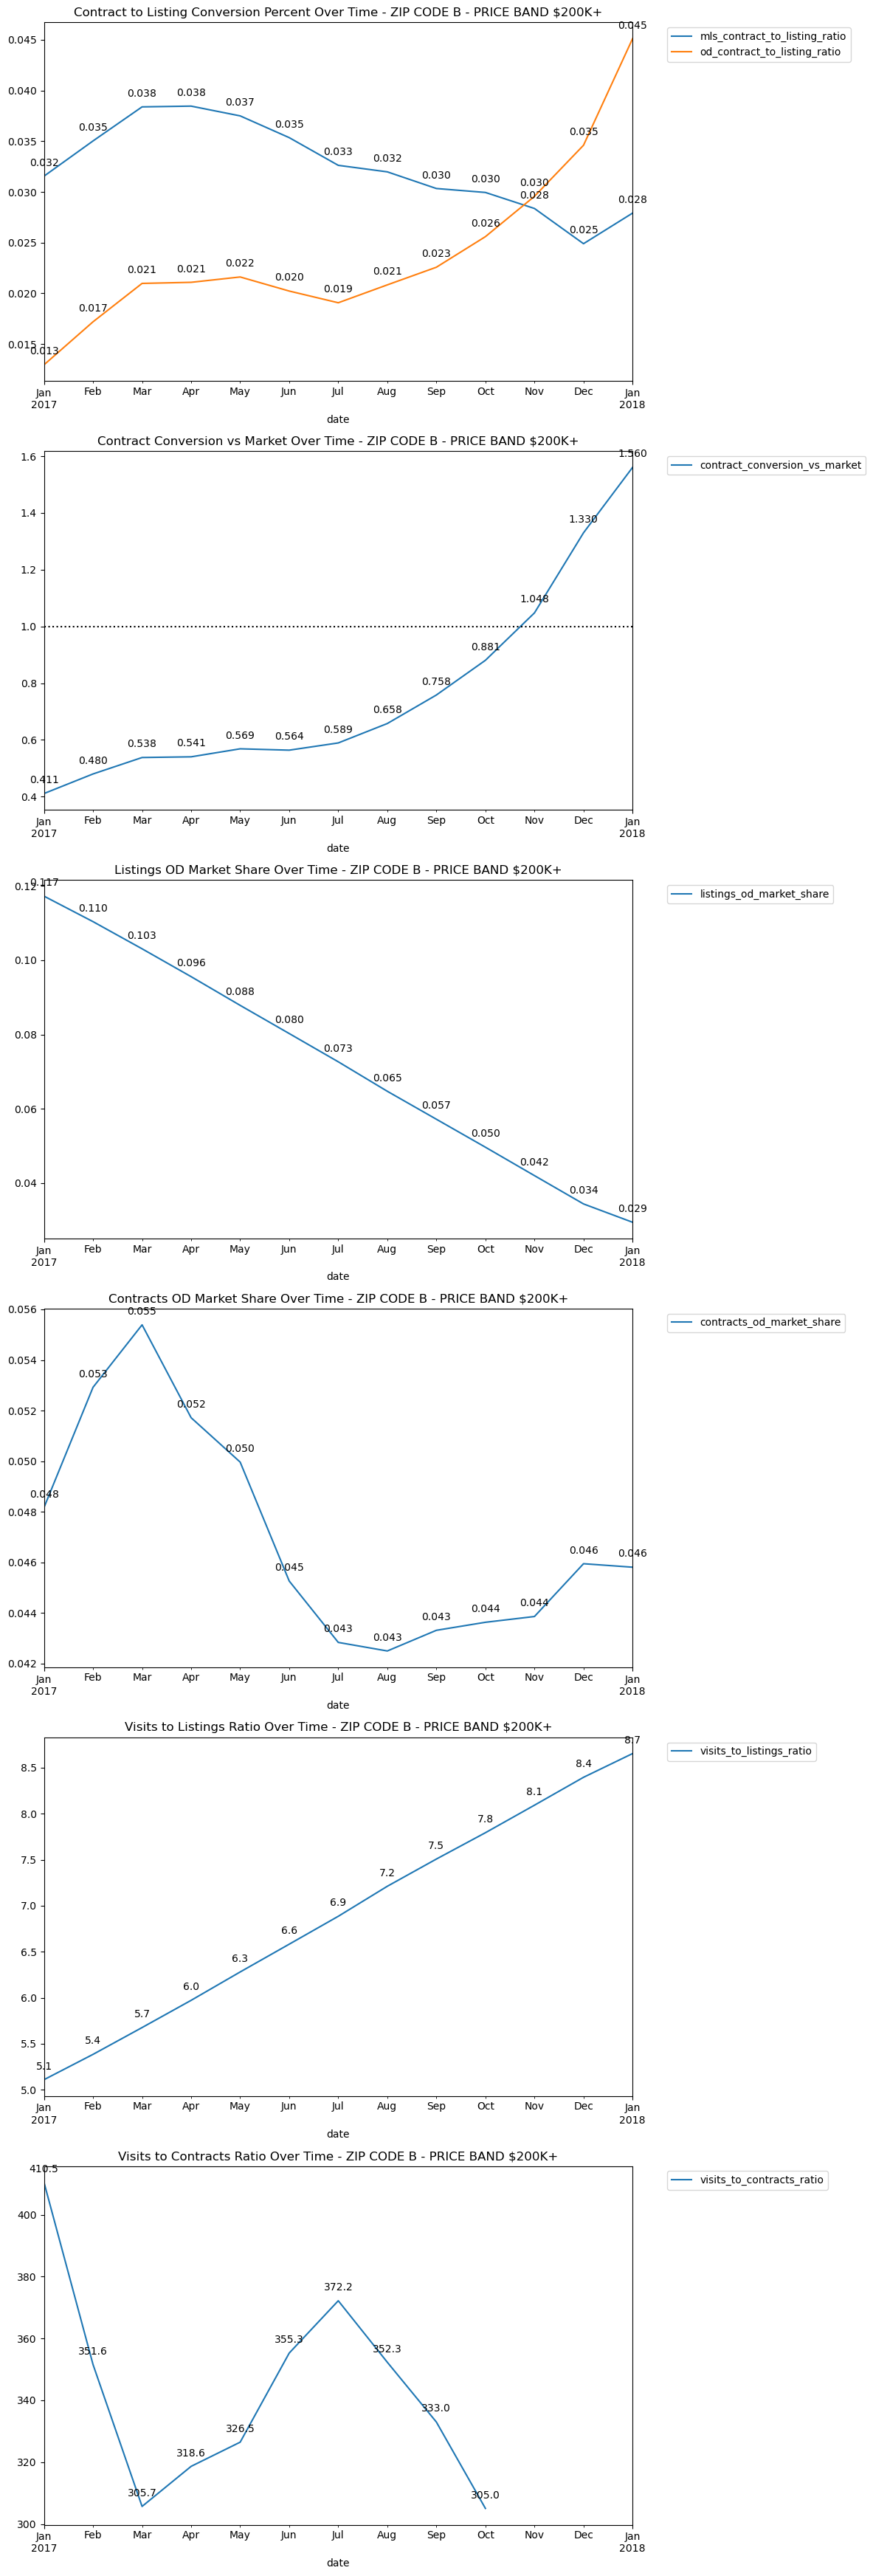

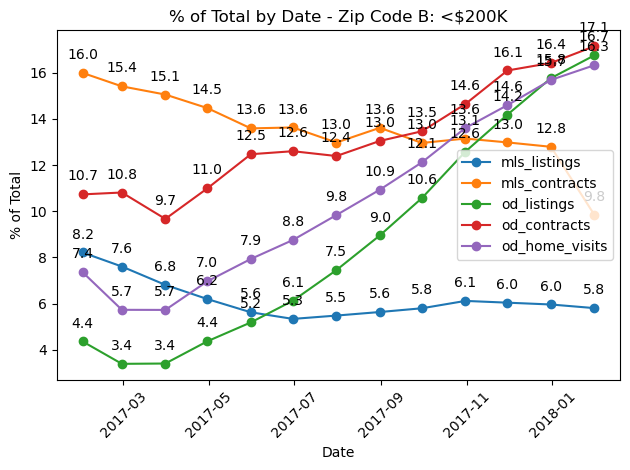



ANALYZING ZIP CODE C - PRICE BAND $200K+



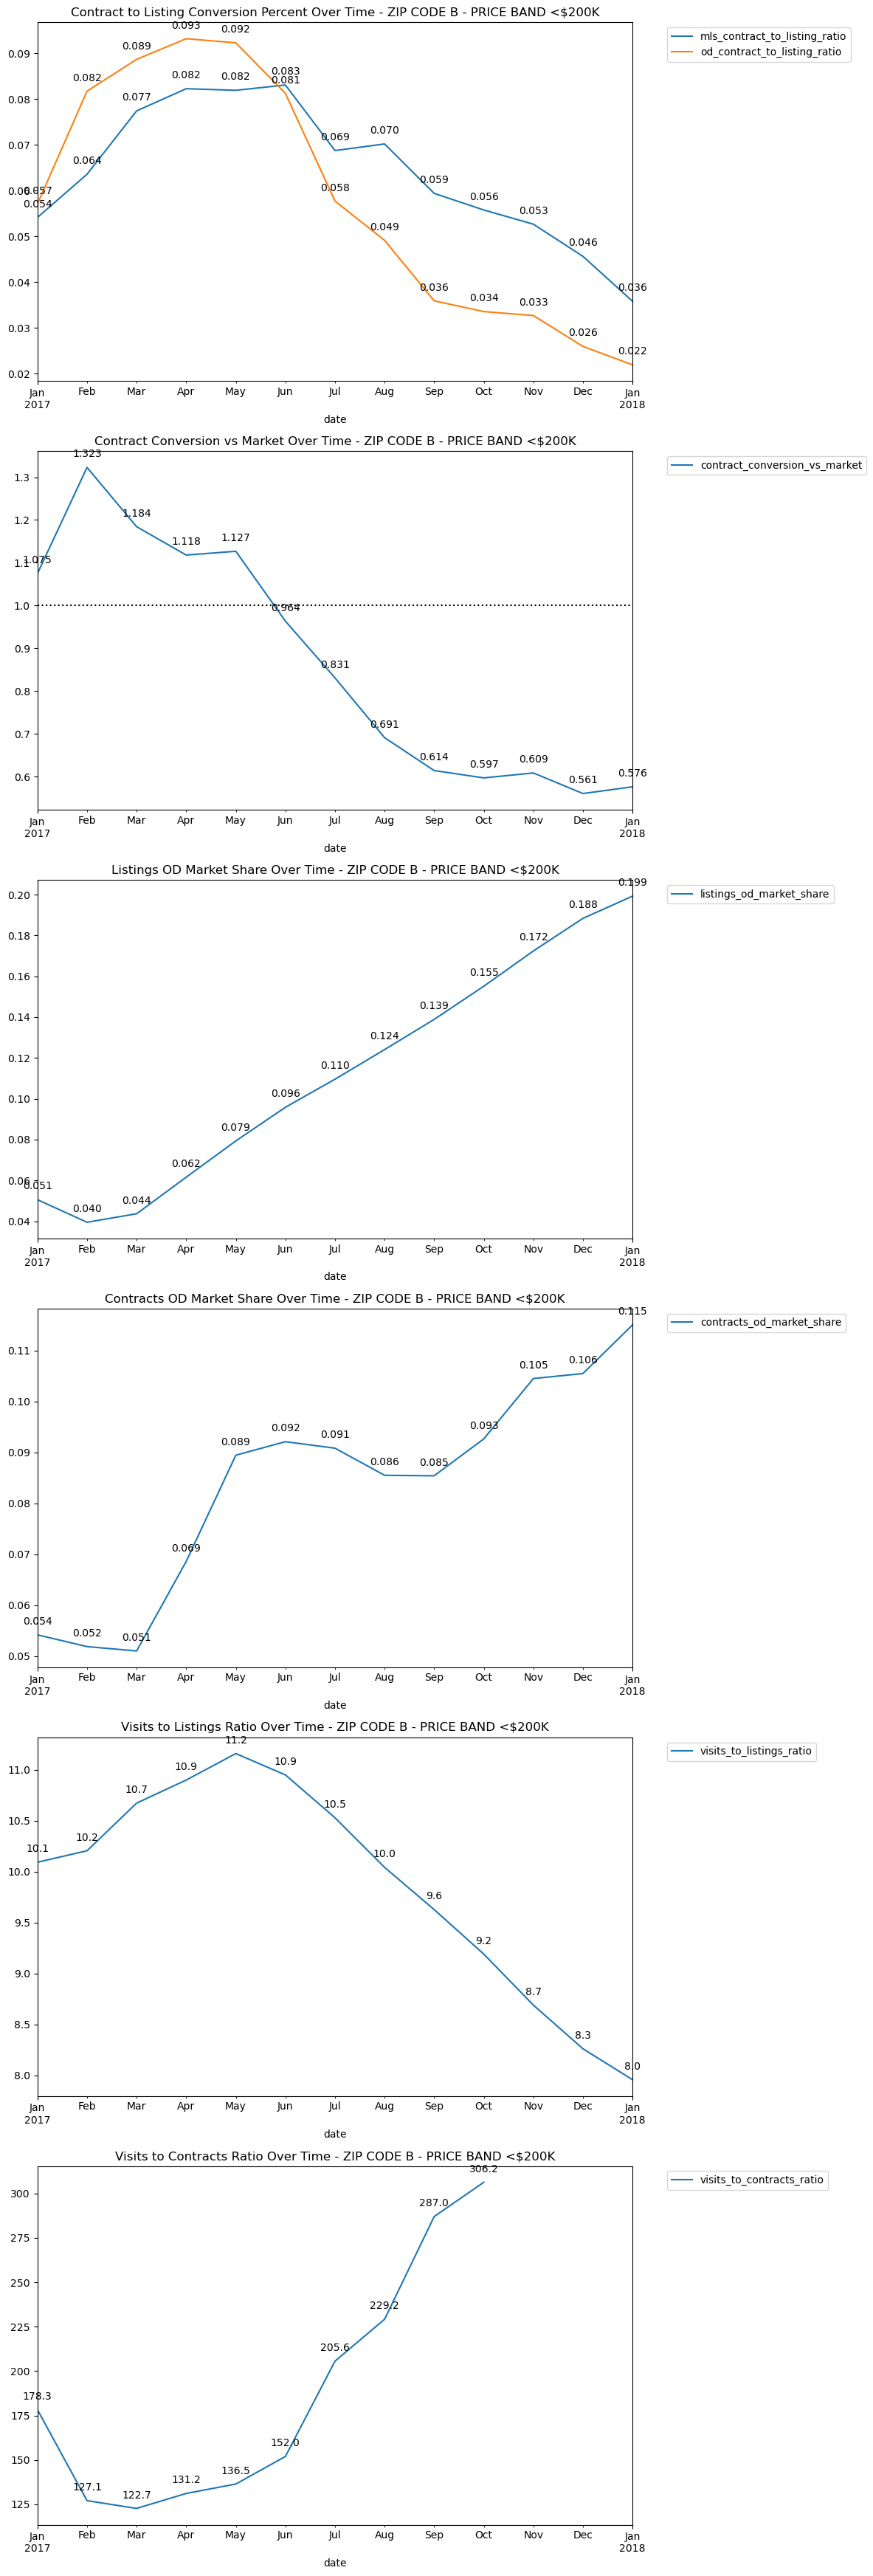

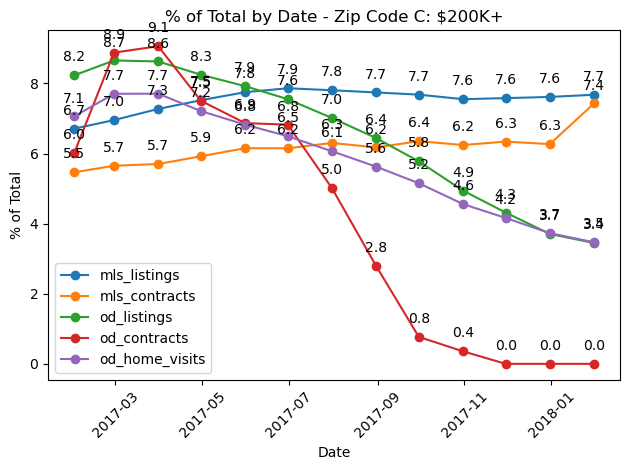



ANALYZING ZIP CODE C - PRICE BAND <$200K



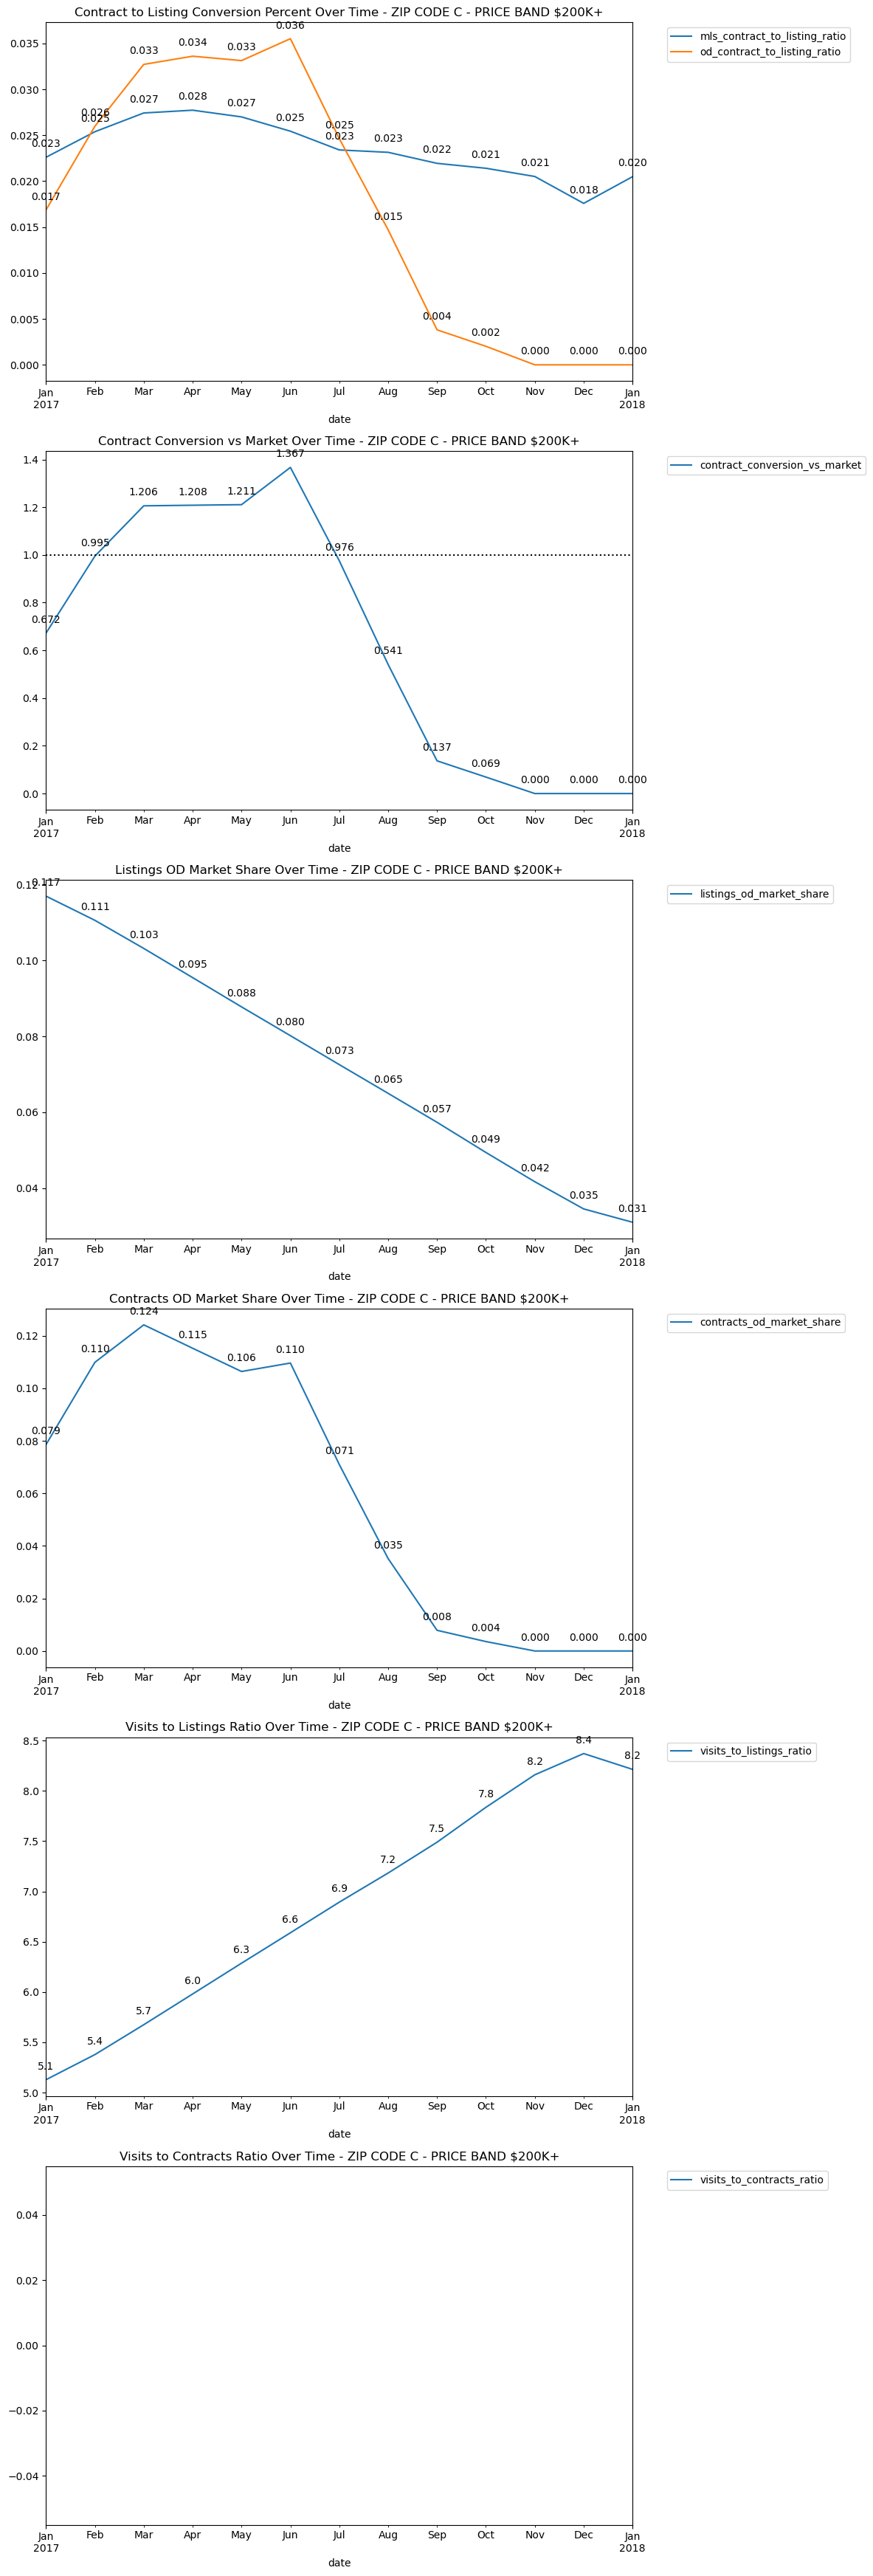

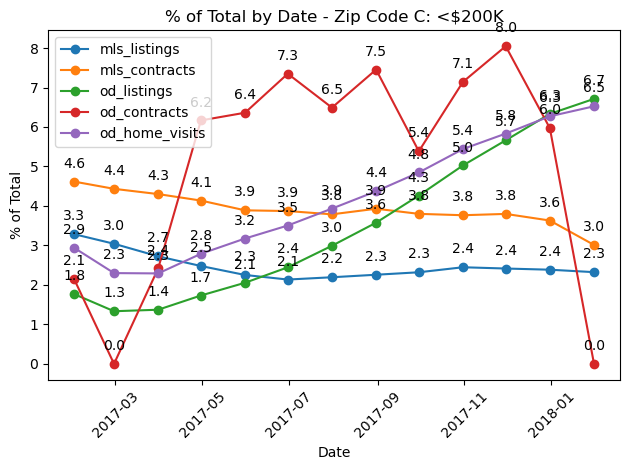



ANALYZING ZIP CODE D - PRICE BAND $200K+



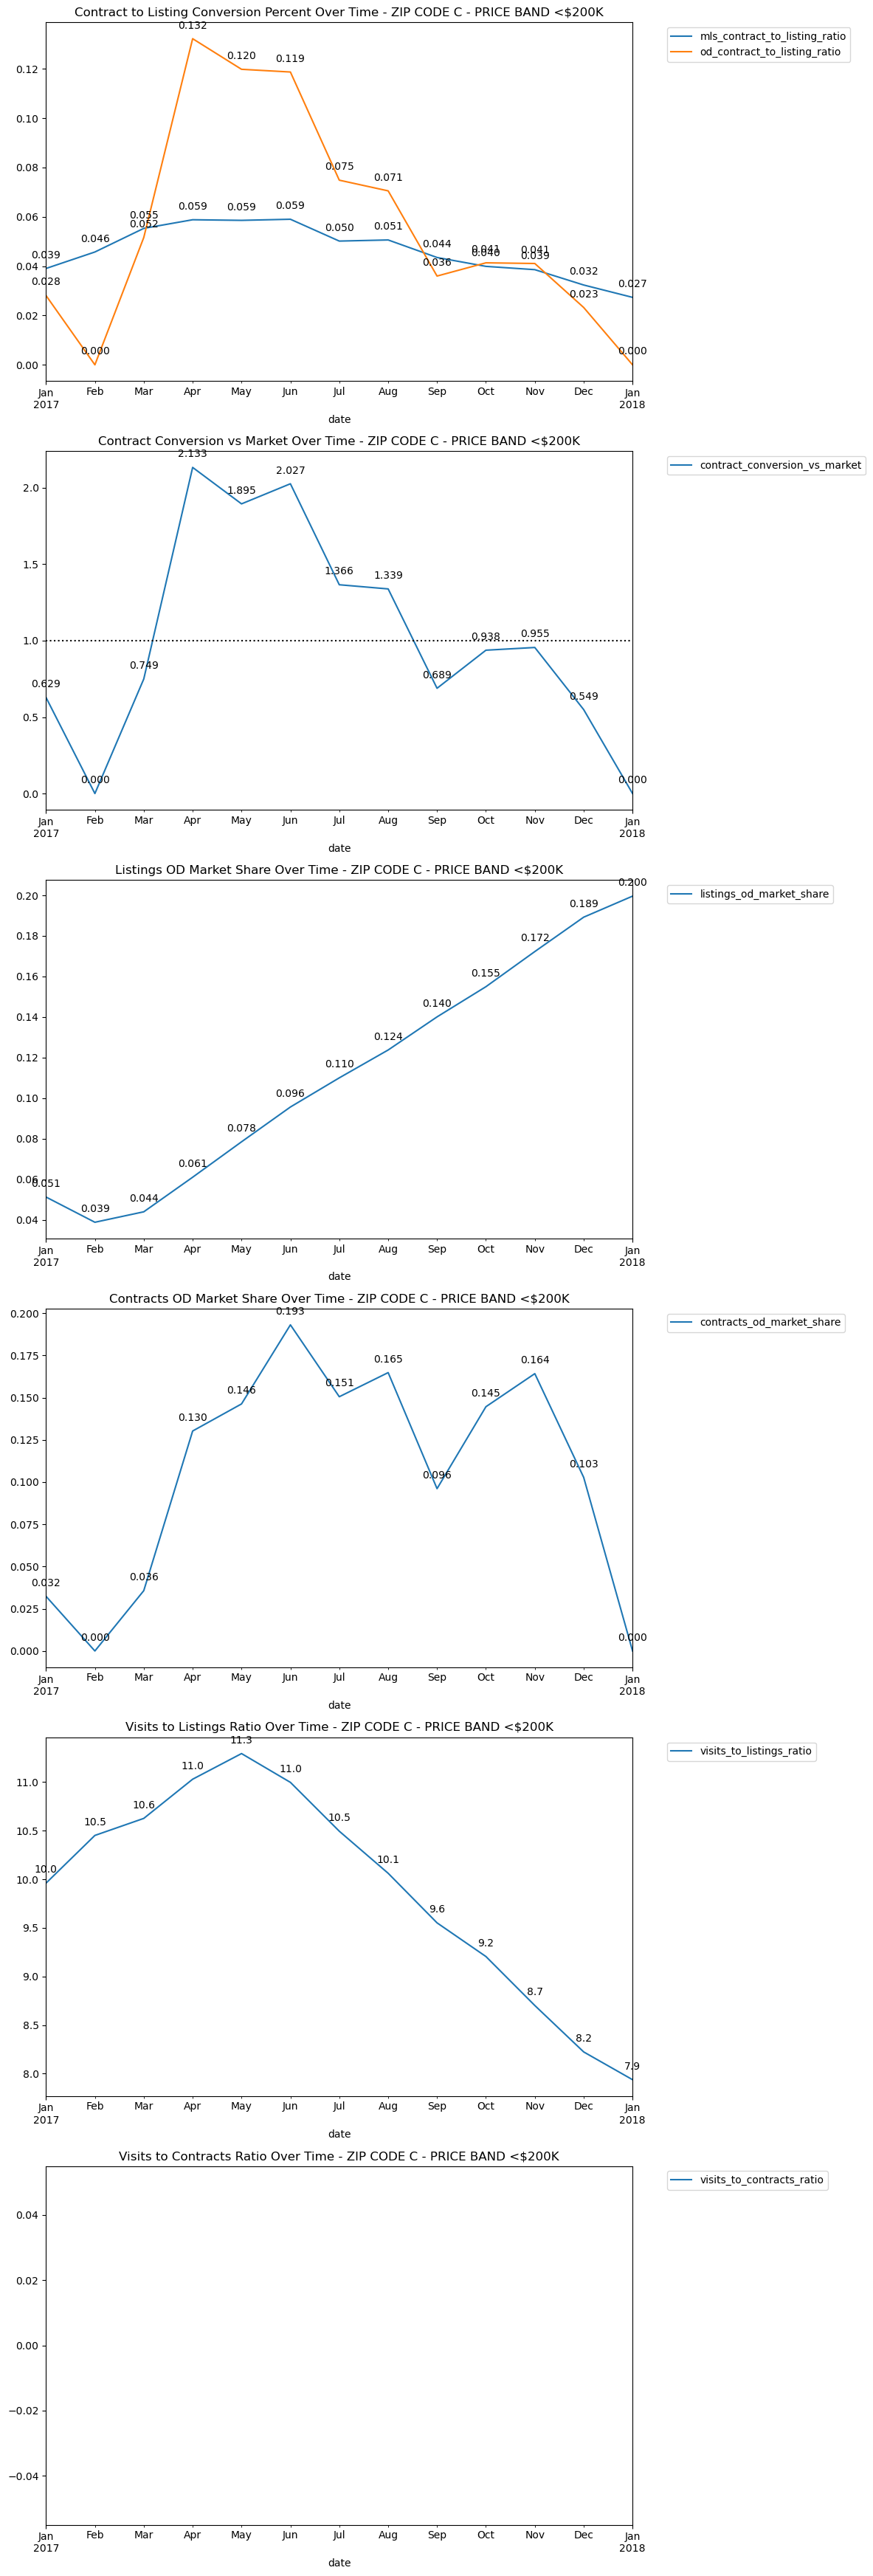

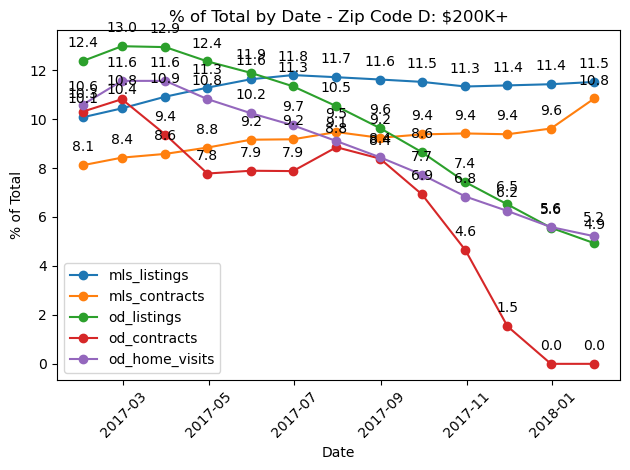



ANALYZING ZIP CODE D - PRICE BAND <$200K



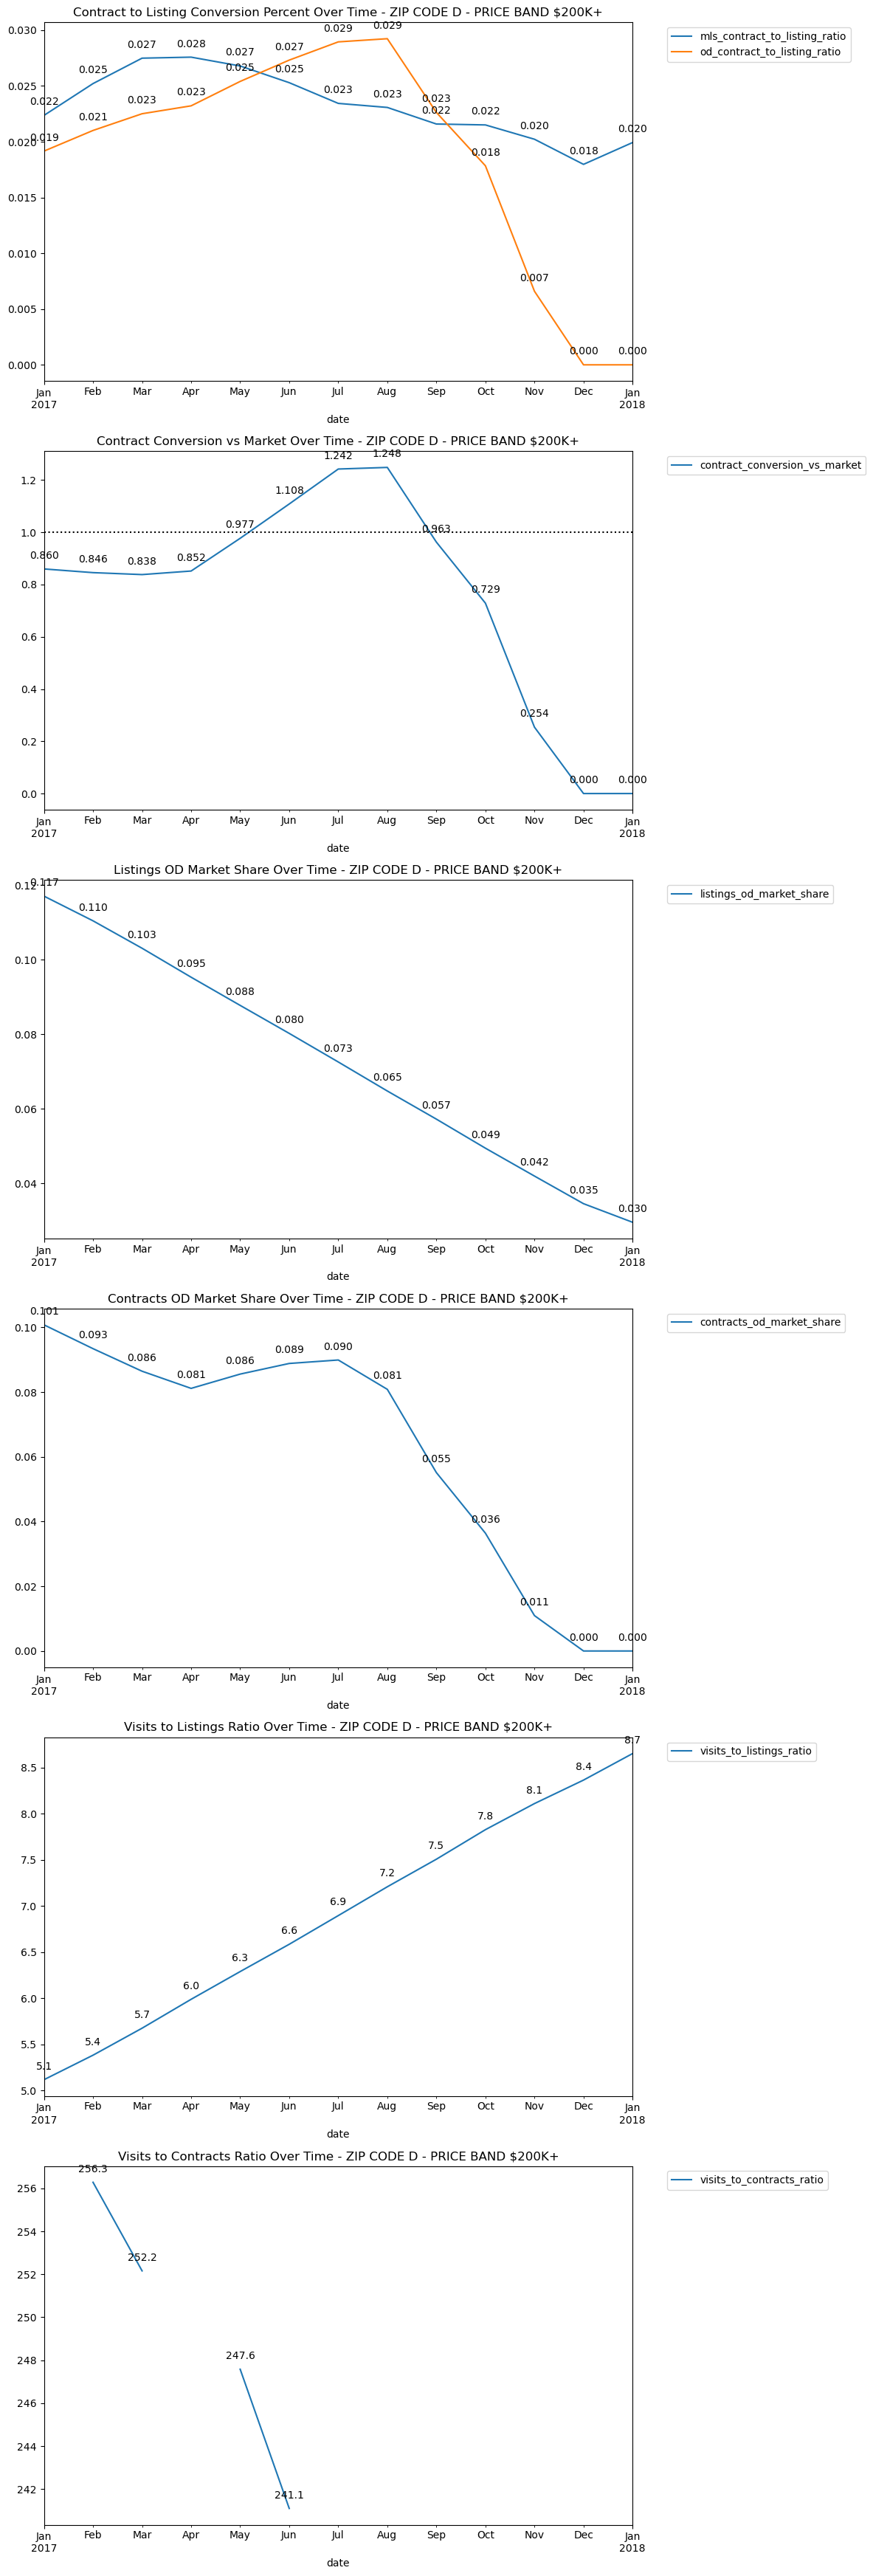

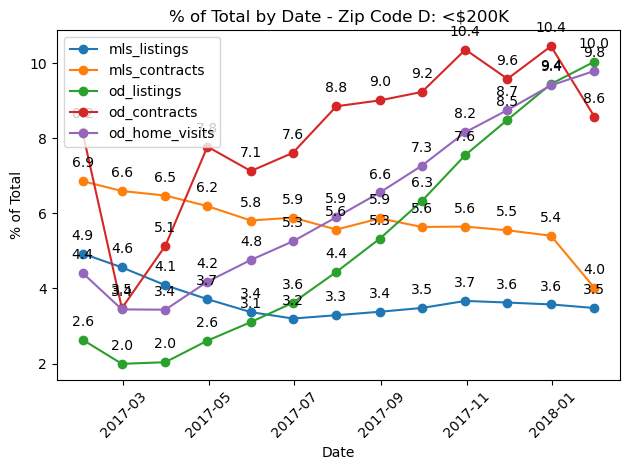

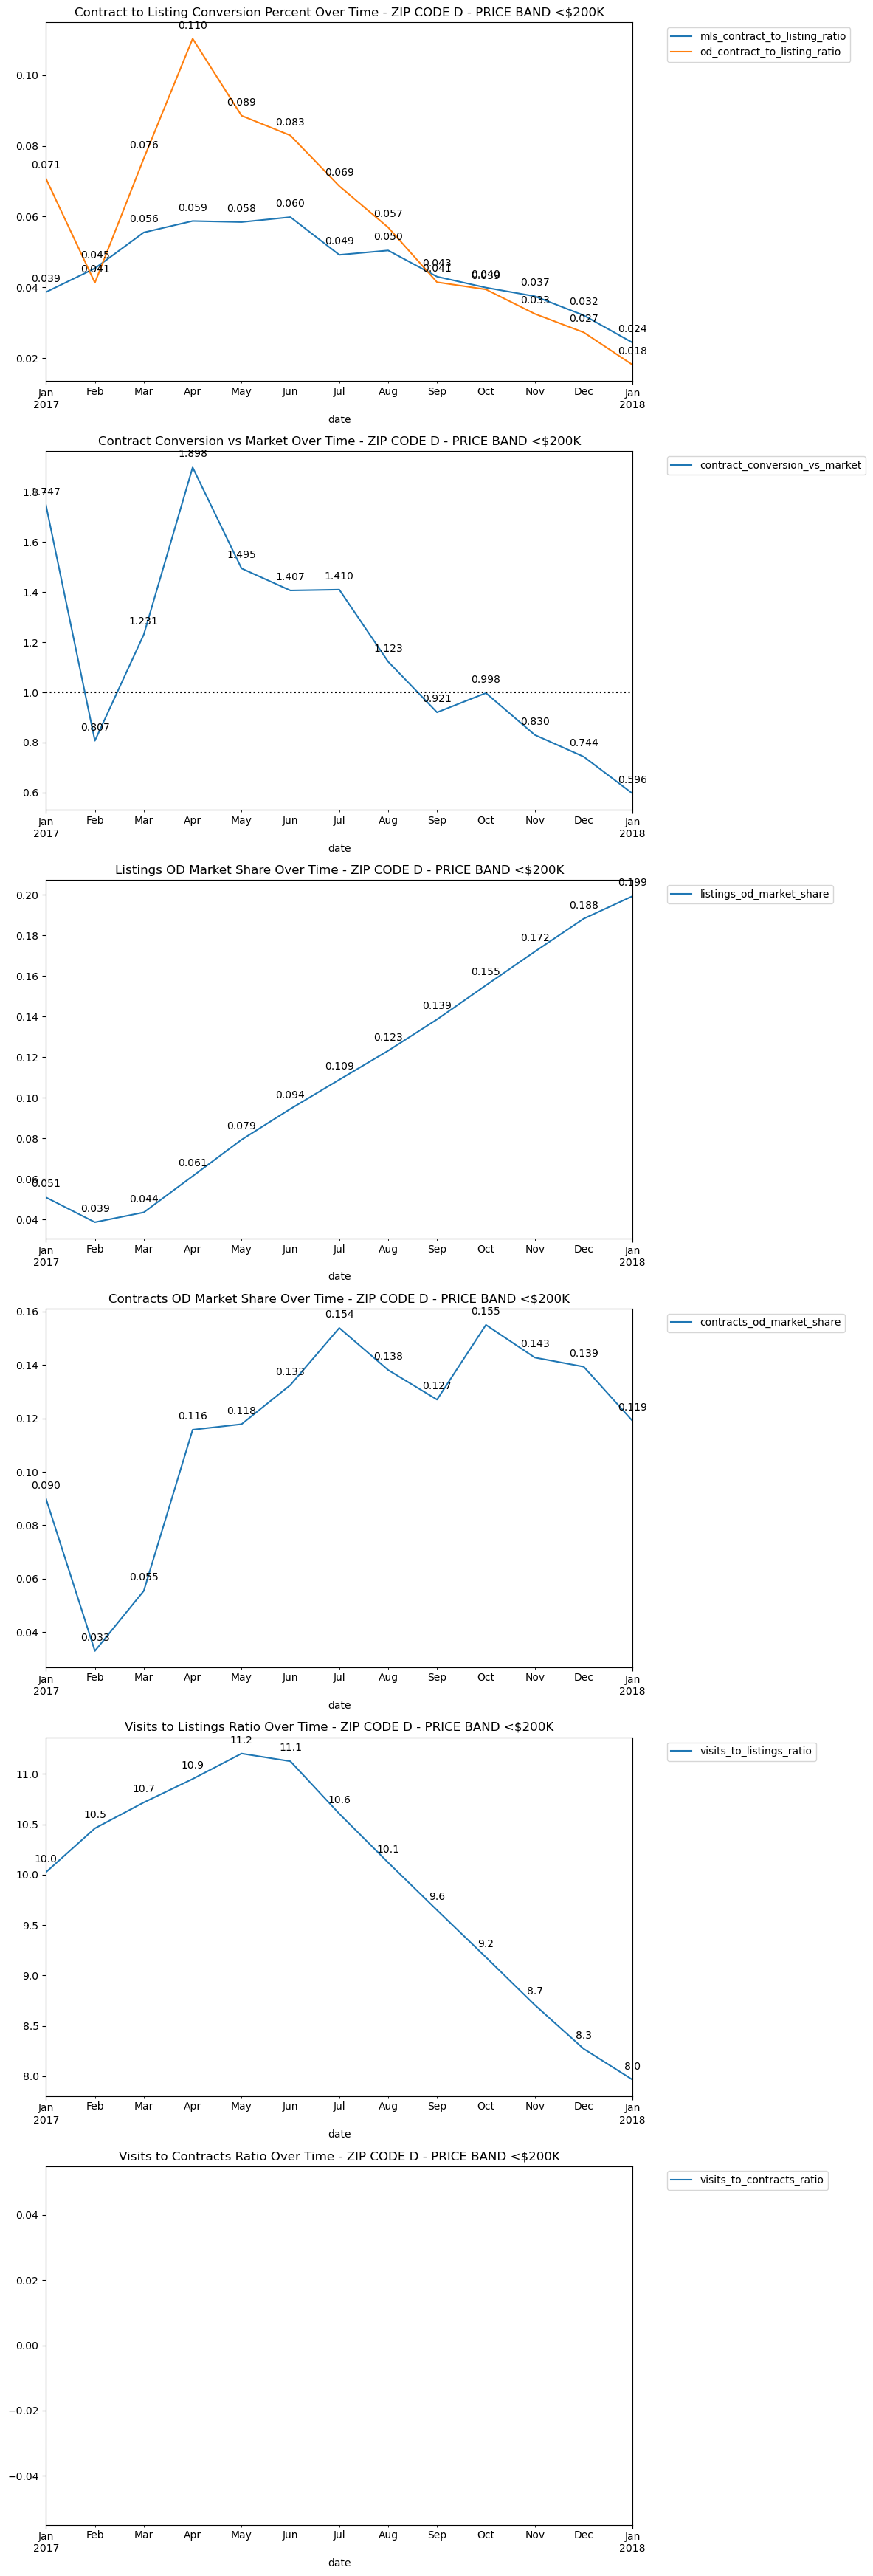

In [71]:

# Visualize all of the different segments for key metrics
for name, group in data.groupby(['zip_code', 'price_band']):
    zip_code, price_band = name
    print("\n" + "="*80)
    print(f"\nANALYZING ZIP CODE {zip_code} - PRICE BAND {price_band}")
    print("="*80 + "\n")

    segment_data = monthly_pct.query('zip_code == @zip_code and price_band == @price_band')
    plt.figure(figsize=(6.4, 4.8))
    for column in ['mls_listings', 'mls_contracts', 'od_listings', 'od_contracts', 'od_home_visits']:
        plt.plot(segment_data['date'], segment_data[column], marker='o', label=column)
        for x, y in zip(segment_data['date'], segment_data[column]):
            plt.annotate(f'{y:.1f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
    plt.xlabel('Date')
    plt.ylabel('% of Total')
    plt.title(f'% of Total by Date - Zip Code {zip_code}: {price_band}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    xs = group.copy()
    xs = xs.drop(['zip_code', 'price_band'], axis=1)
    xs = calculate_performance_metrics(xs)
    plot_performance_metrics(xs, title_flag=f'ZIP CODE {zip_code} - PRICE BAND {price_band}')


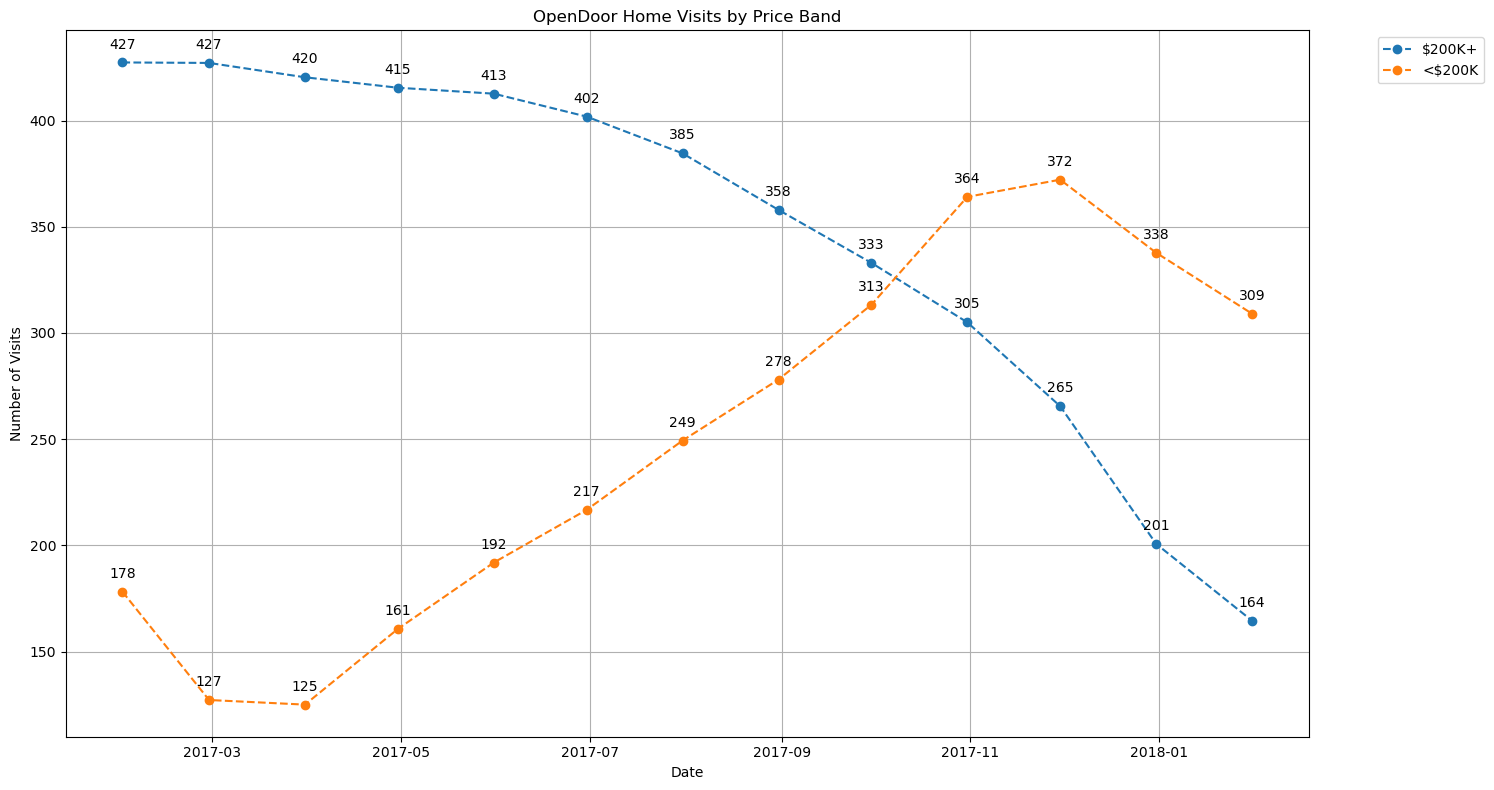

In [91]:
monthly_visits_by_price = data.groupby([
    'price_band',
    pd.Grouper(key='date', freq='ME')
])['od_home_visits'].mean().reset_index()

# Create plot
plt.figure(figsize=(15, 8))

# Plot each price band
for band in monthly_visits_by_price['price_band'].unique():
    band_data = monthly_visits_by_price[monthly_visits_by_price['price_band'] == band]
    plt.plot(band_data['date'], band_data['od_home_visits'], 
            marker='o', label=band, linestyle='--')
    
    # Add value labels
    for x, y in zip(band_data['date'], band_data['od_home_visits']):
        plt.annotate(f'{y:.0f}', 
                    (x, y),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')

plt.title('OpenDoor Home Visits by Price Band')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

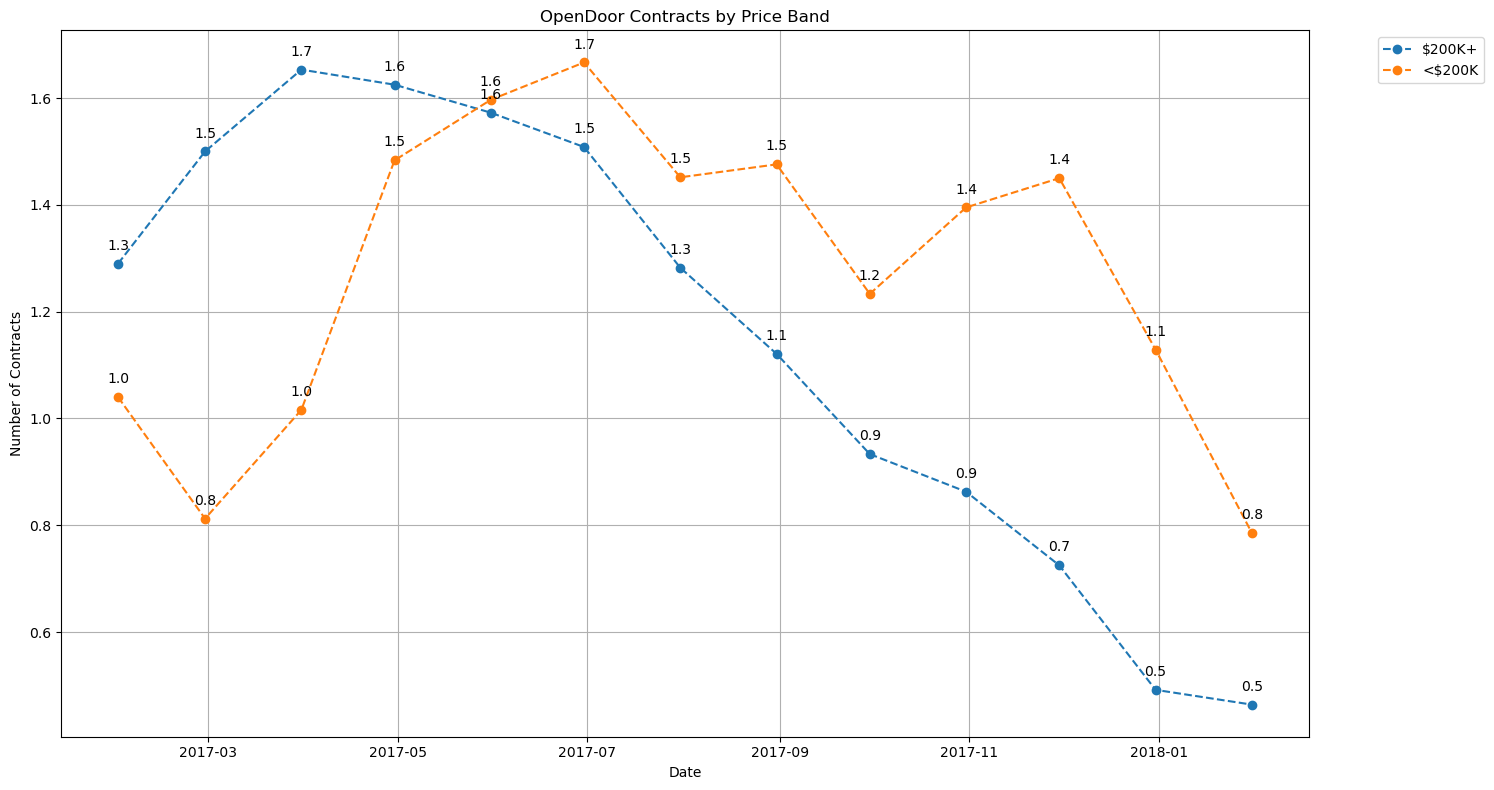

In [93]:
# Need to be understand visits to contracts ratio for price bands
# Group by price_band and calculate mean monthly contracts
monthly_contracts_by_price = data.groupby([
    'price_band',
    pd.Grouper(key='date', freq='ME')
])['od_contracts'].mean().reset_index()

# Create plot
plt.figure(figsize=(15, 8))

# Plot each price band
for band in monthly_contracts_by_price['price_band'].unique():
    band_data = monthly_contracts_by_price[monthly_contracts_by_price['price_band'] == band]
    plt.plot(band_data['date'], band_data['od_contracts'], 
            marker='o', label=band, linestyle='--')
    
    # Add value labels
    for x, y in zip(band_data['date'], band_data['od_contracts']):
        plt.annotate(f'{y:.1f}', 
                    (x, y),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')

plt.title('OpenDoor Contracts by Price Band')
plt.xlabel('Date')
plt.ylabel('Number of Contracts')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()